In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import os
import copy
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import label
from scipy.stats import mode
import re

In [3]:
starting_input = {
    "selected_plants": [
        {
            "Plant Type": "Herbaceous Plant, Shrub",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "Bee-Attracting",
            "Hazard": "-",
            "Canopy Radius": "None",
            "Species Name": "Bird's Nest Fern"
        },
        {
            "Plant Type": "Herbaceous Plant, Shrub",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "-",
            "Hazard": "Toxic Upon Ingestion",
            "Canopy Radius": "None",
            "Species Name": "Horse Cassia"
        },
        {
            "Plant Type": "Herbaceous Plant, Shrub",
            "Light Preference": "Full Sun",
            "Attracted Animals": "-",
            "Hazard": "Toxic Upon Ingestion",
            "Canopy Radius": "None",
            "Species Name": "Golden Bells"
        },
        {
            "Plant Type": "Herbaceous Plant, Shrub",
            "Light Preference": "Full Sun",
            "Attracted Animals": "-",
            "Hazard": "-",
            "Canopy Radius": "None",
            "Species Name": "Broad-leaved Sterculia"
        },
        {
            "Plant Type": "Herbaceous Plant, Tree",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "-",
            "Hazard": "Toxic Upon Ingestion",
            "Canopy Radius": "19",
            "Species Name": "Seashore Ardisia"
        },
        {
            "Plant Type": "Palm",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "-",
            "Hazard": "-",
            "Canopy Radius": "10",
            "Species Name": "Fishtail Palm"
        }
    ],
    "theme": "naturalistic"
}


In [4]:
class customSpatialEnv(gym.Env):
    def __init__(self, octave: float, grid_size: tuple = (100, 100), seed: int = None):
            """
            Args:
                octave (float): octave value from range [1-2] for Perlin noise.
                grid_size (tuple): (width, height) of the grid, defaults to (100, 100).
                seed (int): Random seed for reproducibility, defaults to None.
            """
            super(customSpatialEnv, self).__init__()
            self.seed_value = seed
            self.random_state = np.random.RandomState(seed)  # Controlled randomness
            self.grid_size = grid_size
            self.octave = octave
            self.max_attempts = 100000  # Maximum number of attempts
            self.attempt_counter = 0  # Tracks the number of attempts

            self.grid, self.planting_coordinates, self.distances = self._create_environment()

            # Plants: 1 for Tree, 2 for Shrub, 0 for No plant (added)
            self.plants = np.array([0, 1, 2])  # [No Plant, Tree, Shrub]

            # Action space: Use Box for percentage (horizontal, vertical) and plant type (no object, shrub, tree)
            self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

            # Observation space: Dict containing the grid and distances (both horizontal and vertical)
            self.observation_space = spaces.Dict({
                "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
                "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Vertical distance (top)
                "tree_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of trees
                "shrub_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of shrubs
                "good_tree_spot": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Whether the spot is good for planting a tree
                "border_score": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  
            })

            self.num_trees = 0
            self.num_shrubs = 0
            self.planted_tree_positions = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()
        self.attempt_counter = 0

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        if len(self.distances) > 0:
            initial_distances = self.distances[0]
        else:
            initial_distances = [0, 0]  # Handle case where no distances are available

        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        tree_proportion = np.array([0.0], dtype=np.float32)
        shrub_proportion = np.array([0.0], dtype=np.float32)
        good_tree_spot = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)
        border_score = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)

        # Initial observation
        return {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }, {}

    def step(self, action):
        """
        The step function takes a single action, which contains three parts:
        - action[0]: horizontal ratio (0-1).
        - action[1]: vertical ratio (0-1).
        - action[2]: plant type selector (0-1), now including No Plant.
        """

        self.attempt_counter += 1

        # Default value for reward (in case of termination due to exceeding max attempts)
        reward = 0  

        # If the number of attempts exceeds max_attempts, terminate the episode with a penalty
        if self.attempt_counter > self.max_attempts:
            reward = -50  # Apply a significant penalty for exceeding maximum attempts
            terminated = True
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, False, {}

        # Unpack the action
        horizontal_ratio = action[0]
        vertical_ratio = action[1]
        plant_type_selector = action[2]

        # Use the horizontal and vertical ratio to find the nearest planting coordinates
        horizontal_target = horizontal_ratio * self.grid_size[1]  # Scale to grid width
        vertical_target = vertical_ratio * self.grid_size[0]  # Scale to grid height

        # Find the closest coordinate to the generated ratio
        coord_index = np.argmin(np.sum(np.abs(self.planting_coordinates - [vertical_target, horizontal_target]), axis=1))

        # Calculate the difference between the target and the selected plantable coordinates
        selected_coord = self.planting_coordinates[coord_index]
        diff = np.linalg.norm(np.array([vertical_target, horizontal_target]) - np.array(selected_coord))

        # Penalize if the distance is greater than 0.5
        if diff > 20:
            reward = 0  # Apply a penalty for selecting a coordinate that is too far from any plantable spot
            terminated = False
            truncated = False
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, truncated, {}

        # Use the plant type selector to determine the plant type
        if plant_type_selector < 0.33:
            plant_type = 0  # No Plant (new option)
        elif plant_type_selector < 0.66:
            plant_type = 1  # Tree
        else:
            plant_type = 2  # Shrub

        # The rest of the planting logic if a valid spot is selected
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            if len(self.distances) > 0:  # Ensure there are distances to access
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            ####################################################################################
            ### Shrub Proportion and Tree proportion and reward mechanism
            #  Calculate tree and shrub proportions
            total_plants = self.num_trees + self.num_shrubs
            tree_proportion = self.num_trees / total_plants if total_plants > 0 else 0
            shrub_proportion = self.num_shrubs / total_plants if total_plants > 0 else 0
            balance_reward = 0

            # Update tree and shrub counts
            if self.plants[plant_type] == 1:
                self.num_trees += 1
                self.planted_tree_positions.append(planting_coord)  # Track tree positions
                if tree_proportion > 0.2:
                    balance_reward += 2

            elif self.plants[plant_type] == 2:
                self.num_shrubs += 1
                if shrub_proportion > 0.6:
                    balance_reward += 1

            ####################################################################################
            ### Good Tree Spot and Distance mechanism
            good_tree_spot = 1.0  # Assume the spot is good initially
            if plant_type == 1:  # Only check for trees
                for tree_pos in self.planted_tree_positions:
                    if np.array_equal(tree_pos, planting_coord):
                        continue
                    # Calculate the distance between the planted tree and all other trees
                    dist = np.linalg.norm(np.array(planting_coord) - np.array(tree_pos))
                    if dist < 50:  # If any tree is within 50 units, it's not a good spot
                        good_tree_spot = 0.0
                        break
            distance_reward = 0.5
            # Only apply reward for trees (plant_type == 1)
            if self.plants[plant_type] == 1:
                # Apply a reward based on how far the nearest tree is, capped at 50 units
                if good_tree_spot == 1.0:
                    distance_reward = 1  # Normalize reward (closer to 50 = higher reward)
                else:
                    distance_reward = 0

            ####################################################################################

            ### Border Score Segment

            # Retrieve the distances for the selected planting coordinate
            if len(self.distances) > 0:
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            border_score = 0
            if (abs(horizontal_distance - 0.5) + abs(vertical_distance - 0.5)) > 0.8:
                border_score = 1

            ####################################################################################

            ### Total reward Segment
            reward = 3 * balance_reward + 2 *distance_reward + border_score
            ####################################################################################

            if plant_type == 0:
            # No planting is done, but a small positive reward could be given to avoid excessive no-action use
                reward = 1

        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action
            tree_proportion = self.num_trees / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            shrub_proportion = self.num_shrubs / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            good_tree_spot = 0.0

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)
        tree_proportion = np.array([tree_proportion], dtype=np.float32)
        shrub_proportion = np.array([shrub_proportion], dtype=np.float32)
        good_tree_spot = np.array([good_tree_spot], dtype=np.float32)
        border_score = np.array([border_score], dtype=np.float32)

        # Observation: the current state of the environment (grid, distances, and tree/shrub proportions)
        observation = {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }

        # Check if the episode should end (plant all possible spots)
        terminated = len(self.planting_coordinates) == 0

        # Truncated remains False
        truncated = False

        info = {
            'diff': diff  # Add diff to the info dictionary
        }

        return observation, reward, terminated, truncated, info


    def _create_environment(self):
        """
        Function to create a test environment using Perlin noise.
        """
        while True:
            # Use the random state for reproducibility
            seed = self.random_state.randint(0, 50) if self.seed_value is None else self.seed_value
            noise = PerlinNoise(octaves=self.octave, seed=seed)
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i / height, j / width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5 / 100:
                break

        planting_grid, planting_coords = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env)  # Adjust input as needed
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy

    
    
import matplotlib.patches as mpatches
    
def load_model(env):
    global model
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048, gamma=0.99, learning_rate=0.0003, ent_coef=0.05)
    return model

# Train the model without saving automatically
def train_model(env):
    global model
    model.learn(total_timesteps=100000)
    return model

# Function to render one episode and test the model
def render_episode(env, model):
    obs, _ = env.reset()
    step = 0
    while True:
        action, _states = model.predict(obs, deterministic=False)
        action, _states = model.predict(obs, deterministic=False)

        # Add some noise to the action to encourage exploration
        noise = np.random.normal(0, 0.1, size=action.shape)  # Adjust noise level as needed
        action += noise
        action = np.clip(action, 0, 1)
        obs, reward, terminated, truncated, info = env.step(action)
        step += 1
        diff = info.get('diff', None)  # Get the diff from the info dictionary
        # print(f"Step {step}: Reward = {reward}, Action = {action}, Diff = {diff}")

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return model

def load_pretrained_model(model_path):
    """
    Load a pretrained PPO model from a specified path.
    """
    if not os.path.exists(model_path):
        raise ValueError(f"Model path {model_path} does not exist.")
    
    model = PPO.load(model_path)
    print(f"Loaded model from {model_path}")
    return model


def generate_new_placement(env, model):
    """
    Generate a new grid and use the model to place trees, shrubs, or no plant until all plantable spots are used.
    """
    obs, _ = env.reset()
    step = 0

    while True:
        action, _states = model.predict(obs, deterministic=False)
        noise = np.random.normal(0, 0.05, size=action.shape)
        randomized_action = np.clip(action + noise, 0, 1)
        obs, reward, terminated, truncated, info = env.step(randomized_action)
        
        step += 1

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return env.grid  # Only return the grid


def extract_tree_shrub_placements(grid):
    """
    Extracts the tree and shrub placements from the final grid.
    
    Args:
        grid (np.ndarray): The final grid after placement.
    
    Returns:
        trees (list of tuple): List of coordinates of tree placements.
        shrubs (list of tuple): List of coordinates of shrub placements.
    """
    trees = list(zip(*np.where(grid == 1)))
    shrubs = list(zip(*np.where(grid == 2)))
    return trees, shrubs


# Main function to load model and generate new placement
def createGrid(model_path, seed=None):
    """
    Generate a new grid and use the model to place trees, shrubs, or no plant until all plantable spots are used.

    Args:
        model_path (str): Path to the pretrained model.
        seed (int, optional): Random seed for reproducibility. Defaults to None.

    Returns:
        np.ndarray: Final grid with plant placements.
    """
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100), seed=seed)
    model = load_pretrained_model(model_path)
    final_grid = generate_new_placement(env, model)
    return final_grid


# Visualization (optional, for debugging)
def visualize_grid_with_circles(grid):
    plt.figure(figsize=(8, 8))
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},
        1: {'color': 'green', 'label': 'Tree', 'size': 50},
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},
        255: {'color': 'black', 'label': 'Border', 'size': 20},
    }

    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=style['size'], alpha=0.8)

    plt.gca().invert_yaxis()
    plt.legend(title="Legend", loc='upper right')
    plt.title("Grid Visualization")
    plt.grid(False)
    plt.show()

In [5]:
def initialise_things():
    model = "./models/23rd.zip" # Model used for the grid Generation
    RNG_seed = None
    input_grid = createGrid(model_path=model, seed=RNG_seed)
    return input_grid

In [24]:
def visualize_heatmap(grid, title="Generated Heatmap", colorbar_label="Value", cmap="viridis"):
    """
    Visualize a 2D grid with explicit axis labels and ticks.

    Args:
        grid (np.ndarray): The 2D array representing the grid.
        title (str): The title of the plot.
        colorbar_label (str): The label for the colorbar.
        cmap (str): The colormap to use for visualization.
    """
    plt.figure(figsize=(8, 8))
    im = plt.imshow(grid, cmap=cmap, origin="lower")
    cbar = plt.colorbar(im)
    cbar.set_label(colorbar_label)
    plt.title(title)
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")

    # Add explicit axis ticks
    plt.xticks(np.arange(0, grid.shape[1], step=10))  # Adjust step size as needed
    plt.yticks(np.arange(0, grid.shape[0], step=10))  # Adjust step size as needed

    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Optional grid lines
    plt.show()

## Transferable code

In [6]:
def visualize_grid_with_outlines(grid, shrubs_dict, trees_list, type_labels=None):
    """
    Visualize a grid with different types and draw outlines for specific points from a dictionary of shrubs.

    Args:
        grid (np.ndarray): 2D array representing the grid. Each cell value corresponds to a type.
        shrubs_dict (dict): Dictionary where keys are types and values are lists of (y, x) positions.
        type_labels (dict): Optional dictionary mapping grid values to labels, e.g., {0: "Empty", 1: "Shrub", 3: "Starter Type 1"}.
    """
    # Define a colormap for visualization
    unique_values = np.unique(grid)
    colors = plt.cm.Accent(np.linspace(0, 1, len(unique_values)))  # Use a colormap for distinct colors
    
    # Create a color map dictionary
    color_map = {val: colors[i] for i, val in enumerate(unique_values)}
    type_labels = type_labels or {val: f"Type {val}" for val in unique_values}

    # Create the plot
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Draw the grid points
    for value, color in color_map.items():
        indices = np.argwhere(grid == value)
        plt.scatter(
            indices[:, 1],
            indices[:, 0],
            color=color,
            label=type_labels.get(value, f"Type {value}"),
            s=50,
            alpha=0.8
        )

    # Draw the outlines for shrubs
    for shrub_type, positions in shrubs_dict.items():
        for y, x in positions:
            # Draw only the outline of the circle with a smaller radius
            circle = mpatches.Circle(
                (x, y),
                radius=1.0,            # Smaller radius
                facecolor='none',      # No fill, only outline
                edgecolor='black',     # Black outline
                linewidth=1.5,         # Line width of the outline
                zorder=5
            )
            ax.add_patch(circle)
    
    for y,x in trees_list:
        circle = mpatches.Circle(
            (x, y),
            radius=1.0,            # Smaller radius
            facecolor='none',      # No fill, only outline
            edgecolor='green',     # Black outline
            linewidth=2,         # Line width of the outline
            zorder=5
        )
        ax.add_patch(circle)

        circle = mpatches.Circle(
            (x, y),
            radius=5.0,            # Smaller radius
            facecolor='none',      # No fill, only outline
            edgecolor='green',     # Black outline
            linewidth=1,         # Line width of the outline
            zorder=5
        )
        ax.add_patch(circle)


    # Invert y-axis for correct orientation
    ax.invert_yaxis()
    plt.title("Grid Visualization with Shrub Outlines")
    plt.legend(title="Legend", loc='upper right')
    plt.grid(False)
    plt.show()


In [7]:
def retrive_trees_shrubs_from_input_dict(input_dict):
    Tree_Species = []
    Shrub_Species = []
    selected_plants_list = input_dict["selected_plants"]
    for plant in selected_plants_list:
        if contains_palm(plant["Plant Type"]) or contains_tree(plant["Plant Type"]):
            # It is a tree
            Tree_Species.append(plant)
        elif contains_shrub(plant["Plant Type"]):
            Shrub_Species.append(plant)
        else:
            print("WHATT ARE THOSEE")
            continue
    return Tree_Species,Shrub_Species


def contains_shrub(string):
    """
    Check if the string contains the word 'Shrub' (case-insensitive).
    Args:
        string (str): The input string to check.
    Returns:
        bool: True if the string contains 'Shrub', False otherwise.
    """
    return bool(re.search(r'\bShrub\b', string, re.IGNORECASE))

def contains_tree(string):
    """
    Check if the string contains the word 'Tree' (case-insensitive).
    Args:
        string (str): The input string to check.
    Returns:
        bool: True if the string contains 'Tree', False otherwise.
    """
    return bool(re.search(r'\bTree\b', string, re.IGNORECASE))

def contains_palm(string):
    """
    Check if the string contains the word 'Fern' (case-insensitive).
    Args:
        string (str): The input string to check.
    Returns:
        bool: True if the string contains 'Fern', False otherwise.
    """
    return bool(re.search(r'\bPalm\b', string, re.IGNORECASE))

def contains_semi_shade(string):
    """
    Check if the string contains the term 'Semi Shade' (case-insensitive).
    Args:
        string (str): The input string to check.
    Returns:
        bool: True if the string contains 'Semi Shade', False otherwise.
    """
    return bool(re.search(r'\bSemi Shade\b', string, re.IGNORECASE))

def contains_full_shade(string):
    """
    Check if the string contains the term 'Full Shade' (case-insensitive).
    Args:
        string (str): The input string to check.
    Returns:
        bool: True if the string contains 'Full Shade', False otherwise.
    """
    return bool(re.search(r'\bFull Shade\b', string, re.IGNORECASE))

In [8]:
def allocate_trees_to_coordinates(tree_positions, Trees_list):
    """
    Allocates a tree species and its radius to each coordinate from the given tree list.

    Args:
        tree_positions (list of tuple): List of (y, x) grid coordinates.
        Trees_list (list of dict): List of tree data with species name and canopy radius.

    Returns:
        dict: A dictionary mapping each coordinate to a tree species and its radius.
    """
    # Check if there are any tree species
    if not Trees_list:
        raise ValueError("No tree species available in the tree list.")

    # Initialize the output dictionary
    allocated_trees = {}

    # Assign each coordinate a tree species and radius
    for pos in tree_positions:
        # Randomly select a tree species
        selected_tree = random.choice(Trees_list)
        name = selected_tree["Species Name"]
        radius = selected_tree.get("Canopy Radius", "None")
        
        # Ensure radius is a float if possible
        radius = float(radius) if radius != "None" else 0
        
        # Allocate the tree to the coordinate
        allocated_trees[pos] = [name, radius]

    return allocated_trees


In [86]:
def create_seed_labels(shrubs_list):
    BSH = 0
    NBSL = 0
    NBSH = 0
    BSL = 0
    for shrub in shrubs_list:
        if shrub["Hazard"] != "-":
            #NB
            if contains_semi_shade(shrub["Light Preference"]) or contains_full_shade(shrub["Light Preference"]):
                #NBSL
                NBSL +=1
            else:
                #NBSH
                NBSH += 1
        else:
            #B
            if contains_semi_shade(shrub["Light Preference"]) or contains_full_shade(shrub["Light Preference"]):
                #BSL
                BSL += 1
            else:
                #BSH
                BSH += 1
    print(f"BSH: {BSH}, NBSL: {NBSL}, BSL: {BSL}, NBSH: {NBSH}")
    seedlist = select_numbers(startingNumber=3, BSH = BSH, NBSL = NBSL, BSL = BSL, NBSH = NBSH)

    print("seedlist")
    print(seedlist)
    return seedlist

def select_numbers(BSH=0, NBSL=0, NBSH=0, BSL=0, startingNumber=3):
    """
    Selects integers based on the conditions specified:
    - BSH: Border, shade hating (not a multiple of 2, multiple of 3)
    - NBSL: Not Border, shade loving (multiple of 2, not a multiple of 3)
    - NBSH: Not Border, shade hating (not a multiple of 2, not a multiple of 3)
    - BSL: Border, shade loving (multiple of 2, multiple of 3)
    
    Args:
        BSH (int): Number of integers required for Border, shade hating condition.
        NBSL (int): Number of integers required for Not Border, shade loving condition.
        NBSH (int): Number of integers required for Not Border, shade hating condition.
        BSL (int): Number of integers required for Border, shade loving condition.
        startingNumber (int): The number to start iterating from.
        
    Returns:
        list: A list of integers meeting the conditions in the specified quantities.
    """
    result = []
    current_number = startingNumber
    count = BSH + NBSL + NBSH + BSL

    while len(result) < (count):
        # Check conditions and add to the result list
        if current_number % 2 != 0 and current_number % 3 == 0 and BSH > 0:
            result.append(current_number)
            print(current_number, "BSH")
            BSH -= 1
        elif current_number % 2 == 0 and current_number % 3 != 0 and NBSL > 0:
            result.append(current_number)
            print(current_number, "NBSL")
            NBSL -= 1
        elif current_number % 2 != 0 and current_number % 3 != 0 and NBSH > 0:
            result.append(current_number)
            print(current_number, "NBSH")
            NBSH -= 1
        elif current_number % 2 == 0 and current_number % 3 == 0 and BSL > 0:
            result.append(current_number)
            print(current_number, "BSL")
            BSL -= 1
        
        current_number += 1

    return result

In [82]:
def choose_starter_slots_v2(shrub_positions, starter_types, percentage_of_starters=0.8):
    """
    Selects a percentage of shrub positions to be assigned as starter slots and groups them
    by starter types based on the provided list.

    Args:
        shrub_positions (list): List of tuples representing the positions of shrubs.
        starter_types (list): List of integers representing the types to assign.
        percentage_of_starters (float): Percentage of shrub positions to use as starter slots. Default is 0.8 (80%).

    Returns:
        dict: A dictionary of seed locations by type.
    """
    shrub_slots = copy.deepcopy(shrub_positions)
    seed_locations = {t: [] for t in starter_types}

    # Determine the number of starters based on the percentage
    number_of_starters = int(len(shrub_slots) * percentage_of_starters)
    number_of_starters = max(1, number_of_starters)  # Ensure at least one starter is selected

    # Use the provided list of starter types in sequence
    types_sequence = [starter_types[i % len(starter_types)] for i in range(number_of_starters)]

    for i, assigned_type in enumerate(types_sequence):
        if not shrub_slots:  # If no more shrub positions are left, break the loop
            break
        selected_position = shrub_slots.pop(0)  # Select the next shrub position in order
        seed_locations[assigned_type].append(selected_position)
    print("seed_locations")
    print(seed_locations)

    return seed_locations

In [12]:
def generate_worley_heatmap(grid_size=(100, 100), distribution_seed=None, value_range=(40, 50), feature_points=20, invert=False):
    """
    Generate a random heatmap using Worley noise.

    Args:
        grid_size (tuple): The size of the heatmap (width, height).
        distribution_seed (int or None): Seed for reproducibility.
        value_range (tuple): The range of values for the heatmap (min, max).
        feature_points (int): Number of feature points in the grid.
        invert (bool): Whether to invert the values so that centers of the points are high-value areas.

    Returns:
        np.ndarray: A 2D array representing Worley noise.
    """
    width, height = grid_size

    # Set random seed for reproducibility
    if distribution_seed is not None:
        random.seed(distribution_seed)

    # Generate random feature points
    feature_points = [(random.uniform(0, width), random.uniform(0, height)) for _ in range(feature_points)]

    def closest_distance(x, y):
        # Compute the closest distance to a feature point
        return min(np.sqrt((x - fx) ** 2 + (y - fy) ** 2) for fx, fy in feature_points)

    # Compute Worley noise for the grid
    noise = np.array([[closest_distance(x, y) for x in range(width)] for y in range(height)])

    # Normalize the noise to 0-1
    noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))

    # Invert the noise if required
    if invert:
        noise = 1 - noise

    # Scale the noise to the desired value range
    min_val, max_val = value_range
    noise = noise * (max_val - min_val) + min_val

    return noise

# heatmap = generate_worley_heatmap()
# visualize_heatmap(heatmap)

In [13]:
def combined_noisemap(grid, noise_map, seed_dict):
    seed = {}
    for i in seed_dict:
        seed[i] = radiate_influence(grid, noise_map, seed_dict[i])
    return seed

def radiate_influence(grid, noise_map, seed_locations, decay_rate=0.1):
    """
    Radiates influence from each seed location based on its strength on the noise map, taking the maximum influence.

    Args:
        grid (np.ndarray): The input grid where influence will be applied.
        noise_map (np.ndarray): A grid representing the noise values.
        seed_locations (list of tuple): List of (y, x) seed coordinates.
        decay_rate (float): The rate at which influence decreases with distance.

    Returns:
        np.ndarray: A grid with the maximum influence from all seeds.
    """
    # Initialize the influence grid with zeros
    influence_grid = np.zeros_like(grid, dtype=np.float32)

    # Get grid dimensions
    height, width = grid.shape

    # Iterate over each seed
    for y, x in seed_locations:
        # Get the seed's strength from the noise map
        if 0 <= y < height and 0 <= x < width:
            seed_strength = noise_map[y, x]

            # Iterate over the grid to calculate influence
            for i in range(height):
                for j in range(width):
                    # Calculate the distance from the seed
                    distance = np.sqrt((i - y) ** 2 + (j - x) ** 2)

                    # Calculate the influence based on the distance
                    influence = seed_strength * np.exp(-decay_rate * distance)

                    # Assign the maximum influence to the grid
                    influence_grid[i, j] = max(influence_grid[i, j], influence)

    influence_grid = np.flipud(influence_grid)

    return influence_grid

In [ ]:
def create_heatmaps_v2(seed_list, grid, noise_grids, tree_radii, fall_off= False):
    seed_heatmaps = {}
    for i in seed_list:
        seed_heatmaps[i] = create_heatmap_for_type_v2(i,grid, noise_grids[i], tree_radii =tree_radii, fall_off=fall_off)
    return seed_heatmaps

def create_heatmap_for_type_v2(seed_value, grid, noise_grid, tree_radii, fall_off=False):
    plantable_grid = shade_inside_border(grid)
    # Create the grids to be combined
    shade_grid = None
    # If the thing is a multiple of 2 then it is shade loving
    if seed_value%2 == 0:
        shade_grid = label_heatmap_based_on_trees_v2(plantable_grid,tree_radii)
    else:
        shade_grid = label_heatmap_based_on_trees_v2(plantable_grid, tree_radii, invert=True)
    border_grid = None
    # If the seed_value is a modulus of 3 then it is something that likes the border
    if seed_value%3 ==0:
        border_grid = calculate_border_proximity(plantable_grid, instant_fall_off=fall_off)
    else:
        border_grid = calculate_distance_to_border(plantable_grid, instant_fall_off=fall_off)
    
    # visualize_heatmap(shade_grid)
    # visualize_heatmap(border_grid)
    influences = [shade_grid,border_grid, noise_grid]
    influence = combine_heatmaps(influences)
    # visualize_heatmap(influence)
    return influence

def shade_inside_border(grid, border_value=255, fill_value=128):
    """
    Shade points inside the black borders on the grid with a specified fill color,
    leaving outside regions untouched.

    Args:
        grid (np.ndarray): The grid representing the environment.
        border_value (int): Value representing the border in the grid.
        fill_value (int): Value to fill the inside regions with.

    Returns:
        np.ndarray: Modified grid with inside regions shaded with the fill color.
    """
    # Create a mask for border areas
    border_mask = grid == border_value

    # Use binary_fill_holes to fill regions inside the border
    filled_region = binary_fill_holes(border_mask)

    # Create a copy of the grid to modify
    shaded_grid = np.copy(grid)
    
    # Apply the fill color to inside regions only
    shaded_grid[filled_region] = fill_value
    # plt.imshow(shaded_grid, cmap="gray")
    # plt.title("Grid with Inside Regions Shaded")
    # plt.show()
    
    return shaded_grid

def label_heatmap_based_on_trees_v2(grid, tree_data, invert=False):
    """
    Creates a new grid where points with a value of 128 are labeled with 100 or 0 
    based on their proximity to trees. Each tree has a specific radius for labeling.
    Points within or outside the radius are labeled, depending on `invert`.

    Args:
        grid (np.ndarray): The input grid (heatmap values or similar structure).
        tree_data (dict): Dictionary with (y, x) coordinates as keys and radius as values.
        invert (bool): If True, label points outside the radius of all trees instead of within it.

    Returns:
        np.ndarray: A new grid where desired squares are labeled as 100, others as 0.
    """
    # Initialize the new grid with zeros
    labeled_grid = np.zeros_like(grid, dtype=np.float32)

    # Identify positions with a value of 128 in the grid
    target_positions = np.argwhere(grid == 128)

    # If there are tree positions and target positions, calculate distances
    if len(tree_data) > 0 and len(target_positions) > 0:
        # Extract tree positions and radii
        tree_positions = np.array(list(tree_data.keys()))
        tree_radii = np.array(list(tree_data.values()))

        # Calculate distances from target positions to the tree positions
        distances = cdist(target_positions, tree_positions)

        if invert:
            # Label points outside the radius of ALL trees
            outside_all_trees = np.all(distances > tree_radii, axis=1)
            valid_indices = np.where(outside_all_trees)[0]
        else:
            # Label points within the radius of ANY tree
            within_any_tree = np.any(distances <= tree_radii, axis=1)
            valid_indices = np.where(within_any_tree)[0]

        # Mark valid target points in the labeled grid
        for index in valid_indices:
            y, x = target_positions[index]
            labeled_grid[y, x] = 100  # Assign the value 100 for valid points

        labeled_grid = np.flipud(labeled_grid)

    return labeled_grid

def calculate_border_proximity(grid, constant_zone=0.6, instant_fall_off=False):
    """
    Calculate a proximity map where pixels of type 128 closest to the border have the highest value.
    Type 0 remains 0. Includes a cutoff value to ignore distances below the cutoff threshold,
    a max_cutoff to cap the proximity effect, and a constant_zone where the score remains 100.
    Supports an instant fall-off mode where values less than 100 are set to 0.

    Args:
        grid (np.ndarray): 2D array where 128 represents the target area.
        cutoff (float): The minimum distance value to consider. Distances below this are set to 0.
        max_cutoff (float or percentage): The maximum distance value to cap. If between 0 and 1, treated as a percentage.
        constant_zone (float or percentage): The distance from the border where the proximity value remains 100.
                                             If between 0 and 1, treated as a percentage.
        instant_fall_off (bool): If True, values less than 100 are set to 0.

    Returns:
        np.ndarray: A 2D array where proximity to the border is higher for points closer to the border.
    """
    cutoff = 1
    max_cutoff = 1
    # Create a binary mask where type 128 is 1 and everything else is 0
    binary_mask = (grid == 128).astype(np.uint8)

    # Apply distance transform
    distance_to_border = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

    # Calculate max_distance for normalization and percentage-based calculations
    max_distance = np.max(distance_to_border)

    # Convert constant_zone and max_cutoff to absolute values if they are percentages
    if 0 < constant_zone <= 1:
        constant_zone = constant_zone * max_distance
    if 0 < max_cutoff <= 1:
        max_cutoff = max_cutoff * max_distance

    # Maintain a constant value of 100 in the constant zone
    proximity_map = np.zeros_like(distance_to_border)
    proximity_map[distance_to_border <= constant_zone] = 100

    # Normalize the distances beyond the constant zone
    beyond_constant_zone = distance_to_border > constant_zone
    if max_distance > 0:
        normalized_distances = (distance_to_border[beyond_constant_zone] - constant_zone) / (max_distance - constant_zone)
        proximity_map[beyond_constant_zone] = (1 - normalized_distances) * 100

    # Apply cutoff to remove low-proximity regions
    proximity_map = np.where(distance_to_border >= cutoff, proximity_map, 0)

    # Handle instant fall-off: Set all values less than 100 to 0
    if instant_fall_off:
        proximity_map = np.where(proximity_map == 100, 100, 0)
    else:
        # Apply max_cutoff to limit the proximity range
        if max_cutoff is not None:
            proximity_map = np.where(distance_to_border <= max_cutoff, proximity_map, 0)

    # Flip the proximity map vertically
    flipped_proximity_map = np.flipud(proximity_map)

    return flipped_proximity_map

def calculate_distance_to_border(grid, cutoff=1, max_area=0.4, instant_fall_off=False):
    """
    Calculate and normalize the distance of each pixel to the nearest border of the area with type 128.
    Includes a cutoff value to ignore distances below the cutoff threshold and a max_area to cap the proximity.
    Allows max_area to specify the portion of the grid covered.
    Supports an instant fall-off mode where values drop to 0 beyond the max_area range.

    Args:
        grid (np.ndarray): 2D array where 128 represents the target area.
        cutoff (float): The minimum distance value before starting to increase. Default is 1.
        max_area (float): The portion of the grid where proximity should remain non-zero. If between 0 and 1, treated as a percentage.
        instant_fall_off (bool): If True, values beyond max_area are set to 0 immediately.

    Returns:
        np.ndarray: A 2D array of the same shape as the input, containing normalized distances.
    """
    # Create a binary mask where type 128 is 1 and everything else is 0
    max_cutoff = 1 - max_area
    binary_mask = (grid == 128).astype(np.uint8)

    # Apply distance transform
    distance_to_border = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

    # Apply cutoff
    distance_to_border = np.where(distance_to_border >= cutoff, distance_to_border, 0)

    # Convert max_cutoff to an absolute value if it's a percentage (0 < max_cutoff <= 1)
    max_distance = np.max(distance_to_border)
    if 0 < max_cutoff <= 1:  # If max_cutoff is a percentage
        max_cutoff = max_cutoff * max_distance

    # Set values at max_cutoff to 100 and normalize the gradient
    distance_to_border = np.clip(distance_to_border, 0, max_cutoff)  # Cap at max_cutoff
    if max_cutoff > 0:
        normalized_distance_map = (distance_to_border / max_cutoff) * 100  # Scale to range [0, 100]

    # Set values that hit max_cutoff to exactly 100
    normalized_distance_map[distance_to_border == max_cutoff] = 100

    # Handle instant fall-off: Retain yellow zones (100) and remove all other gradients
    if instant_fall_off:
        normalized_distance_map = np.where(normalized_distance_map == 100, 100, 0)

    # Flip the distance map vertically
    flipped_distance_map = np.flipud(normalized_distance_map)

    return flipped_distance_map

def combine_heatmaps(heatmaps):
    """
    Combine multiple heatmaps into a single heatmap by summing them element-wise.

    Args:
        heatmaps (list of np.ndarray): List of 2D heatmaps to combine.

    Returns:
        np.ndarray: Combined heatmap with the same shape as the input heatmaps.
    """
    if not heatmaps:
        raise ValueError("The list of heatmaps is empty.")
    
    # Ensure all heatmaps have the same shape
    shape = heatmaps[0].shape
    for idx, h in enumerate(heatmaps):
        if h.shape != shape:
            print(f"Heatmap at index {idx} has shape {h.shape}, expected {shape}")
            raise ValueError("All heatmaps must have the same shape.")
    
    # Sum the heatmaps element-wise
    combined = sum(heatmaps)
    
    return combined


In [15]:
def apply_influence_grids_with_border(influence_grids, grid, threshold=1):
    """
    Apply influence grids to assign plant types based on influences while respecting the border constraints.
    Correct the vertical flip issue by flipping the grid as needed.

    Args:
        influence_grids (dict): A dictionary of influence grids for each plant type.
        grid (np.ndarray): Original grid to determine workable spots.
        threshold (float): The maximum absolute difference between influences to trigger random selection.

    Returns:
        np.ndarray: A grid with plant types assigned based on influence grids, keeping non-workable spots untouched.
    """
    # Identify workable spots using shade_inside_border
    workable_grid = shade_inside_border(grid)
    
    # Flip grids vertically to address the issue
    flipped_influence_grids = {
        plant_type: np.flipud(influence_grids[plant_type])
        for plant_type in influence_grids
    }
    
    grid_shape = workable_grid.shape

    # Initialize the assigned grid with zeros
    assigned_grid = np.zeros(grid_shape, dtype=int)

    # Iterate through each cell in the grid
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            if workable_grid[i, j] == 128:  # Only consider workable spots
                # Gather influences for all plant types at this position
                influences = [
                    (flipped_influence_grids[plant_type][i, j], plant_type)
                    for plant_type in flipped_influence_grids
                ]

                # Sort influence values with their corresponding types
                influences.sort(reverse=True, key=lambda x: x[0])  # Sort by influence value

                # Decide based on the absolute threshold
                if len(influences) > 1 and abs(influences[0][0] - influences[1][0]) <= threshold:
                    # Randomly select between the top two types
                    assigned_type = random.choice([influences[0][1], influences[1][1]])
                else:
                    # Select the type with the highest influence
                    assigned_type = influences[0][1]

                # Assign the type to the corresponding cell
                assigned_grid[i, j] = assigned_type
            else:
                # Retain the original value for non-workable spots (e.g., 0)
                assigned_grid[i, j] = grid[i, j]

    return assigned_grid


In [17]:
def fill_small_regions(grid, min_size=50, required_points=[]):
    """
    Replace small patches (connected components) in a grid with surrounding tile values.
    Additionally, replace regions that do not contain at least one required point.

    Args:
        grid (np.ndarray): The input 2D grid with integer values (e.g., 3 and above for regions).
        min_size (int): The minimum size for a region to remain unchanged.
        required_points (list of tuple): List of (y, x) coordinates. Regions missing these points will be replaced.

    Returns:
        np.ndarray: A grid with small regions filled with surrounding tile values.
    """
    # Create a copy of the grid to modify
    cleaned_grid = np.copy(grid)
    
    # Identify unique region values (starting from 3)
    unique_values = np.unique(grid[grid >= 3])  # Ignore values less than 3
    
    # Iterate over unique values in the grid
    for value in unique_values:
        # Create a mask for the current region
        mask = (grid == value)
        
        # Label connected components within the mask
        labeled_mask, num_features = label(mask)
        
        # Iterate over connected components
        for region_label in range(1, num_features + 1):
            # Extract the region
            region_mask = (labeled_mask == region_label)
            region_size = np.sum(region_mask)
            region_coords = np.argwhere(region_mask)

            # Check if the region contains at least one required point
            contains_required_point = any(tuple(coord) in required_points for coord in region_coords)

            # If the region size is smaller than the threshold or does not contain a required point
            if region_size < min_size or not contains_required_point:
                # Collect surrounding values for all pixels in the region
                surrounding_values = []
                for y, x in region_coords:
                    # Check all 8 neighbors
                    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < grid.shape[0] and 0 <= nx < grid.shape[1]:  # Check bounds
                            neighbor_value = cleaned_grid[ny, nx]
                            surrounding_values.append(neighbor_value)
                
                # Determine the most frequent surrounding value
                values = {}
                for x in surrounding_values:
                    if x not in values:
                        values[x] = 1
                    else:
                        values[x] += 1

                replacement_value = None
                while replacement_value is None:
                    replacement_value = max(values, key=values.get)
                    if replacement_value == 0:
                        replacement_value = None
                        values.pop(max(values, key=values.get), None)

                # Replace the small region or region without required points
                cleaned_grid[region_mask] = replacement_value

    return cleaned_grid

In [18]:
def sort_seeds_v2(grid, seeds):
    """
    Sorts the seeds based on their corresponding values on a grid.

    Args:
        grid (np.ndarray): A 2D numpy array representing the grid.
        seeds (list of tuples): A list of (x, y) coordinate tuples.

    Returns:
        dict: A dictionary where keys are grid values and values are lists of coordinates.
    """
    sorted_seeds = {}

    for y, x in seeds:
        # Get the value at the grid position
        value = grid[y, x]  # Note: grid indexing is row-major (y, x)

        # Add the coordinate to the appropriate list in the dictionary
        if value not in sorted_seeds:
            sorted_seeds[value] = []
        sorted_seeds[value].append((y, x))

    sorted_seeds = dict(sorted(sorted_seeds.items()))
    return sorted_seeds

In [19]:
def shift_and_space_seeds_optimized(input_grid, seed_dict_x, min_distance=5, spacing_distance=7, max_iterations=100):
    """
    Optimized version to shift seeds inward and ensure they are spaced out within regions.
    Includes timeout for both boundary adjustment and spacing adjustments.

    Args:
        input_grid (np.ndarray): A numpy grid representing the different areas.
        seed_dict_x (dict): A dictionary with keys as area types and values as lists of (y, x) coordinates of seeds.
        min_distance (float): The minimum distance a seed must maintain from the boundary.
        spacing_distance (float): The minimum distance seeds must maintain from each other.
        max_iterations (int): Maximum number of iterations to try for adjusting seed spacing.

    Returns:
        dict: Updated seed_dict_x with seeds shifted inward and spaced out within regions.
    """
    for area_type, seeds in seed_dict_x.items():
        # Create a binary mask for the current area type
        binary_mask = (input_grid == area_type).astype(np.uint8)

        # Apply distance transform to get distances from the boundary
        distance_to_boundary = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

        # Step 1: Shift seeds inward until they meet the minimum distance from the boundary
        shifted_seeds = []
        for seed in seeds:
            y, x = seed
            steps = 0  # Timeout counter for boundary adjustment

            while distance_to_boundary[y, x] < min_distance and steps < min_distance:
                best_shift = None
                max_distance = 0

                # Check all 8 neighbors to find the best inward shift
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                        if (
                            input_grid[ny, nx] == area_type
                            and distance_to_boundary[ny, nx] > max_distance
                        ):
                            max_distance = distance_to_boundary[ny, nx]
                            best_shift = (ny, nx)

                # If a better position is found, shift the seed
                if best_shift:
                    y, x = best_shift
                else:
                    # If no valid shift is possible, stop the loop
                    break

                steps += 1  # Increment the timeout counter

            shifted_seeds.append((y, x))

        # Step 2: Adjust seeds iteratively to improve spacing
        placed_seeds = []
        for seed in shifted_seeds:
            y, x = seed
            iterations = 0  # Timeout counter for spacing adjustment

            # Iterate to adjust until spacing is achieved or timeout is reached
            while iterations < max_iterations:
                is_spaced = all(
                    np.sqrt((y - py) ** 2 + (x - px) ** 2) >= spacing_distance
                    for py, px in placed_seeds
                )
                if is_spaced:
                    break

                best_shift = None
                max_spacing = 0

                # Check all 8 neighbors to find the best shift to improve spacing
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                        if input_grid[ny, nx] == area_type:
                            # Calculate the minimum distance to all placed seeds
                            distances = [
                                np.sqrt((ny - py) ** 2 + (nx - px) ** 2) for py, px in placed_seeds
                            ]
                            min_spacing = min(distances) if distances else float("inf")
                            if min_spacing > max_spacing:
                                max_spacing = min_spacing
                                best_shift = (ny, nx)

                # If a better position is found, shift the seed
                if best_shift:
                    y, x = best_shift
                else:
                    # If no valid shift is possible, stop adjusting
                    break

                iterations += 1  # Increment the timeout counter

            placed_seeds.append((y, x))

        # Update the seed positions in seed_dict_x
        seed_dict_x[area_type] = placed_seeds

    return seed_dict_x

In [20]:
def merge_regions_without_seeds(input_grid, seed_dict_x, visualise=False):
    """
    Merge regions without any seeds into neighboring regions, separating regions by boundaries and region types.

    Args:
        input_grid (np.ndarray): A numpy grid representing different regions by type.
        seed_dict_x (dict): A dictionary with keys as region types and values as lists of seed coordinates.

    Returns:
        np.ndarray: A modified grid where regions without seeds are merged into neighboring regions.
    """
    # Step 1: Label each type separately and assign unique labels
    labeled_grid = np.zeros_like(input_grid, dtype=int)
    current_label = 1  # Start labeling from 1
    region_type_to_labels = {}  # Keep track of which labels belong to which region type

    for region_type in np.unique(input_grid):
        if region_type == 0:  # Skip unplantable areas
            continue

        # Label regions for the current type
        type_mask = (input_grid == region_type).astype(int)
        labeled_type, num_features = label(type_mask)

        # Assign unique labels for this type
        for feature_id in range(1, num_features + 1):
            labeled_grid[labeled_type == feature_id] = current_label
            if region_type not in region_type_to_labels:
                region_type_to_labels[region_type] = []
            region_type_to_labels[region_type].append(current_label)
            current_label += 1

    if visualise == True:
        # Visualization after Step 1: Display labeled regions
        plt.figure(figsize=(8, 8))
        plt.imshow(labeled_grid, cmap="tab20", origin="upper")
        plt.colorbar(label="Region Label")
        for region_type, seeds in seed_dict_x.items():
            for y, x in seeds:
                plt.scatter(x, y, c="red", label=f"Type {region_type}" if y == seeds[0][0] else "", s=100, edgecolors="black")
        plt.title("Labeled Regions with Seeds")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
        plt.show()

    # Step 2: Check regions for seeds
    regions_with_seeds = set()
    for region_type, seeds in seed_dict_x.items():
        for seed in seeds:
            y, x = seed
            region_label = labeled_grid[y, x]
            regions_with_seeds.add(region_label)

    # Step 3: Merge regions without seeds into neighboring regions
    for region_label in np.unique(labeled_grid):
        if region_label == 0 or region_label in regions_with_seeds:
            continue

        # Get coordinates of the seedless region
        region_coords = np.argwhere(labeled_grid == region_label)

        # Find neighboring regions
        neighbors = {}
        for y, x in region_coords:
            for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ny, nx = y + dy, x + dx
                if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                    neighbor_label = labeled_grid[ny, nx]
                    if neighbor_label > 0 and neighbor_label != region_label:
                        neighbors[neighbor_label] = neighbors.get(neighbor_label, 0) + 1

        # Merge into the most common neighboring region
        if neighbors:
            largest_neighbor = max(neighbors, key=neighbors.get)
            for y, x in region_coords:
                labeled_grid[y, x] = largest_neighbor

    # Step 4: Map back to original region types
    merged_grid = np.zeros_like(input_grid)
    for region_type, label_list in region_type_to_labels.items():
        for label_id in label_list:
            merged_grid[labeled_grid == label_id] = region_type

    return merged_grid

In [ ]:
def combined_v3(input_grid, plant_list, threshold = 0.1, fall_off = False, visualise= False):
    # One visualisatoin can be run on input grid
    # trees_list, seed_list = extract_tree_shrub_placements(input_grid)
    # tree_info_dict, shrub_info_dict = retrive_trees_shrubs_from_input_dict(plant_list)
    # new_trees = allocate_trees_to_coordinates(trees_list, tree_info_dict)
    # tree_radii = {pos: data[1] for pos, data in new_trees.items()}
    # starter_seeds = create_seed_labels(shrub_info_dict)
    # print(starter_seeds, seed_list, tree_radii)
    seed_locations = choose_starter_slots_v2(seed_list, starter_seeds) 
    noise_map = generate_worley_heatmap()
    noise_grids = combined_noisemap(input_grid, noise_map,seed_locations)
    heatmaps = create_heatmaps_v2(seed_locations,input_grid,noise_grids, tree_radii, fall_off)
    # Can visualise heatmaps with visualisation here, also remember that the heatmap has other values if report needs
    if visualise:
        for i in heatmaps:
            visualize_heatmap(heatmaps[i])
    output_grid = apply_influence_grids_with_border(heatmaps, input_grid, threshold=threshold)
    # Can visualise the generated grid here
    return output_grid, seed_list, trees_list

def postprocessing(intermediate_grid, seed_list):
    cleaned_grid = fill_small_regions(intermediate_grid, required_points=seed_list)
    # Can visualise the cleaned grid removed of the tiny small regions here
    seed_dict = sort_seeds_v2(cleaned_grid, seed_list)
    shifted_seeds_dict = shift_and_space_seeds_optimized(cleaned_grid, seed_dict)
    cleaned_grid = merge_regions_without_seeds(cleaned_grid,shifted_seeds_dict)
    # Can visualise the cleaned grid removed of the zones without seeds here
    
    return cleaned_grid, seed_dict

Loaded model from ./models/23rd.zip
Episode finished after 545 steps
BSH: 1, NBSL: 1, BSL: 1, NBSH: 1
3 BSH
4 NBSL
5 NBSH
6 BSL
seedlist
[3, 4, 5, 6]
[3, 4, 5, 6] [(8, 72), (8, 84), (16, 92), (18, 62), (26, 68), (26, 94), (32, 58), (32, 76), (38, 66), (40, 52), (40, 94), (46, 86), (48, 60), (52, 94), (60, 88), (62, 74), (68, 82), (84, 80), (86, 6)] {(54, 80): 19.0, (68, 94): 10.0}
seed_locations
{3: [(8, 72), (26, 68), (38, 66), (48, 60)], 4: [(8, 84), (26, 94), (40, 52), (52, 94)], 5: [(16, 92), (32, 58), (40, 94), (60, 88)], 6: [(18, 62), (32, 76), (46, 86)]}


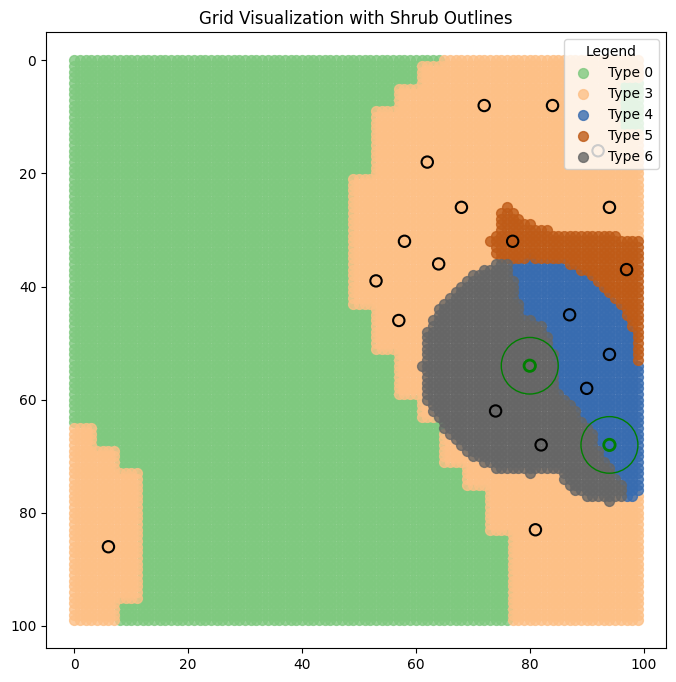

In [87]:
input_grid_y = initialise_things() # Please replace with  wx version and check that it workes with wx legend ( )
intermediate_grid_y, seed_list_y, trees_list_y = combined_v3(input_grid_y, starting_input, visualise=False)
output_grid_y, seed_dict_y = postprocessing(intermediate_grid_y, seed_list_y)

visualize_grid_with_outlines(output_grid_y, seed_dict_y, trees_list_y)

## Compiled Class Function

Things left to do:
- Make sure output is in json format
- Make sure the comments in the class are adjusted
- Add in mirroring if style is manicured

In [33]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import os
import copy
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import label
from scipy.stats import mode
import re

class gridHatching():
    def __init__(self, starting_grid:np.ndarray, starting_plant_dict: dict, randomised_seed: int = None, threshold: float = 0.1, fall_off: bool= False):
        """
        Class to take a grid and plant_selection in order to create hatches of regions 

        Args:
            grid (np.ndarray): grid received from procedural generation, 0 means unplantable, 1 means plantable, 2 means tree, 3 means shrub
            plant_dict (dict): the plant_dict and information on the theme as well
            threshold (float, optional): is the amount of difference between seed strength before one is dominannt
            fall_off (bool, optional): controls whether the influence from the depth of the area is bool (either 100 or 0 strength) or gradually decreases across distance 
        """
        self.randomized_seed = None
        self.threshold = 0.1
        self.fall_off = False
        self.theme = starting_plant_dict["theme"]
        self.grid_shape = (starting_grid.shape)

        self.unplantable_int = 0
        self.plantable_int = 1
        self.tree_int = 2
        self.shrub_int = 3
        
        
        self.tree_info_dict = None
        self.shrub_info_dict = None
        self.starting_seed_list = None
        self.shrub_int_list = None
        self.seed_mapping = None
        self.tree_radii_dict = None
        self.tree_id_dict = None
        
        self.starting_grid = starting_grid
        self.starting_plant_dict = starting_plant_dict

        self._initialise_info()

        # print("tree_info_dict")
        # print(self.tree_info_dict)
        # print("shrub_info_dict")
        # print(self.shrub_info_dict)
        # print("starting_seed_list")
        # print(self.starting_seed_list)
        # print("shrub_int_list")
        # print(self.shrub_int_list)
        # print("tree_id_dict")
        # print(self.tree_id_dict)
        # print("tree_radii_dict")
        # print(self.tree_radii_dict)
        # print("seed_mapping")
        # print(self.seed_mapping)

    def create_hatching(self, visualise=False):        
        intermediate_grid = self._generation()

        output_grid, output_seed_dict, seed_mapping = self._postprocessing(intermediate_grid)

        output_json = self._create_json(output_grid, output_seed_dict, seed_mapping)

        if visualise:
            self._visualize_grid_with_outlines_v2(output_grid, output_seed_dict, seed_mapping, self.tree_radii_dict)
        return output_json
    
    # Compiled Functions, not public but essentially the segments
    def _initialise_info(self):
        """
        Function used to initialise all the information before the grid generation

        Returns: 
            starting_seed_list (list[tuple]): a list of tuple of seed locations
            shrub_int_list (list): a list of integers to be used to populate the numpy array
            tree_radii_dict (dict): a dictionary of tuples of tree locations as the keys and radii of each tree as the value
        """ 
        trees_list, self.starting_seed_list = self._extract_tree_shrub_placements(self.starting_grid, tree_int=1, shrub_int=2) # to be replaced with xuan's numbers
        self.tree_info_dict, self.shrub_info_dict = self._retrive_trees_shrubs_from_input_dict(self.starting_plant_dict)
        new_trees = self._allocate_trees_to_coordinates(trees_list, self.tree_info_dict)
        self.tree_radii_dict = {pos: data[1] for pos, data in new_trees.items()}
        self.tree_id_dict = {pos: data[2] for pos, data in new_trees.items()}
        self.seed_mapping, self.shrub_int_list = self._create_seed_labels_v2(self.shrub_info_dict) 
    
    def _generation(self):
        """
        Function used to generate the raw heatmap before cleaning

        Returns: 
            output_grid (np.ndarray): the numpy array that has different regions labelled with different integers for different plants
        """ 
        seed_to_int_dict = self._choose_starter_slots_v3(self.starting_seed_list, self.seed_mapping) 
        noise_map = self._generate_worley_heatmap(distribution_seed=self.randomized_seed)
        noise_grids = self._combined_noisemap(self.grid_shape, noise_map, seed_to_int_dict) 
        heatmaps = self._create_heatmaps_v2(self.shrub_int_list , self.starting_grid, noise_grids, self.tree_radii_dict, self.fall_off) # This function can also be cleaned up bcos wx technically already has plantable and unplantable area segmented out so it does not need to be further subdivided
        output_grid = self._apply_influence_grids_with_border(heatmaps, self.starting_grid, threshold=self.threshold)
        return output_grid
    
    def _postprocessing(self, intermediate_grid):
        """
        Function used to generate the raw heatmap before cleaning

        Returns: 
            cleaned_grid (np.ndarray): the numpy array that has different regions labelled with different integers for different plants
            seed_dict (dict): a dictionary of integers of the selected regions as the keys and list of tuples of their locations as the value output.
        """ 
        cleaned_grid = self._fill_small_regions(intermediate_grid, required_points=self.starting_seed_list)
        seed_dict = self._sort_seeds_v2(cleaned_grid, self.starting_seed_list)
        shifted_seeds_dict = self._shift_and_space_seeds_optimized(cleaned_grid, seed_dict)
        cleaned_grid = self._merge_regions_without_seeds(cleaned_grid,shifted_seeds_dict)

        if self.theme == "manicured":
            cleaned_grid, shifted_seeds_dict, mirrored_trees, _ = self._mirror_grid(cleaned_grid, shifted_seeds_dict, self.tree_radii_dict)
            self.tree_radii_dict = mirrored_trees

        seed_mapping = {seed["Seed Number"]: seed["Shrub Name"] for seed in self.seed_mapping}

        return cleaned_grid, shifted_seeds_dict, seed_mapping
    

    # Everything below this line is just to check if it works first
    # to be commented and cleaned according to comments later
    
    def _extract_tree_shrub_placements(self, grid, tree_int = 1, shrub_int = 2): # to change to 2 and 3 when using wx grid
        """
        Extracts the tree and shrub placements from the grid.
        
        Args:
            grid (np.ndarray): The grid with placement of trees and shrubs.
        
        Returns:
            trees (list of tuple): List of coordinates of tree placements.
            shrubs (list of tuple): List of coordinates of shrub placements.
        """
        trees = list(zip(*np.where(grid == 1)))
        shrubs = list(zip(*np.where(grid == 2)))
        return trees, shrubs#
    
    def _retrive_trees_shrubs_from_input_dict(self, input_dict):
        """
        Parses through the input that is received from the previous function, the dict, and separates the plants in the selected plants list into shrubs and trees
        
        Args:
            input_dict (dict): The dictionary with the input values, where the list of info on the plants can be found in input dict["selected plants"]
        
        Returns:
            Tree_Species (list of dict): List of containing the dictionaries of each tree
            Shrub_Species (list of dict): List of containing the dictionaries of each shrub
        """
        Tree_Species = []
        Shrub_Species = []
        selected_plants_list = input_dict["selected_plants"]
        for plant in selected_plants_list:
            if self._contains_palm(plant["Plant Type"]) or self._contains_tree(plant["Plant Type"]):
                # It is a tree
                Tree_Species.append(plant)
            elif self._contains_shrub(plant["Plant Type"]):
                Shrub_Species.append(plant)
            else:
                print("WHATT ARE THOSEE")
                continue
        return Tree_Species,Shrub_Species
    
    def _allocate_trees_to_coordinates(self, tree_positions, Trees_list):
        """
        Allocates a tree species and its radius to each coordinate from the given tree list.

        Args:
            tree_positions (list of tuple): List of (y, x) grid coordinates.
            Trees_list (list of dict): List of tree data with species name and canopy radius.

        Returns:
            dict: A dictionary mapping each coordinate to a tree species and its radius.
        """
        # Check if there are any tree species
        if not Trees_list:
            raise ValueError("No tree species available in the tree list.")

        # Initialize the output dictionary
        allocated_trees = {}

        # Assign each coordinate a tree species and radius
        for pos in tree_positions:
            # Randomly select a tree species
            selected_tree = random.choice(Trees_list)
            name = selected_tree["Species Name"]
            radius = selected_tree.get("Canopy Radius", "None")
            id = selected_tree.get("Species ID")
            
            # Ensure radius is a float if possible
            radius = float(radius) if radius != "None" else 0
            
            # Allocate the tree to the coordinate
            allocated_trees[pos] = [name, radius, id]

        return allocated_trees
    
    def _create_seed_labels_v2(self, shrubs_list):
        """
        Categorises shrubs based on their light preferences and border proximity, 
        assigns seed numbers to each shrub, and returns the seed mappings.

        Shrubs are divided into the following categories:
        - BSH: Border, Shade Hating
        - NBSL: Not Border, Shade Loving
        - NBSH: Not Border, Shade Hating
        - BSL: Border, Shade Loving

        Seed numbers are generated uniquely for each category based on conditions, ensuring no overlap.

        Args:
            shrubs_list (list): A list of dictionaries representing shrubs. Each dictionary contains:
                - "Plant Type" (str): Type of the plant (e.g., "Shrub").
                - "Light Preference" (str): Light preference (e.g., "Full Shade", "Semi Shade").
                - "Hazard" (str): Whether the shrub is on the border ("-" indicates it's on the border).
                - "Species Name" (str): Name of the shrub species.

        Returns:
            - seed_mapping (list of dict): A list of dictionaries where each dictionary represents a shrub with:
                - "Seed Number" (int): The assigned seed number.
                - "Shrub Name" (str): The species name of the shrub.
            - seeds_list (list of int): A list of all seed numbers assigned to shrubs.
        """
        BSH = 0  # Border, Shade Hating
        NBSL = 0  # Not Border, Shade Loving
        NBSH = 0  # Not Border, Shade Hating
        BSL = 0  # Border, Shade Loving
        shrub_mapping = {  # To map seeds to shrub names
            "BSH": [],
            "NBSL": [],
            "NBSH": [],
            "BSL": []
        }

        # Process each shrub and categorize
        for shrub in shrubs_list:
            if "Shrub" in shrub["Plant Type"]:  # Ensure it's a shrub
                if shrub["Hazard"] != "-":  # NB: Not Border (hazard present)
                    if self._contains_semi_shade_jx(shrub["Light Preference"]) or self._contains_full_shade_jx(shrub["Light Preference"]):
                        # NBSL: Not Border, Shade Loving
                        NBSL += 1
                        shrub_mapping["NBSL"].append(shrub["Species Name"])
                    else:
                        # NBSH: Not Border, Shade Hating
                        NBSH += 1
                        shrub_mapping["NBSH"].append(shrub["Species Name"])
                else:  # B: Border (no hazard)
                    if self._contains_semi_shade_jx(shrub["Light Preference"]) or self._contains_full_shade_jx(shrub["Light Preference"]):
                        # BSL: Border, Shade Loving
                        BSL += 1
                        shrub_mapping["BSL"].append(shrub["Species Name"])
                    else:
                        # BSH: Border, Shade Hating
                        BSH += 1
                        shrub_mapping["BSH"].append(shrub["Species Name"])

        # Generate seed numbers for the categories
        seedlists = self._select_numbers(startingNumber=3, BSH=BSH, NBSL=NBSL, BSL=BSL, NBSH=NBSH)

        # Map seed numbers to shrubs
        seed_mapping = []
        seeds_list = []
        for category in ["BSH", "NBSL", "NBSH", "BSL"]:
            seeds = seedlists[category]
            names = shrub_mapping[category]
            for seed, name in zip(seeds, names):
                seed_mapping.append({"Seed Number": seed, "Shrub Name": name})
                seeds_list.append(seed)

        return seed_mapping, seeds_list

    def _select_numbers(self, BSH=0, NBSL=0, NBSH=0, BSL=0, startingNumber=3):
        """
        Selects integers for each category based on the specified conditions:
        - BSH: Border, shade hating (not a multiple of 2, multiple of 3)
        - NBSL: Not Border, shade loving (multiple of 2, not a multiple of 3)
        - NBSH: Not Border, shade hating (not a multiple of 2, not a multiple of 3)
        - BSL: Border, shade loving (multiple of 2, multiple of 3)

        Args:
            BSH (int): Number of integers required for Border, shade hating condition.
            NBSL (int): Number of integers required for Not Border, shade loving condition.
            NBSH (int): Number of integers required for Not Border, shade hating condition.
            BSL (int): Number of integers required for Border, shade loving condition.
            startingNumber (int): The number to start iterating from.

        Returns:
            dict: A dictionary with keys 'BSH', 'NBSL', 'NBSH', 'BSL' and lists of integers as values.
        """
        result = {"BSH": [], "NBSL": [], "NBSH": [], "BSL": []}
        current_number = startingNumber

        while len(result["BSH"]) < BSH or len(result["NBSL"]) < NBSL or len(result["NBSH"]) < NBSH or len(result["BSL"]) < BSL:
            if current_number % 2 != 0 and current_number % 3 == 0 and len(result["BSH"]) < BSH:
                result["BSH"].append(current_number)
            elif current_number % 2 == 0 and current_number % 3 != 0 and len(result["NBSL"]) < NBSL:
                result["NBSL"].append(current_number)
            elif current_number % 2 != 0 and current_number % 3 != 0 and len(result["NBSH"]) < NBSH:
                result["NBSH"].append(current_number)
            elif current_number % 2 == 0 and current_number % 3 == 0 and len(result["BSL"]) < BSL:
                result["BSL"].append(current_number)
            
            current_number += 1

        return result

    def _choose_starter_slots_v3(self, shrub_positions, starter_types, percentage_of_starters=0.8):
        """
        Selects a percentage of shrub positions to be assigned as starter slots and groups them
        by starter types based on the provided list.

        Args:
            shrub_positions (list): List of tuples representing the positions of shrubs.
            starter_types (list): List of dictionaries with "Seed Number" and optionally other fields.
            percentage_of_starters (float): Percentage of shrub positions to use as starter slots. Default is 0.8 (80%).

        Returns:
            dict: A dictionary of seed locations by type.
        """
        shrub_slots = copy.deepcopy(shrub_positions)
        
        # Use only the "Seed Number" from starter_types for seed_locations keys
        seed_locations = {t["Seed Number"]: [] for t in starter_types}

        # Determine the number of starters based on the percentage
        number_of_starters = int(len(shrub_slots) * percentage_of_starters)
        number_of_starters = max(1, number_of_starters)  # Ensure at least one starter is selected

        # Use the provided list of starter types in sequence
        types_sequence = [starter_types[i % len(starter_types)]["Seed Number"] for i in range(number_of_starters)]

        for i, assigned_type in enumerate(types_sequence):
            if not shrub_slots:  # If no more shrub positions are left, break the loop
                break
            selected_position = shrub_slots.pop(0)  # Select the next shrub position in order
            seed_locations[assigned_type].append(selected_position)

        return seed_locations

    def _generate_worley_heatmap(self, grid_size=(100, 100), distribution_seed=None, value_range=(40, 50), feature_points=20, invert=False): 
        """
        Generate a random heatmap using Worley noise.

        Args:
            grid_size (tuple): The size of the heatmap (width, height).
            distribution_seed (int or None): Seed for reproducibility.
            value_range (tuple): The range of values for the heatmap (min, max).
            feature_points (int): Number of feature points in the grid.
            invert (bool): Whether to invert the values so that centers of the points are high-value areas.

        Returns:
            np.ndarray: A 2D array representing Worley noise.
        """
        width, height = grid_size

        # Set random seed for reproducibility
        if distribution_seed is not None:
            random.seed(distribution_seed)

        # Generate random feature points
        feature_points = [(random.uniform(0, width), random.uniform(0, height)) for _ in range(feature_points)]

        def closest_distance(x, y):
            # Compute the closest distance to a feature point
            return min(np.sqrt((x - fx) ** 2 + (y - fy) ** 2) for fx, fy in feature_points)

        # Compute Worley noise for the grid
        noise = np.array([[closest_distance(x, y) for x in range(width)] for y in range(height)])

        # Normalize the noise to 0-1
        noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))

        # Invert the noise if required
        if invert:
            noise = 1 - noise

        # Scale the noise to the desired value range
        min_val, max_val = value_range
        noise = noise * (max_val - min_val) + min_val

        return noise

    def _combined_noisemap(self, grid_shape, noise_map, seed_dict): 
        """
        Combines the influence of multiple seed groups onto a noise map and returns 
        the influence grids for each seed group.

        This function applies the `_radiate_influence` method for each seed group in 
        `seed_dict`, generating an influence grid for each group based on the input 
        grid shape, noise map, and seed locations.

        Args:
            grid_shape (tuple): The shape of the grid (height, width) for generating the influence map.
            noise_map (np.ndarray): A 2D array representing noise values used to calculate influence.
            seed_dict (dict): A dictionary where keys are seed group identifiers (e.g., types of seeds),
                            and values are lists of seed positions [(y1, x1), (y2, x2), ...].

        Returns:
            dict: A dictionary where keys are seed group identifiers and values are 2D influence grids
                (np.ndarray) generated for each seed group.
        """
        seed = {}
        for i in seed_dict:
            seed[i] = self._radiate_influence(grid_shape, noise_map, seed_dict[i])
        return seed

    def _radiate_influence(self, grid_shape, noise_map, seed_locations, decay_rate=0.1):
        """
        Radiates influence from each seed location based on its strength on the noise map, taking the maximum influence.

        Args:
            grid (np.ndarray): The input grid where influence will be applied.
            noise_map (np.ndarray): A grid representing the noise values.
            seed_locations (list of tuple): List of (y, x) seed coordinates.
            decay_rate (float): The rate at which influence decreases with distance.

        Returns:
            np.ndarray: A grid with the maximum influence from all seeds.
        """
        # Get grid dimensions
        height, width = grid_shape

        # Initialize the influence grid with zeros
        influence_grid = np.zeros((height, width), dtype=np.float32)

        # Iterate over each seed
        for y, x in seed_locations:
            # Get the seed's strength from the noise map
            if 0 <= y < height and 0 <= x < width:
                seed_strength = noise_map[y, x]

                # Iterate over the grid to calculate influence
                for i in range(height):
                    for j in range(width):
                        # Calculate the distance from the seed
                        distance = np.sqrt((i - y) ** 2 + (j - x) ** 2)

                        # Calculate the influence based on the distance
                        influence = seed_strength * np.exp(-decay_rate * distance)

                        # Assign the maximum influence to the grid
                        influence_grid[i, j] = max(influence_grid[i, j], influence)

        influence_grid = np.flipud(influence_grid)

        return influence_grid
   
    def _create_heatmaps_v2(self, seed_list, grid, noise_grids, tree_radii, fall_off= False): #This function can also be cleaned up bcos wx technically already has plantable and unplantable area segmented out so it does not need to be further subdivided
        """
        Generates heatmaps for each seed type based on noise grids and tree radii.

        This function iterates over a list of seed types, creating a heatmap for each type 
        by leveraging `_create_heatmap_for_type_v2`. It uses the provided grid and noise grids 
        and applies tree radius and optional fall-off parameters.

        Note:
            If the grid already segments plantable and unplantable areas, further subdivision 
            within this function is unnecessary, making it possible to simplify its logic.

        Args:
            seed_list (list): A list of seed types (e.g., seed identifiers or categories).
            grid (np.ndarray): A 2D array representing the overall grid environment.
            noise_grids (dict): A dictionary where keys are seed types and values are noise grids 
                                (np.ndarray) corresponding to each seed type.
            tree_radii (dict): A dictionary mapping each seed type to its associated tree radius.
            fall_off (bool, optional): If True, applies a fall-off effect in the heatmap calculation. 
                                    Default is False.

        Returns:
            dict: A dictionary where keys are seed types and values are their corresponding heatmaps 
                (np.ndarray) generated based on the input parameters.
        """
        seed_heatmaps = {}
        for i in seed_list:
            seed_heatmaps[i] = self._create_heatmap_for_type_v2(i,grid, noise_grids[i], tree_radii =tree_radii, fall_off=fall_off)
        return seed_heatmaps

    def _create_heatmap_for_type_v2(self, seed_value, grid, noise_grid, tree_radii, fall_off=False):
        """
        Generates a combined heatmap for a specific seed type by considering shade preferences, 
        border proximity, and noise influences.

        This function creates and combines multiple heatmaps:
        - Shade heatmap based on tree radii and the seed's shade preference.
        - Border proximity heatmap based on whether the seed prefers the border.
        - Noise grid as an external influence.

        Args:
            seed_value (int): The value representing the seed type, used to determine preferences:
                            - Multiple of 2: Shade-loving.
                            - Not a multiple of 2: Shade-hating.
                            - Multiple of 3: Border-loving.
                            - Not a multiple of 3: Not border-loving.
            grid (np.ndarray): The 2D array representing the overall grid environment.
            noise_grid (np.ndarray): A noise grid specific to the seed type, influencing the heatmap.
            tree_radii (dict): A dictionary mapping seed types to their associated tree radii.
            fall_off (bool, optional): If True, applies an instant fall-off effect to border calculations. 
                                    Default is False.

        Returns:
            np.ndarray: A combined heatmap that integrates shade preferences, border proximity, 
                        and noise influences for the given seed type.
        """
        plantable_grid = self._shade_inside_border(grid)
        # Create the grids to be combined
        shade_grid = None
        # If the thing is a multiple of 2 then it is shade loving
        if seed_value%2 == 0:
            shade_grid = self._label_heatmap_based_on_trees_v2(plantable_grid,tree_radii)
        else:
            shade_grid = self._label_heatmap_based_on_trees_v2(plantable_grid, tree_radii, invert=True)
        # visualize_heatmap(shade_grid)
        border_grid = None
        # If the seed_value is a modulus of 3 then it is something that likes the border
        if seed_value%3 ==0:
            border_grid = self._calculate_border_proximity(plantable_grid, instant_fall_off=fall_off)
        else:
            border_grid = self._calculate_distance_to_border(plantable_grid, instant_fall_off=fall_off)
        
        # visualize_heatmap(shade_grid)
        # visualize_heatmap(border_grid)
        influences = [shade_grid,border_grid, noise_grid]
        influence = self._combine_heatmaps(influences)
        # visualize_heatmap(influence)
        return influence

    def _shade_inside_border(self, grid, border_value=255, fill_value=128):
        """
        Shade points inside the black borders on the grid with a specified fill color,
        leaving outside regions untouched.

        Args:
            grid (np.ndarray): The grid representing the environment.
            border_value (int): Value representing the border in the grid.
            fill_value (int): Value to fill the inside regions with.

        Returns:
            np.ndarray: Modified grid with inside regions shaded with the fill color.
        """
        # Create a mask for border areas
        border_mask = grid == border_value

        # Use binary_fill_holes to fill regions inside the border
        filled_region = binary_fill_holes(border_mask)

        # Create a copy of the grid to modify
        shaded_grid = np.copy(grid)
        
        # Apply the fill color to inside regions only
        shaded_grid[filled_region] = fill_value
        # plt.imshow(shaded_grid, cmap="gray")
        # plt.title("Grid with Inside Regions Shaded")
        # plt.show()
        
        return shaded_grid

    def _label_heatmap_based_on_trees_v2(self, grid, tree_data, invert=False):
        """
        Creates a new grid where points with a value of 128 are labeled with 100 or 0 
        based on their proximity to trees. Each tree has a specific radius for labeling.
        Points within or outside the radius are labeled, depending on `invert`.

        Args:
            grid (np.ndarray): The input grid (heatmap values or similar structure).
            tree_data (dict): Dictionary with (y, x) coordinates as keys and radius as values.
            invert (bool): If True, label points outside the radius of all trees instead of within it.

        Returns:
            np.ndarray: A new grid where desired squares are labeled as 100, others as 0.
        """
        visualize_heatmap(grid)
        # Initialize the new grid with zeros
        labeled_grid = np.zeros_like(grid, dtype=np.float32)

        # Identify positions with a value of 128 in the grid
        target_positions = np.argwhere(grid == 128)

        # If there are tree positions and target positions, calculate distances
        if len(tree_data) > 0 and len(target_positions) > 0:
            # Extract tree positions and radii
            tree_positions = np.array(list(tree_data.keys()))
            tree_radii = np.array(list(tree_data.values()))

            # Calculate distances from target positions to the tree positions
            distances = cdist(target_positions, tree_positions)

            if invert:
                # Label points outside the radius of ALL trees
                outside_all_trees = np.all(distances > tree_radii, axis=1)
                valid_indices = np.where(outside_all_trees)[0]
            else:
                # Label points within the radius of ANY tree
                within_any_tree = np.any(distances <= tree_radii, axis=1)
                valid_indices = np.where(within_any_tree)[0]

            # Mark valid target points in the labeled grid
            for index in valid_indices:
                y, x = target_positions[index]
                labeled_grid[y, x] = 100  # Assign the value 100 for valid points

            labeled_grid = np.flipud(labeled_grid)

        return labeled_grid

    def _calculate_border_proximity(self, grid, constant_zone=0.6, instant_fall_off=False):
        """
        Calculate a proximity map where pixels of type 128 closest to the border have the highest value.
        Type 0 remains 0. Includes a cutoff value to ignore distances below the cutoff threshold,
        a max_cutoff to cap the proximity effect, and a constant_zone where the score remains 100.
        Supports an instant fall-off mode where values less than 100 are set to 0.

        Args:
            grid (np.ndarray): 2D array where 128 represents the target area.
            cutoff (float): The minimum distance value to consider. Distances below this are set to 0.
            max_cutoff (float or percentage): The maximum distance value to cap. If between 0 and 1, treated as a percentage.
            constant_zone (float or percentage): The distance from the border where the proximity value remains 100.
                                                If between 0 and 1, treated as a percentage.
            instant_fall_off (bool): If True, values less than 100 are set to 0.

        Returns:
            np.ndarray: A 2D array where proximity to the border is higher for points closer to the border.
        """
        cutoff = 1
        max_cutoff = 1
        # Create a binary mask where type 128 is 1 and everything else is 0
        binary_mask = (grid == 128).astype(np.uint8)

        # Apply distance transform
        distance_to_border = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

        # Calculate max_distance for normalization and percentage-based calculations
        max_distance = np.max(distance_to_border)

        # Convert constant_zone and max_cutoff to absolute values if they are percentages
        if 0 < constant_zone <= 1:
            constant_zone = constant_zone * max_distance
        if 0 < max_cutoff <= 1:
            max_cutoff = max_cutoff * max_distance

        # Maintain a constant value of 100 in the constant zone
        proximity_map = np.zeros_like(distance_to_border)
        proximity_map[distance_to_border <= constant_zone] = 100

        # Normalize the distances beyond the constant zone
        beyond_constant_zone = distance_to_border > constant_zone
        if max_distance > 0:
            normalized_distances = (distance_to_border[beyond_constant_zone] - constant_zone) / (max_distance - constant_zone)
            proximity_map[beyond_constant_zone] = (1 - normalized_distances) * 100

        # Apply cutoff to remove low-proximity regions
        proximity_map = np.where(distance_to_border >= cutoff, proximity_map, 0)

        # Handle instant fall-off: Set all values less than 100 to 0
        if instant_fall_off:
            proximity_map = np.where(proximity_map == 100, 100, 0)
        else:
            # Apply max_cutoff to limit the proximity range
            if max_cutoff is not None:
                proximity_map = np.where(distance_to_border <= max_cutoff, proximity_map, 0)

        # Flip the proximity map vertically
        flipped_proximity_map = np.flipud(proximity_map)

        return flipped_proximity_map

    def _calculate_distance_to_border(self, grid, cutoff=1, max_area=0.4, instant_fall_off=False):
        """
        Calculate and normalize the distance of each pixel to the nearest border of the area with type 128.
        Includes a cutoff value to ignore distances below the cutoff threshold and a max_area to cap the proximity.
        Allows max_area to specify the portion of the grid covered.
        Supports an instant fall-off mode where values drop to 0 beyond the max_area range.

        Args:
            grid (np.ndarray): 2D array where 128 represents the target area.
            cutoff (float): The minimum distance value before starting to increase. Default is 1.
            max_area (float): The portion of the grid where proximity should remain non-zero. If between 0 and 1, treated as a percentage.
            instant_fall_off (bool): If True, values beyond max_area are set to 0 immediately.

        Returns:
            np.ndarray: A 2D array of the same shape as the input, containing normalized distances.
        """
        # Create a binary mask where type 128 is 1 and everything else is 0
        max_cutoff = 1 - max_area
        binary_mask = (grid == 128).astype(np.uint8)

        # Apply distance transform
        distance_to_border = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

        # Apply cutoff
        distance_to_border = np.where(distance_to_border >= cutoff, distance_to_border, 0)

        # Convert max_cutoff to an absolute value if it's a percentage (0 < max_cutoff <= 1)
        max_distance = np.max(distance_to_border)
        if 0 < max_cutoff <= 1:  # If max_cutoff is a percentage
            max_cutoff = max_cutoff * max_distance

        # Set values at max_cutoff to 100 and normalize the gradient
        distance_to_border = np.clip(distance_to_border, 0, max_cutoff)  # Cap at max_cutoff
        if max_cutoff > 0:
            normalized_distance_map = (distance_to_border / max_cutoff) * 100  # Scale to range [0, 100]

        # Set values that hit max_cutoff to exactly 100
        normalized_distance_map[distance_to_border == max_cutoff] = 100

        # Handle instant fall-off: Retain yellow zones (100) and remove all other gradients
        if instant_fall_off:
            normalized_distance_map = np.where(normalized_distance_map == 100, 100, 0)

        # Flip the distance map vertically
        flipped_distance_map = np.flipud(normalized_distance_map)

        return flipped_distance_map

    def _combine_heatmaps(self, heatmaps):
        """
        Combine multiple heatmaps into a single heatmap by summing them element-wise.

        Args:
            heatmaps (list of np.ndarray): List of 2D heatmaps to combine.

        Returns:
            np.ndarray: Combined heatmap with the same shape as the input heatmaps.
        """
        if not heatmaps:
            raise ValueError("The list of heatmaps is empty.")
        
        # Ensure all heatmaps have the same shape
        shape = heatmaps[0].shape
        for idx, h in enumerate(heatmaps):
            if h.shape != shape:
                print(f"Heatmap at index {idx} has shape {h.shape}, expected {shape}")
                raise ValueError("All heatmaps must have the same shape.")
        
        # Sum the heatmaps element-wise
        combined = sum(heatmaps)
        
        return combined

    def _apply_influence_grids_with_border(self, influence_grids, grid, threshold=1):
        """
        Apply influence grids to assign plant types based on influences while respecting the border constraints.
        Correct the vertical flip issue by flipping the grid as needed.

        Args:
            influence_grids (dict): A dictionary of influence grids for each plant type.
            grid (np.ndarray): Original grid to determine workable spots.
            threshold (float): The maximum absolute difference between influences to trigger random selection.

        Returns:
            np.ndarray: A grid with plant types assigned based on influence grids, keeping non-workable spots untouched.
        """
        # Identify workable spots using shade_inside_border
        workable_grid = self._shade_inside_border(grid)
        
        # Flip grids vertically to address the issue
        flipped_influence_grids = {
            plant_type: np.flipud(influence_grids[plant_type])
            for plant_type in influence_grids
        }
        
        grid_shape = workable_grid.shape

        # Initialize the assigned grid with zeros
        assigned_grid = np.zeros(grid_shape, dtype=int)

        # Iterate through each cell in the grid
        for i in range(grid_shape[0]):
            for j in range(grid_shape[1]):
                if workable_grid[i, j] == 128:  # Only consider workable spots
                    # Gather influences for all plant types at this position
                    influences = [
                        (flipped_influence_grids[plant_type][i, j], plant_type)
                        for plant_type in flipped_influence_grids
                    ]

                    # Sort influence values with their corresponding types
                    influences.sort(reverse=True, key=lambda x: x[0])  # Sort by influence value

                    # Decide based on the absolute threshold
                    if len(influences) > 1 and abs(influences[0][0] - influences[1][0]) <= threshold:
                        # Randomly select between the top two types
                        assigned_type = random.choice([influences[0][1], influences[1][1]])
                    else:
                        # Select the type with the highest influence
                        assigned_type = influences[0][1]

                    # Assign the type to the corresponding cell
                    assigned_grid[i, j] = assigned_type
                else:
                    # Retain the original value for non-workable spots (e.g., 0)
                    assigned_grid[i, j] = grid[i, j]

        return assigned_grid

    def _fill_small_regions(self, grid, min_size=50, required_points=[]):
        """
        Replace small patches (connected components) in a grid with surrounding tile values.
        Additionally, replace regions that do not contain at least one required point.

        Args:
            grid (np.ndarray): The input 2D grid with integer values (e.g., 3 and above for regions).
            min_size (int): The minimum size for a region to remain unchanged.
            required_points (list of tuple): List of (y, x) coordinates. Regions missing these points will be replaced.

        Returns:
            np.ndarray: A grid with small regions filled with surrounding tile values.
        """
        # Create a copy of the grid to modify
        cleaned_grid = np.copy(grid)
        
        # Identify unique region values (starting from 3)
        unique_values = np.unique(grid[grid >= 3])  # Ignore values less than 3
        
        # Iterate over unique values in the grid
        for value in unique_values:
            # Create a mask for the current region
            mask = (grid == value)
            
            # Label connected components within the mask
            labeled_mask, num_features = label(mask)
            
            # Iterate over connected components
            for region_label in range(1, num_features + 1):
                # Extract the region
                region_mask = (labeled_mask == region_label)
                region_size = np.sum(region_mask)
                region_coords = np.argwhere(region_mask)

                # Check if the region contains at least one required point
                contains_required_point = any(tuple(coord) in required_points for coord in region_coords)

                # If the region size is smaller than the threshold or does not contain a required point
                if region_size < min_size or not contains_required_point:
                    # Collect surrounding values for all pixels in the region
                    surrounding_values = []
                    for y, x in region_coords:
                        # Check all 8 neighbors
                        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            ny, nx = y + dy, x + dx
                            if 0 <= ny < grid.shape[0] and 0 <= nx < grid.shape[1]:  # Check bounds
                                neighbor_value = cleaned_grid[ny, nx]
                                surrounding_values.append(neighbor_value)
                    
                    # Determine the most frequent surrounding value
                    values = {}
                    for x in surrounding_values:
                        if x not in values:
                            values[x] = 1
                        else:
                            values[x] += 1

                    replacement_value = None
                    while replacement_value is None:
                        replacement_value = max(values, key=values.get)
                        if replacement_value == 0:
                            replacement_value = None
                            values.pop(max(values, key=values.get), None)

                    # Replace the small region or region without required points
                    cleaned_grid[region_mask] = replacement_value

        return cleaned_grid
   
    def _sort_seeds_v2(self, grid, seeds):
        """
        Sorts the seeds based on their corresponding values on a grid.

        Args:
            grid (np.ndarray): A 2D numpy array representing the grid.
            seeds (list of tuples): A list of (x, y) coordinate tuples.

        Returns:
            dict: A dictionary where keys are grid values and values are lists of coordinates.
        """
        sorted_seeds = {}

        for y, x in seeds:
            # Get the value at the grid position
            value = grid[y, x]  # Note: grid indexing is row-major (y, x)

            # Add the coordinate to the appropriate list in the dictionary
            if value not in sorted_seeds:
                sorted_seeds[value] = []
            sorted_seeds[value].append((y, x))

        sorted_seeds = dict(sorted(sorted_seeds.items()))
        return sorted_seeds

    def _shift_and_space_seeds_optimized(self, input_grid, seed_dict_x, min_distance=5, spacing_distance=7, max_iterations=100):
        """
        Optimized version to shift seeds inward and ensure they are spaced out within regions.
        Includes timeout for both boundary adjustment and spacing adjustments.

        Args:
            input_grid (np.ndarray): A numpy grid representing the different areas.
            seed_dict_x (dict): A dictionary with keys as area types and values as lists of (y, x) coordinates of seeds.
            min_distance (float): The minimum distance a seed must maintain from the boundary.
            spacing_distance (float): The minimum distance seeds must maintain from each other.
            max_iterations (int): Maximum number of iterations to try for adjusting seed spacing.

        Returns:
            dict: Updated seed_dict_x with seeds shifted inward and spaced out within regions.
        """
        for area_type, seeds in seed_dict_x.items():
            # Create a binary mask for the current area type
            binary_mask = (input_grid == area_type).astype(np.uint8)

            # Apply distance transform to get distances from the boundary
            distance_to_boundary = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

            # Step 1: Shift seeds inward until they meet the minimum distance from the boundary
            shifted_seeds = []
            for seed in seeds:
                y, x = seed
                steps = 0  # Timeout counter for boundary adjustment

                while distance_to_boundary[y, x] < min_distance and steps < min_distance:
                    best_shift = None
                    max_distance = 0

                    # Check all 8 neighbors to find the best inward shift
                    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                            if (
                                input_grid[ny, nx] == area_type
                                and distance_to_boundary[ny, nx] > max_distance
                            ):
                                max_distance = distance_to_boundary[ny, nx]
                                best_shift = (ny, nx)

                    # If a better position is found, shift the seed
                    if best_shift:
                        y, x = best_shift
                    else:
                        # If no valid shift is possible, stop the loop
                        break

                    steps += 1  # Increment the timeout counter

                shifted_seeds.append((y, x))

            # Step 2: Adjust seeds iteratively to improve spacing
            placed_seeds = []
            for seed in shifted_seeds:
                y, x = seed
                iterations = 0  # Timeout counter for spacing adjustment

                # Iterate to adjust until spacing is achieved or timeout is reached
                while iterations < max_iterations:
                    is_spaced = all(
                        np.sqrt((y - py) ** 2 + (x - px) ** 2) >= spacing_distance
                        for py, px in placed_seeds
                    )
                    if is_spaced:
                        break

                    best_shift = None
                    max_spacing = 0

                    # Check all 8 neighbors to find the best shift to improve spacing
                    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                            if input_grid[ny, nx] == area_type:
                                # Calculate the minimum distance to all placed seeds
                                distances = [
                                    np.sqrt((ny - py) ** 2 + (nx - px) ** 2) for py, px in placed_seeds
                                ]
                                min_spacing = min(distances) if distances else float("inf")
                                if min_spacing > max_spacing:
                                    max_spacing = min_spacing
                                    best_shift = (ny, nx)

                    # If a better position is found, shift the seed
                    if best_shift:
                        y, x = best_shift
                    else:
                        # If no valid shift is possible, stop adjusting
                        break

                    iterations += 1  # Increment the timeout counter

                placed_seeds.append((y, x))

            # Update the seed positions in seed_dict_x
            seed_dict_x[area_type] = placed_seeds

        return seed_dict_x
    
    def _merge_regions_without_seeds(self, input_grid, seed_dict_x, visualise=False):
        """
        Merge regions without any seeds into neighboring regions, separating regions by boundaries and region types.

        Args:
            input_grid (np.ndarray): A numpy grid representing different regions by type.
            seed_dict_x (dict): A dictionary with keys as region types and values as lists of seed coordinates.

        Returns:
            np.ndarray: A modified grid where regions without seeds are merged into neighboring regions.
        """
        # Step 1: Label each type separately and assign unique labels
        labeled_grid = np.zeros_like(input_grid, dtype=int)
        current_label = 1  # Start labeling from 1
        region_type_to_labels = {}  # Keep track of which labels belong to which region type

        for region_type in np.unique(input_grid):
            if region_type == 0:  # Skip unplantable areas
                continue

            # Label regions for the current type
            type_mask = (input_grid == region_type).astype(int)
            labeled_type, num_features = label(type_mask)

            # Assign unique labels for this type
            for feature_id in range(1, num_features + 1):
                labeled_grid[labeled_type == feature_id] = current_label
                if region_type not in region_type_to_labels:
                    region_type_to_labels[region_type] = []
                region_type_to_labels[region_type].append(current_label)
                current_label += 1

        if visualise == True:
            # Visualization after Step 1: Display labeled regions
            plt.figure(figsize=(8, 8))
            plt.imshow(labeled_grid, cmap="tab20", origin="upper")
            plt.colorbar(label="Region Label")
            for region_type, seeds in seed_dict_x.items():
                for y, x in seeds:
                    plt.scatter(x, y, c="red", label=f"Type {region_type}" if y == seeds[0][0] else "", s=100, edgecolors="black")
            plt.title("Labeled Regions with Seeds")
            plt.xlabel("X-axis")
            plt.ylabel("Y-axis")
            plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
            plt.show()

        # Step 2: Check regions for seeds
        regions_with_seeds = set()
        for region_type, seeds in seed_dict_x.items():
            for seed in seeds:
                y, x = seed
                region_label = labeled_grid[y, x]
                regions_with_seeds.add(region_label)

        # Step 3: Merge regions without seeds into neighboring regions
        for region_label in np.unique(labeled_grid):
            if region_label == 0 or region_label in regions_with_seeds:
                continue

            # Get coordinates of the seedless region
            region_coords = np.argwhere(labeled_grid == region_label)

            # Find neighboring regions
            neighbors = {}
            for y, x in region_coords:
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                        neighbor_label = labeled_grid[ny, nx]
                        if neighbor_label > 0 and neighbor_label != region_label:
                            neighbors[neighbor_label] = neighbors.get(neighbor_label, 0) + 1

            # Merge into the most common neighboring region
            if neighbors:
                largest_neighbor = max(neighbors, key=neighbors.get)
                for y, x in region_coords:
                    labeled_grid[y, x] = largest_neighbor

        # Step 4: Map back to original region types
        merged_grid = np.zeros_like(input_grid)
        for region_type, label_list in region_type_to_labels.items():
            for label_id in label_list:
                merged_grid[labeled_grid == label_id] = region_type

        return merged_grid
    
    def _visualize_grid_with_outlines_v2(self, grid, shrubs_dict, seed_name_mapping, tree_radii):
        """
        Visualize a grid with different types and draw outlines for specific points from a dictionary of shrubs.

        Args:
            grid (np.ndarray): 2D array representing the grid. Each cell value corresponds to a type.
            shrubs_dict (dict): Dictionary where keys are types (seed numbers) and values are lists of (y, x) positions.
            seed_name_mapping (dict): Dictionary mapping seed numbers to shrub names.
            tree_radii (dict): Dictionary mapping (y, x) positions to radii.
        """
        # Define a colormap for visualization
        unique_values = np.unique(grid)
        colors = plt.cm.Accent(np.linspace(0, 1, len(unique_values)))  # Use a colormap for distinct colors

        # Create a color map dictionary
        color_map = {val: colors[i] for i, val in enumerate(unique_values)}

        # Generate type labels based on seed_name_mapping
        type_labels = {
            val: seed_name_mapping.get(val, "Unplantable Area" if val == 0 else f"Unknown {val}")
            for val in unique_values
        }

        # Create the plot
        plt.figure(figsize=(8, 8))
        ax = plt.gca()

        # Draw the grid points
        for value, color in color_map.items():
            indices = np.argwhere(grid == value)
            plt.scatter(
                indices[:, 1],
                indices[:, 0],
                color=color,
                label=type_labels.get(value, f"Unknown {value}"),
                s=50,
                alpha=0.8
            )

        # Draw the outlines for shrubs
        for shrub_type, positions in shrubs_dict.items():
            for y, x in positions:
                # Draw only the outline of the circle with a smaller radius
                circle = mpatches.Circle(
                    (x, y),
                    radius=1.0,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1.5,
                    zorder=5
                )
                ax.add_patch(circle)

        # Draw the outlines for trees with their radii, clipping to grid boundary
        grid_height, grid_width = grid.shape
        for (y, x), radius in tree_radii.items():
            # Only draw circles within bounds
            if 0 <= x < grid_width and 0 <= y < grid_height:
                circle = mpatches.Circle(
                    (x, y),
                    radius=radius,
                    facecolor='none',
                    edgecolor='green',
                    linewidth=1,
                    zorder=5,
                    clip_on=True  # Clip circles to the axes
                )
                ax.add_patch(circle)

        # Set axis limits to grid size to enforce clipping
        ax.set_xlim(-0.5, grid.shape[1] - 0.5)
        ax.set_ylim(-0.5, grid.shape[0] - 0.5)

        # Invert y-axis for correct orientation
        ax.invert_yaxis()

        # Add title and legend
        plt.title("Grid Visualization with Shrub Outlines")
        plt.legend(title="Legend (Shrub Names)", loc='upper right')
        plt.grid(False)
        plt.show()

    def _mirror_grid(self, grid, shrubs_dict, trees, visualise=False):
        """
        Mirror the grid and associated elements (shrubs and trees) along an optimal axis.

        Args:
            grid (np.ndarray): The input grid to be mirrored.
            shrubs_dict (dict): Dictionary of shrub positions by type.
            trees (dict): Dictionary where keys are tree coordinates (y, x) and values are tree radii.
            visualise (bool): Whether to visualize the results.

        Returns:
            tuple: The mirrored grid, updated shrubs dictionary, updated tree dictionary, and optimal split type.
        """
        # Step 2: Ensure grid is integer type
        grid = grid.astype(int)

        # Step 3: Define plantable values
        unique_values = np.unique(grid)
        plantable_values = {v for v in unique_values if v != 0}  # All non-zero values are plantable

        # Step 4: Detect edges
        edges = self._detect_edges_on_grid(grid, method="canny")
        if visualise:
            print("Plantable Values:", plantable_values)
            plt.imshow(edges, cmap="gray")
            plt.title("Edge Detection (Canny)")
            plt.show()

        # Step 5: Detect the optimal split and mirror the grid
        optimal_grid, optimal_shrubs_dict, optimal_split = self._detect_optimal_split_plantable(
            grid, shrubs_dict, edges, plantable_values
        )

        # Step 6: Mirror the trees across the split axis
        height, width = grid.shape
        mirrored_trees = {}

        if optimal_split == "horizontal":
            for (y, x), radius in trees.items():
                if y < height // 2:  # Top half
                    mirrored_y = height - 1 - y
                    mirrored_trees[(mirrored_y, x)] = radius
                mirrored_trees[(y, x)] = radius  # Keep original position

        elif optimal_split == "vertical":
            for (y, x), radius in trees.items():
                if x < width // 2:  # Left half
                    mirrored_x = width - 1 - x
                    mirrored_trees[(y, mirrored_x)] = radius
                mirrored_trees[(y, x)] = radius  # Keep original position

        elif optimal_split == "right_diagonal":
            for (y, x), radius in trees.items():
                if y + x >= width:  # Bottom-left triangle
                    mirrored_y, mirrored_x = width - 1 - x, height - 1 - y
                    mirrored_trees[(mirrored_y, mirrored_x)] = radius
                mirrored_trees[(y, x)] = radius  # Keep original position

        elif optimal_split == "left_diagonal":
            for (y, x), radius in trees.items():
                if x < y:  # Bottom-right triangle
                    mirrored_y, mirrored_x = x, y
                    mirrored_trees[(mirrored_y, mirrored_x)] = radius
                mirrored_trees[(y, x)] = radius  # Keep original position

        if visualise:
            print(f"The optimal split type detected was: {optimal_split}")

            # Visualize the original and mirrored grids
            visualize_grid_with_outlines(grid, shrubs_dict)
            visualize_grid_with_outlines(optimal_grid, optimal_shrubs_dict)

            # Visualize tree positions
            original_tree_grid = np.zeros_like(grid)
            for (y, x) in trees.keys():
                original_tree_grid[y, x] = 1
            plt.figure()
            plt.imshow(original_tree_grid, cmap="gray")
            plt.title("Original Tree Positions")
            plt.show()

            mirrored_tree_grid = np.zeros_like(optimal_grid)
            for (y, x) in mirrored_trees.keys():
                mirrored_tree_grid[y, x] = 1
            plt.figure()
            plt.imshow(mirrored_tree_grid, cmap="gray")
            plt.title("Mirrored Tree Positions")
            plt.show()

        return optimal_grid, optimal_shrubs_dict, mirrored_trees, optimal_split

    def _split_and_mirror_grid(self, grid, shrubs_dict, split_type="horizontal"):
        """
        Splits the grid into two parts, mirrors one part onto the other, 
        and updates shrub positions to reflect the mirrored grid.

        This function performs grid mirroring based on the specified split type:
        - "horizontal": Mirrors the top half onto the bottom half.
        - "vertical": Mirrors the left half onto the right half.
        - "right_diagonal": Mirrors the bottom-left triangle onto the top-right triangle.
        - "left_diagonal": Mirrors the bottom-right triangle onto the top-left triangle.

        Shrub positions in `shrubs_dict` are also updated to reflect the changes 
        caused by mirroring.

        Args:
            grid (np.ndarray): A 2D array representing the grid to be split and mirrored.
            shrubs_dict (dict): A dictionary where keys are shrub types and values are lists 
                                of tuples representing shrub positions (y, x).
            split_type (str, optional): The type of grid split and mirroring. Options are:
                                        - "horizontal"
                                        - "vertical"
                                        - "right_diagonal"
                                        - "left_diagonal"
                                        Default is "horizontal".

        Returns:
            tuple:
                - mirrored_grid (np.ndarray): The grid after applying the mirroring transformation.
                - updated_shrubs_dict (dict): The updated dictionary with mirrored shrub positions.
                - split_type (str): The split type used for the operation.

        Raises:
            ValueError: If an invalid `split_type` is provided.

        Notes:
            - Shrub positions are updated to avoid duplication by using sets during processing.
            - The function converts shrub positions back to lists for compatibility.
        """
        height, width = grid.shape
        updated_shrubs_dict = {k: set() for k in shrubs_dict.keys()}  # Use sets to prevent duplication

        # Create a copy of the grid to prevent overwriting the mirrored section during processing
        mirrored_grid = grid.copy()

        if split_type == "horizontal":
            # Mirror top half to the bottom half
            top_half = grid[:height // 2, :]
            mirrored_grid[height // 2:, :] = np.flipud(top_half)

            # Update shrub positions
            for shrub_type, positions in shrubs_dict.items():
                for y, x in positions:
                    if y < height // 2:  # Top half
                        updated_shrubs_dict[shrub_type].add((y, x))  # Keep original
                        mirrored_y = height - 1 - y
                        updated_shrubs_dict[shrub_type].add((mirrored_y, x))

        elif split_type == "vertical":
            # Mirror left half to the right half
            left_half = grid[:, :width // 2]
            mirrored_grid[:, width // 2:] = np.fliplr(left_half)

            # Update shrub positions
            for shrub_type, positions in shrubs_dict.items():
                for y, x in positions:
                    if x < width // 2:  # Left half
                        updated_shrubs_dict[shrub_type].add((y, x))  # Keep original
                        mirrored_x = width - 1 - x
                        updated_shrubs_dict[shrub_type].add((y, mirrored_x))

        elif split_type == "right_diagonal":
            # Mirror bottom-left triangle to top-right triangle
            for i in range(height):
                for j in range(width):
                    if i + j >= width:  # Bottom-left triangle
                        mirrored_grid[width - 1 - j, height - 1 - i] = grid[i, j]

            # Update shrub positions
            for shrub_type, positions in shrubs_dict.items():
                for y, x in positions:
                    if y + x >= width:  # Bottom-left triangle
                        updated_shrubs_dict[shrub_type].add((y, x))
                        mirrored_y, mirrored_x = width - 1 - x, height - 1 - y
                        updated_shrubs_dict[shrub_type].add((mirrored_y, mirrored_x))

        elif split_type == "left_diagonal":
            # Mirror bottom-right triangle to top-left triangle
            for i in range(height):
                for j in range(width):
                    if j < i:  # Bottom-right triangle
                        mirrored_grid[j, i] = grid[i, j]

            # Update shrub positions
            for shrub_type, positions in shrubs_dict.items():
                for y, x in positions:
                    if x < y:  # Bottom-right triangle
                        updated_shrubs_dict[shrub_type].add((y, x))
                        mirrored_y, mirrored_x = x, y
                        updated_shrubs_dict[shrub_type].add((mirrored_y, mirrored_x))

        else:
            raise ValueError("Invalid split_type. Choose 'horizontal', 'vertical', 'right_diagonal', or 'left_diagonal'.")

        # Convert sets back to lists for compatibility
        for shrub_type in updated_shrubs_dict:
            updated_shrubs_dict[shrub_type] = list(updated_shrubs_dict[shrub_type])

        return mirrored_grid, updated_shrubs_dict, split_type

    def _detect_edges_on_grid(self,grid, method='canny', thresholds=(100, 200)):
        """
        Detect edges in a grid using Canny or Sobel methods.

        Args:
            grid (np.ndarray): The input grid to detect edges in.
            method (str): Edge detection method ('canny' or 'sobel').
            thresholds (tuple): Threshold values for the Canny edge detector.

        Returns:
            np.ndarray: A binary grid representing detected edges.
        """
        # Normalize the grid to 0-255 for edge detection
        normalized_grid = ((grid - grid.min()) / (grid.max() - grid.min()) * 255).astype(np.uint8)
        
        if method == 'canny':
            # Use Canny edge detection
            edges = cv2.Canny(normalized_grid, thresholds[0], thresholds[1])
        elif method == 'sobel':
            # Use Sobel edge detection
            sobelx = cv2.Sobel(normalized_grid, cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(normalized_grid, cv2.CV_64F, 0, 1, ksize=3)
            edges = (np.hypot(sobelx, sobely) > np.percentile(np.hypot(sobelx, sobely), 90)).astype(np.uint8)
        else:
            raise ValueError("Invalid method. Choose 'canny' or 'sobel'.")
        
        return edges

    def _evaluate_split_plantable(self, grid, mirrored_grid, edges, split_type, plantable_values, visualise=False):
        """
        Evaluates the symmetry of plantable areas, non-plantable areas, and edges in a mirrored grid.

        The function calculates symmetry by comparing plantable areas and edges between the 
        original grid and its mirrored counterpart based on the specified split type. A symmetry 
        score is computed using a weighted combination of differences in plantable areas and edges.

        Args:
            grid (np.ndarray): The original grid representing plantable and non-plantable areas.
            mirrored_grid (np.ndarray): The mirrored version of the grid to compare against.
            edges (np.ndarray): A grid marking edge locations (non-zero values indicate edges).
            split_type (str): The type of mirroring applied, one of:
                            - "horizontal": Flip along the horizontal axis.
                            - "vertical": Flip along the vertical axis.
                            - "right_diagonal": Flip along the diagonal from top-right to bottom-left.
                            - "left_diagonal": Flip along the diagonal from top-left to bottom-right.
            plantable_values (iterable): Values in the grid that represent plantable areas.
            visualise (bool, optional): If True, visualises the original and mirrored grids with debug output.
                                        Default is False.

        Returns:
            float: The computed symmetry score, where higher scores indicate greater symmetry.
                The score is negative because it represents a weighted difference, 
                with smaller values (closer to zero) being more symmetric.
        """

        mirrored_edges = edges.copy()

        # Adjust edge mirroring
        if split_type == "horizontal":
            mirrored_edges = np.flipud(edges)
        elif split_type == "vertical":
            mirrored_edges = np.fliplr(edges)
        elif split_type == "right_diagonal":
            mirrored_edges = np.fliplr(np.flipud(edges))
        elif split_type == "left_diagonal":
            mirrored_edges = np.transpose(edges)

        # Create plantable masks
        plantable_mask = np.isin(grid, list(plantable_values))
        mirrored_plantable_mask = np.isin(mirrored_grid, list(plantable_values))

        # Calculate differences directly for plantable areas
        plantable_diff = np.sum(grid[plantable_mask] != mirrored_grid[plantable_mask])
        normalized_plantable_diff = plantable_diff / np.prod(grid.shape)  # Normalize by grid size

        # Edge differences
        edge_diff = np.sum((edges > 0) != (mirrored_edges > 0))
        normalized_edge_diff = edge_diff / np.sum(edges > 0) if np.sum(edges > 0) > 0 else 0

        # Apply weights
        plantable_weight = 0.7
        edge_weight = 0.3
        symmetry_score = -(
            plantable_weight * normalized_plantable_diff + edge_weight * normalized_edge_diff
        )

        if visualise:
            # Debugging visuals
            print(f"Split Type: {split_type}")
            print(f"Plantable Diff (Raw): {plantable_diff}, Normalized: {normalized_plantable_diff:.4f}")
            print(f"Edge Diff (Raw): {edge_diff}, Normalized: {normalized_edge_diff:.4f}")
            print(f"Weighted Symmetry Score: {symmetry_score:.4f}")

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(grid, cmap='viridis')
            plt.title(f"Original Grid ({split_type})")
            plt.subplot(1, 2, 2)
            plt.imshow(mirrored_grid, cmap='viridis')
            plt.title(f"Mirrored Grid ({split_type})")
            plt.show()

        return symmetry_score

    def _detect_optimal_split_plantable(self, grid, shrubs_dict, edges, plantable_values, visualise= False):
        """
        Detects the optimal grid split for achieving the highest symmetry in plantable areas.

        This function evaluates symmetry scores for four split types ("horizontal", "vertical", 
        "right_diagonal", and "left_diagonal") by mirroring the grid and comparing plantable 
        areas and edges. The split with the highest symmetry score is selected as the optimal split.

        Args:
            grid (np.ndarray): The original grid representing plantable and non-plantable areas.
            shrubs_dict (dict): A dictionary where keys are shrub types and values are lists of 
                                tuples representing shrub positions (y, x).
            edges (np.ndarray): A grid marking edge locations (non-zero values indicate edges).
            plantable_values (iterable): Values in the grid that represent plantable areas.
            visualise (bool, optional): If True, visualises the optimal split and symmetry scores 
                                        during the evaluation process. Default is False.

        Returns:
            tuple:
                - optimal_mirrored_grid (np.ndarray): The grid after applying the optimal split and mirroring.
                - optimal_shrubs (dict): The updated dictionary with mirrored shrub positions 
                                        for the optimal split.
                - optimal_split (str): The type of split that resulted in the highest symmetry score.

        Notes:
            - The function uses `_split_and_mirror_grid` to perform mirroring and updates shrub positions.
            - Symmetry scores are computed using `_evaluate_split_plantable`.
            - If `visualise` is True, the optimal split and its score are displayed for debugging.
        """
        results = {}
        shrubs_results = {}
        mirrored_grids = {}  # Store mirrored grids for each split type

        for split_type in ["horizontal", "vertical", "right_diagonal", "left_diagonal"]:
            temp_grid = grid.copy()
            mirrored_grid, mirrored_shrubs, _ = self._split_and_mirror_grid(temp_grid, shrubs_dict, split_type)
            score = self._evaluate_split_plantable(grid, mirrored_grid, edges, split_type, plantable_values, visualise=visualise)
            results[split_type] = score
            shrubs_results[split_type] = mirrored_shrubs
            mirrored_grids[split_type] = mirrored_grid  # Save the mirrored grid

        optimal_split = max(results, key=results.get)
        optimal_mirrored_grid = mirrored_grids[optimal_split]  # Retrieve the best mirrored grid

        if visualise:
            # Print the final optimal split
            print(f"Final Optimal Split: {optimal_split}")
            print(f"Optimal Symmetry Score: {results[optimal_split]:.4f}")
        
        return optimal_mirrored_grid, shrubs_results[optimal_split], optimal_split

    def _create_json(self, output_grid, output_seed_dict, seed_mapping):
            # Prepare the JSON output for shrubs
            coordinates = {}
            for seed_number, positions in output_seed_dict.items():
                # Based on seed number, fetch shrub data
                for position in positions:
                    shrub_data = next (
                        (shrub for shrub in self.shrub_info_dict if shrub["Species Name"] == seed_mapping[seed_number]),
                        None
                    )
                    if shrub_data:
                        coordinates[str(position)] = shrub_data.get("Species ID", "Unknown")
                    else:
                        coordinates[str(position)] = "Unknown"

            for (y, x), species_id in self.tree_id_dict.items():
                        coordinates[str((y,x))] = species_id
            
            json_output = {
                "grid": output_grid.tolist(),
                "coordinates": coordinates
            }
        
            return json_output

    # Utility Functions
    def _contains_shrub(self, string):
        """
        Check if the string contains the word 'Shrub' (case-insensitive).
        Args:
            string (str): The input string to check.
        Returns:
            bool: True if the string contains 'Shrub', False otherwise.
        """
        return bool(re.search(r'\bShrub\b', string, re.IGNORECASE))

    def _contains_tree(self, string):
        """
        Check if the string contains the word 'Tree' (case-insensitive).
        Args:
            string (str): The input string to check.
        Returns:
            bool: True if the string contains 'Tree', False otherwise.
        """
        return bool(re.search(r'\bTree\b', string, re.IGNORECASE))

    def _contains_palm(self, string):
        """
        Check if the string contains the word 'Fern' (case-insensitive).
        Args:
            string (str): The input string to check.
        Returns:
            bool: True if the string contains 'Fern', False otherwise.
        """
        return bool(re.search(r'\bPalm\b', string, re.IGNORECASE))

    def _contains_semi_shade(self, string):
        """
        Check if the string contains the term 'Semi Shade' (case-insensitive).
        Args:
            string (str): The input string to check.
        Returns:
            bool: True if the string contains 'Semi Shade', False otherwise.
        """
        return bool(re.search(r'\bSemi Shade\b', string, re.IGNORECASE))

    def _contains_full_shade(self, string):
        """
        Check if the string contains the term 'Full Shade' (case-insensitive).
        Args:
            string (str): The input string to check.
        Returns:
            bool: True if the string contains 'Full Shade', False otherwise.
        """
        return bool(re.search(r'\bFull Shade\b', string, re.IGNORECASE))
    
    def _contains_semi_shade_jx(self, light_preference):
        """
        Checks if the given light preference includes 'Semi Shade'.

        This function determines whether the specified light preference string indicates 
        a tolerance for or preference toward semi-shaded environments. 

        Args:
            light_preference (str): A string describing the light preference of a plant 
                                    (e.g., "Full Sun", "Semi Shade", "Full Shade").

        Returns:
            bool: True if 'Semi Shade' is found in the light preference string, 
                otherwise False.
        """
        return "Semi Shade" in light_preference

    def _contains_full_shade_jx(self, light_preference):
        """
        Checks if the given light preference includes 'Full Shade'.

        This function determines whether the specified light preference string indicates 
        a tolerance for or preference toward fully shaded environments.

        Args:
            light_preference (str): A string describing the light preference of a plant 
                                    (e.g., "Full Sun", "Semi Shade", "Full Shade").

        Returns:
            bool: True if 'Full Shade' is found in the light preference string, 
                otherwise False.
        """
        return "Full Shade" in light_preference


In [27]:
starting_input = {
    "selected_plants": [
        {
            "Plant Type": "Herbaceous Plant, Shrub",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "Bee-Attracting",
            "Hazard": "-",
            "Canopy Radius": "None",
            "Species Name": "Bird's Nest Fern",
            "Species ID": 3740
        },
        {
            "Plant Type": "Herbaceous Plant, Shrub",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "-",
            "Hazard": "Toxic Upon Ingestion",
            "Canopy Radius": "None",
            "Species Name": "Horse Cassia",
            "Species ID": 2314
        },
        {
            "Plant Type": "Herbaceous Plant, Shrub",
            "Light Preference": "Full Sun",
            "Attracted Animals": "-",
            "Hazard": "Toxic Upon Ingestion",
            "Canopy Radius": "None",
            "Species Name": "Golden Bells",
            "Species ID": 4532
        },
        {
            "Plant Type": "Herbaceous Plant, Shrub",
            "Light Preference": "Full Sun",
            "Attracted Animals": "-",
            "Hazard": "-",
            "Canopy Radius": "None",
            "Species Name": "Broad-leaved Sterculia",
            "Species ID": 2132
        },
        {
            "Plant Type": "Herbaceous Plant, Tree",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "-",
            "Hazard": "Toxic Upon Ingestion",
            "Canopy Radius": "19",
            "Species Name": "Seashore Ardisia",
            "Species ID": 1123
        },
        {
            "Plant Type": "Palm",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "-",
            "Hazard": "-",
            "Canopy Radius": "10",
            "Species Name": "Fishtail Palm",
            "Species ID": 364
        }
    ],
    "theme": "manicured"
}


Loaded model from ./models/23rd.zip
Episode finished after 641 steps


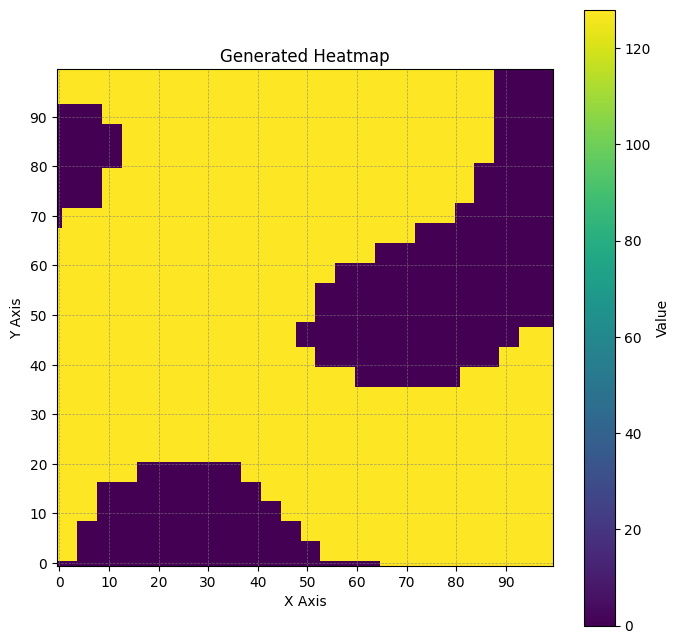

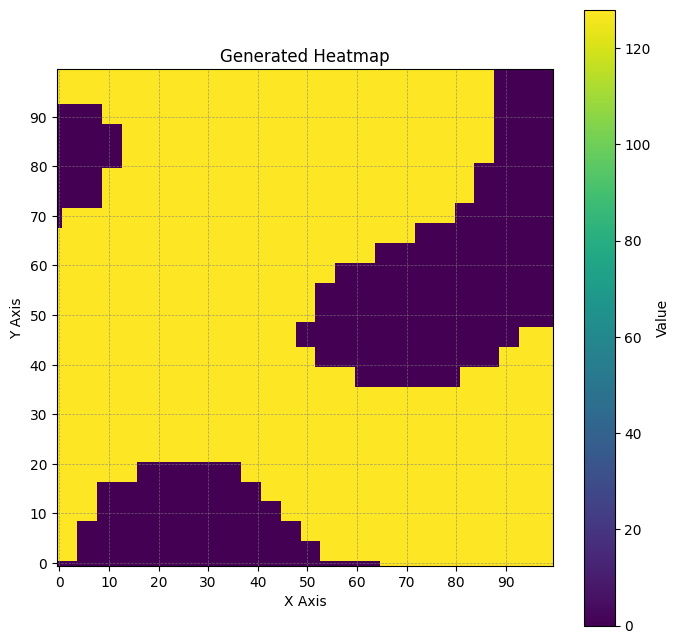

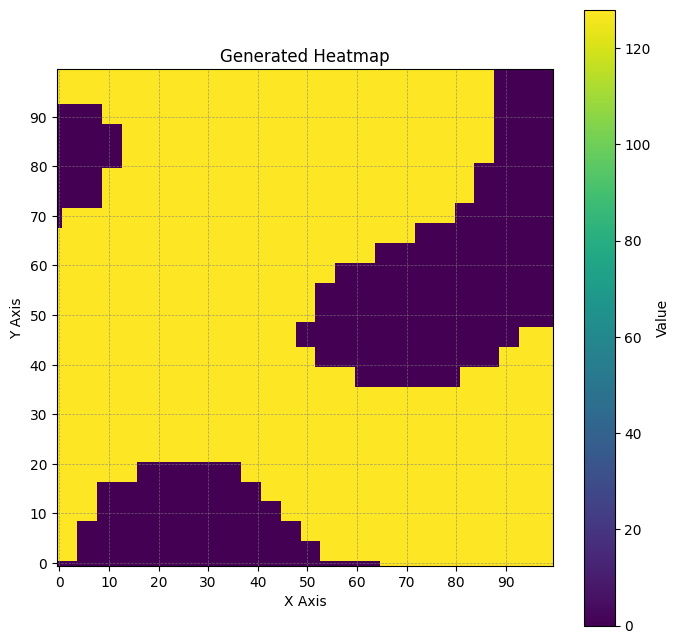

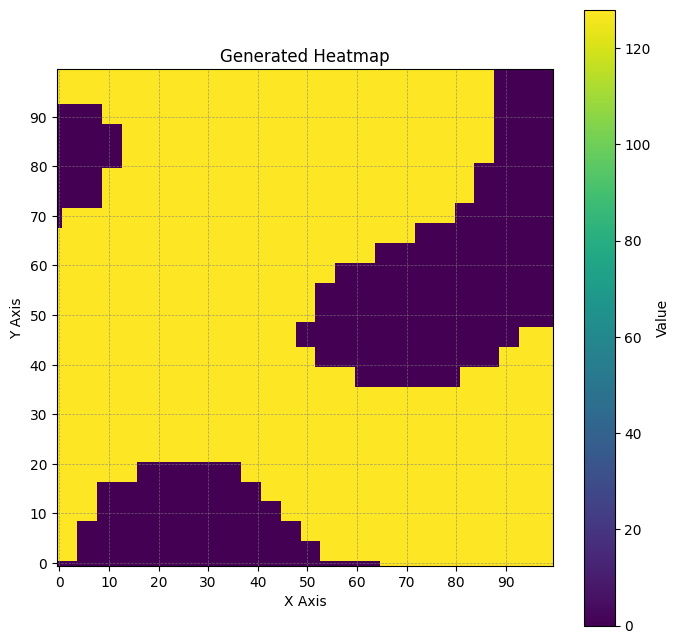

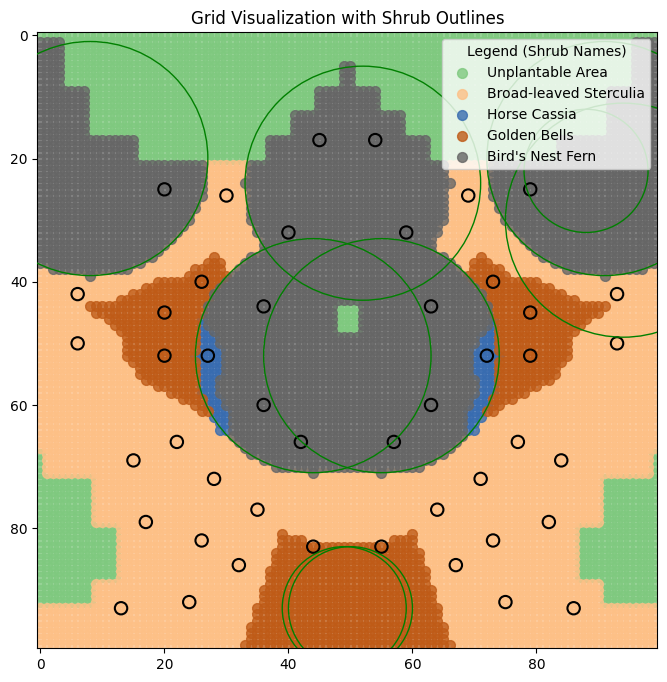

In [34]:
input_grid_z = createGrid("./models/23rd.zip")

something = gridHatching(input_grid_z,starting_input)

output_json = something.create_hatching(visualise=True)

## WX stuff for implementation

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import gc
import random
from perlin_noise import PerlinNoise

import cv2
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import label, center_of_mass

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

In [11]:
class proceduralGeneratedEnv():
    def __init__(self, octave:float, seed:int, grid_size:tuple, minimum_distance:int, padded_boundary:int):
        """
        Class to randomly generate an environment using perlin noise and dithering

        Args:
            octave (float): octave value from range [1-2] for perlin noise
            seed (int, optional): environment seed to recreate the same environment. Defaults to None.
            grid_size (tuple, optional): (w,h) of environment grid. Defaults to (100,100).
            minimum_distance (int): minimum distance between 2 planting coordinate
            padded_boundary (int): padded distance around the corners that will have no planting coordinate
        """
        self.octave = octave
        self.seed = seed
        self.grid_size = grid_size
        self.minimum_distance = minimum_distance
        self.padded_boundary = padded_boundary

    def create_environment(self):
        """
        Function to create an environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable (if random seed)
        Filters to ensure self.min_distance grid between all coordinates

        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 for planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 for planting area (entire environment)
            planting_grid (np.ndarray): self.grid_size grid of 0 for background and 1 for plantable coordinates (just the spot)
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array of all planting coordinates in (y,x) 
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed= self.seed if self.seed is not None else random.randint(0,50))
            width, height = self.grid_size

            # Create environment and dither 
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            # Adding boundary to ensure that the values are 1 for the boundary removal
            perlin_env[:self.padded_boundary, :] = 1 # Top boundary
            perlin_env[-self.padded_boundary:, :] = 1 # Bottom boundary
            perlin_env[:, :self.padded_boundary] = 1 # Left boundary
            perlin_env[:, -self.padded_boundary:] = 1 # Right boundary

            # Dither environment
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Retrieve all planting positions
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            
            # Non pre-set seed, check to ensure 7.5% must be plantable, else ignore
            if self.seed != None or len(planting_positions) / len(dithered_perlin_env.flatten()) > 7.5/100:
                break

        boundary_grid, filled_boundary_grid = self._extract_boundary(perlin_env)
        planting_grid, planting_coords  = self._filter_planting_coords(planting_positions)

        return boundary_grid.astype(np.int64), filled_boundary_grid.astype(np.int64), planting_grid.astype(np.int64), planting_coords
    
    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                # Ensure that padded boundary is actually 0 instead of 1
                if y <= self.padded_boundary or y >= height - self.padded_boundary:
                    dithered_grid[y, x] = 0
                
                elif x <= self.padded_boundary or x >= width - self.padded_boundary:
                    dithered_grid[y, x] = 0

                else:
                    bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                    dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
            
        return dithered_grid
    
    def _extract_boundary(self, perlin_grid:np.ndarray):
        """
        Funtion to extract the boundary of the dithered_grid (boundary)

        Args:
            perlin_grid (np.ndarray): Perlin noise grid
        
        Returns:
            boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 for planting boundary
            filled_boundary_grid (np.ndarray): self.grid_size grid of 0 and 1 for planting area (entire environment)
        """
        # Normalised to uint before adding a threshold from 128 to 255 (0.5 float pixel and above)
        normalised_grid = (perlin_grid * 255).astype(np.uint8)
        _, thresh = cv2.threshold(normalised_grid, 128, 255, cv2.THRESH_BINARY) 
        
        # Invert the thresholded image, so border is around the white part, planting area
        thresh_inverted = cv2.bitwise_not(thresh)

        # For dilating, expanding the points so that they form a nice boundary blob
        kernel = np.ones((3,3), np.uint8) 
        dilate_image = cv2.dilate(thresh_inverted, kernel, iterations=2)

        # Find contours on flood filled image for outline
        contours, _ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
        boundary_grid = np.zeros(self.grid_size)
        filled_boundary_grid = np.zeros(self.grid_size)

        # Draw contours
        cv2.drawContours(boundary_grid, contours, -1, (1), thickness=1)
        # Draw and colour contours
        cv2.fillPoly(filled_boundary_grid, contours, [1,1,1])

        return boundary_grid, filled_boundary_grid
    
    def _filter_planting_coords(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least self.minimum_distance apart
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        # numpy mask
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < self.minimum_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False

        # Apply mask to remove coordinates that are too close
        final_planting_coordinates = filtered_planting_positions[keep_array]
        
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        
        return final_grid, final_planting_coordinates    

In [12]:
class plantTypeAllocationEnv(gym.Env):
    def __init__(self, octave:float, theme:int, seed:int=None, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            theme (int): either 0 or 1, 0 for road while 1 for walkway
            seed (int, optional): environment seed to recreate the same environment. Defaults to None.
            grid_size (tuple, optional): (w,h) of environment grid. Defaults to (100,100).
        """
        super(plantTypeAllocationEnv, self).__init__()

        # Step for environment termination
        self.current_step = 0
        self.max_step = 250

        # Base Variables
        self.minimum_distance = 10
        self.tree_distance = 50
        self.padded_boundary = 5
        self.contour_distance = 5

        # Grid variables
        self.theme = theme
        self.seed = seed
        self.grid_size = grid_size

        # Create environment grid
        self.maximum_planting_spots = ((self.grid_size[0] - 2*self.padded_boundary)//self.minimum_distance + 1)**2
        self.env = proceduralGeneratedEnv(octave, seed, grid_size, self.minimum_distance, self.padded_boundary)
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self.env.create_environment()

        # Class Data
        # In y,x coordinates, need to be modified
        self.coordinates = {
            "Tree": [],
            "Shrubs" : []
        }
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}

        # Generate embedded coordinates & result grid
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)
        self.embeded_planting_coords = self._embed_coordinates()

        # Observation and Action Space
        self.observation_space = spaces.Box(low=-1, high=100, shape=(self.maximum_planting_spots, 3), dtype=np.float32)
        self.action_space = spaces.MultiDiscrete([self.maximum_planting_spots, 3])

    def _embed_coordinates(self):
        """
        Function to convert planting coordinates into their respective embedding
        [xCoord, yCoord, coordDistance, nearCurve, remainingPlantableTrees, originalTreeScore, finalTreeScore, shrubScore, naScore]
        Pad the remaining planting coordintes to ensure they remain a fixed length for the environment
        Padded data has (-1,-1,-1,-1,-1,-1,-1,-1,-1)

        Returns:
            embed_planting_list (np.ndarray): Numpy array of all embeded planting cordinates and padded coordinates 
        """
        # Padded
        embed_planting_list = np.full(((self.maximum_planting_spots), 9), -1, dtype=np.float32)  # Initialize with (-1, -1, ...)
        curve_data = []

        # Get the distance from the boundary, used to measure if near curves
        distance_from_boundary_grid = distance_transform_edt(self.filled_boundary)

        if self.theme == 0:
            # Road
            grid_distance  = self._distance_from_centre()
        else:
            # Walkway
            grid_distance =  distance_from_boundary_grid

        # Minimum distance before can plant tree
        min_tree_distance = (grid_distance.max() -  grid_distance.min())*0.3 + grid_distance.min()

        # Update ratio, leave the rest padded
        for i, planting_coords in enumerate(self.planting_coordinates): #planting coords is (y,x)
            # Retrieve the coordinate distance & the contour line it lies on
            contour, coord_dist = self._get_contour(grid_distance, planting_coords[1], planting_coords[0])
            # Retrieve the coordinate distance & contour line from the boundary
            if self.theme == 0:
                border_contour, border_dist = self._get_contour(distance_from_boundary_grid, planting_coords[1], planting_coords[0])
            else:
                border_contour, border_dist = contour, coord_dist
            curve_data.append([border_contour, border_dist])
            # Retrieve all remaining plantable trees after planting for this coordinate
            remaining_plantable_trees = self._get_remaining_plantable_tree_count(planting_coords[1], planting_coords[0])

            # Calculating the tree, shrub and NA scores
            tree_score = 2 if coord_dist >= min_tree_distance else -1 # Unplantable
            shrub_score = 2 
            na_score = 1 
            if self.theme == 0:
                # Road, shrub should be near center and not near boundary
                if border_contour <= 1:
                    shrub_score = 0
                    na_score = 3
                elif coord_dist <= min_tree_distance:
                    shrub_score = 3
            else:
                # Walkway, shrub is closer to boundary
                if border_contour <= 2:
                    shrub_score = 3
                    na_score = 0 

            # Update embeddings
            embed_planting_list[i] = (planting_coords[1], planting_coords[0], round(coord_dist), border_dist, remaining_plantable_trees, tree_score, tree_score, shrub_score, na_score)

        # Calculate near curve (the idea behind it is if they are in the same contour line and distance, )
        unique_contours, indices, counts = np.unique(np.array(curve_data), axis=0, return_inverse=True, return_counts=True)
        # Duplicated length likely to be at straight line
        is_duplicate = counts[indices] > 1
        # Update near Curve
        embed_planting_list[:len(self.planting_coordinates), 3] = np.where(is_duplicate, 0, 1)
        
        # Update tree score, if near curve and tree score becomes 2 -> 3
        embed_planting_list[(embed_planting_list[:, 3] == 1) & (embed_planting_list[:, 5] == 2), 5] = 3
        # Sum the tree plantable & maximum plantable trees together
        embed_planting_list[:, 6] = np.where(
            embed_planting_list[:, 6] != -1,  # Condition: 6th index is not -
            embed_planting_list[:, 4] + embed_planting_list[:, 5],  # Valid log operation
            embed_planting_list[:, 6]  # Remains unchanged if 6th index is -1
        )
        
        self.result_grid = embed_planting_list[:, 6:]

        return embed_planting_list.astype(np.int64)

    def _distance_from_centre(self):
        """
        Function to create a numpy grid with each grid being the distance from the centre of planting grid

        Returns:
            distance_from_center (np.ndarray): Array with the distance from centre
        """
        # Retrieve the labels and number of features (either 0 or 1)
        labeled_array, num_features = label(self.filled_boundary)
        # Prepare an array to store distances from the center of each area
        distance_from_center = np.zeros_like(self.filled_boundary, dtype=float)

        # For each labeled component, calculate distances from the centroid
        for label_num in range(1, num_features + 1):
            # Find the centroid of the current component
            centroid = center_of_mass(self.filled_boundary, labeled_array, label_num)
            # Create a mask for the current component
            mask = labeled_array == label_num
            # Get the coordinates of points in the current component
            coords = np.argwhere(mask)
            # Calculate distances from the centroid for each point in the component with elucidean distance
            for coord in coords:
                distance = np.sqrt((coord[0] - centroid[0])**2 + (coord[1] - centroid[1])**2)
                distance_from_center[tuple(coord)] = distance

        return distance_from_center

    def _get_contour(self, grid_distance:np.ndarray, xcoord:int, ycoord:int):
        """
        Function to retrieve the distance of a coordinate from the grid distance and the contour it belongs to

        Args:
            grid_distance (np.ndarray): numpy array with each coordinate showing the distance
            xcoord (int): x coordinate
            ycoord (int): y coordinate

        Returns:
            chosen_contour (int): contour coordinate belongs to
            coordinate_distance (float): distance of coordinate based off grid_distance
        """
        coordinate_distance = grid_distance[ycoord, xcoord]
        # Find the closest contour
        chosen_contour = coordinate_distance//self.contour_distance + (1 if coordinate_distance%self.contour_distance > self.contour_distance/2 else 0) 
        return chosen_contour, coordinate_distance

    def _get_remaining_plantable_tree_count(self, xcoord:int, ycoord:int):
        """
        Function to retrieve the log number of remaining plantable trees that are self.tree_distance away from coordinate

        Args:
            xcoord (int):  x coordinate
            ycoord (int): y coordinate
        """
        # Get all current tree coordinates
        new_tree_coordinates = np.array(self.coordinates['Tree'] + [[ycoord, xcoord]])
        # Calculate the distance of all planting coordinates from existing tree coordinates
        coordinate_distances = cdist(self.planting_coordinates, new_tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)
        # Return all counts where the min_distance > self.tree_distances
        return np.log(np.sum(min_distances >= 50)) if np.sum(min_distances >= self.tree_distance) > 0 else 0
        
    # RL model environment setup
    def _get_observation(self):
        return self.result_grid
    
    def reset(self, seed=None, options=None):
        """
        Reset environment
        """
        self.current_step = 0
        self.coordinates = {
                    "Tree": [],
                    "Shrubs" : []
                }        
        self.class_count = {0:0, 1:0, 2:0}
        self.class_density = {0:0.0, 1:0.0, 2:0.0}
        self.boundary, self.filled_boundary, self.grid, self.planting_coordinates = self.env.create_environment()
        self.result_grid = np.full(((self.maximum_planting_spots), 3), -1, dtype=np.float32)
        self.embeded_planting_coords = self._embed_coordinates()
        return self._get_observation() , {}
    
    def step(self, action):

        self.current_step +=  1
        reward = 0
        
        # Decode action
        chosen_index = action[0]
        class_value = action[1]
        chosen_value = self.embeded_planting_coords[chosen_index]

        reward = self.result_grid[chosen_index, class_value]

        if reward >= 0:
            # Update coordinate values
            if class_value == 0:
                self.coordinates['Tree'].append((chosen_value[1], chosen_value[0]))
                self._update_tree_distance()   

            elif class_value == 1:
                self.coordinates['Shrubs'].append((chosen_value[1], chosen_value[0]))

            # Update grid
            self.grid[chosen_value[1], chosen_value[0]] = class_value + 2
            self.class_count[class_value] += 1
            # Update result grid
            self.result_grid[chosen_index, :] = -1
            self._update_density_reward()
        
        done = bool(np.all(np.isin(self.result_grid[:, -1], [-1]))) or self.current_step >= self.max_step
        return self._get_observation(), float(reward), done ,False, {}
    
    def _update_tree_distance(self):
        """
        Function to update which coordinates are now no longer plantable after planting a new tree coordinate
        """
        tree_coordinates = np.array(self.coordinates['Tree'])
        # Get distance from all planting coordinates to all tree coordinates
        coordinate_distances = cdist(self.planting_coordinates, tree_coordinates, metric='euclidean')
        min_distances = np.min(coordinate_distances, axis=1)

        for index, dist in enumerate(min_distances):
            if dist < self.tree_distance:
                # No longer plantable
                # Update embedded_coordinates and result grid
                self.embeded_planting_coords[index][-4] = -1
                self.result_grid[index][0] = -1

        # Recalculate all new possible maximum tree planted after the tree coordinate update
        for index, result_row in enumerate(self.result_grid):
            if result_row[0] != -1:
                remaining_plantable_trees = self._get_remaining_plantable_tree_count(self.embeded_planting_coords[index][0], self.embeded_planting_coords[index][1])
                result_row[0] = remaining_plantable_trees + self.embeded_planting_coords[index][5] # Original Tree Score + new log(Max trees)
    
    def _update_density_reward(self):
        """
        Function to calculate the density reward
        """
        total_count = sum(self.class_count.values())
        for class_num in self.class_density.keys():
            density = self.class_count[class_num] / total_count
            self.class_density[class_num] = density

        # Shrub, NA ratio
        density_ratios = [0.65, 0.35]
        
        for index, class_index in enumerate([1, 2]):
            mask = self.result_grid[:, class_index] != -1  # Create a mask for values not equal to -1
            # Shrub is -2 in normalised_planting_list, NA is -1, class index is 1 and 2 so -3+classindex
            self.result_grid[mask, class_index] = self.embeded_planting_coords[mask, (-3+class_index)]*(np.exp(-(self.class_density[class_index])/density_ratios[index])**3)  # Apply exponential function
    
    def retrieve_results(self):
        """
        Function the returns the coordinates and numpy grid of the map
        Map index:
        {
        0: surrounding
        1: planting areas
        2: trees
        3: shrub 
        }

        Returns:
            theme (int): 0 for road, 1 for walkway
            grid (np.npdarray): numpy array of the updated grid with planted coordinates
            coordinates (dict): dictionary of {Tree: [], Shrubs:[]} with all the coordinates
        """
        # Swap the (y,x) to (x,y) coordinates
        updated_coordinates = {key: [(x, y) for y, x in value] for key, value in self.coordinates.items()}
        updated_grid = self.filled_boundary.copy()
        # Append the correct coordinates to the grid
        for key, coordinates in updated_coordinates.items():
            for x, y in coordinates:
                # Set the value at the given (x, y) position in the array
                updated_grid[y, x] = 2 if key=='Tree' else 3
                
        return self.theme, updated_grid, updated_coordinates
    
    def render(self, only_plant:bool=False, show_coord:bool=False):
        """
        Function to render the grid

        Args:
            only_plant (bool, optional): Show only planted spots, NA is not shown. Defaults to False.
            show_coord (bool, optional): Show reward values. Defaults to False.
        """
        value_to_colour_all = {
            0: (169/255, 169/255, 169/255),
            1: (1, 0, 0),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (0/255, 204/255, 204/255),
            5: (204/255, 255/255, 229/255)
        }

        value_to_colour_plant={
            0: (169/255, 169/255, 169/255),
            1: (204/255, 255/255, 229/255),
            2: (0, 51/255, 25/255),
            3: (0, 204/255, 0),
            4: (204/255, 255/255, 229/255),
            5: (204/255, 255/255, 229/255)
        }
        
        value_to_colour = value_to_colour_plant if only_plant else value_to_colour_all

        img = np.zeros((100, 100, 3))
        for value, color in value_to_colour.items():
            img[self.grid == value] = color
        
        img[(self.filled_boundary == 1) & (self.grid == 0)] = value_to_colour[5]

        if show_coord:
            plt.figure(figsize=(12, 12))

            # Plot each coordinate and label them with [a,b]
            for i, coord in enumerate(self.normalised_planting_list):
                x, y, d, nc, d2, d3, tp, sp, nap= coord
                ts,ss,nas = self.result_grid[i]
                if x == -1:
                    pass
                else:
                    # Add 0.5 to place text in the center of the cell
                    plt.text(x, y, f"{ts,ss,nas}", color="black", fontsize=6, ha="center", va="center", backgroundcolor='white')


        plt.imshow(img)  # Set origin to lower to align with the grid's coordinate syste
        # Add legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color), markersize=10) for color in value_to_colour.values()]
        labels = list(value_to_colour.keys())
        plt.legend(handles, labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.show()

In [13]:
from stable_baselines3 import PPO
model = PPO.load('../src/models/plantTypeAllocationModel.zip')

c:\Users\yongl\anaconda3\envs\Spatial\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\yongl\anaconda3\envs\Spatial\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


In [14]:
def eval_model(model:PPO, eval_env, show_results:bool=True, return_results:bool=True):
    """
    Function to evaluate model onto a defined environment

    Args:
        model (PPO): trained PPO model
        eval_env: environment to evaluate model on
        show_results (bool, optional): Render final grid. Defaults to True.
        return_results (bool, optional): Return the results (call environment.retrieve_results()). Defaults to True.
    """
    obs, info = eval_env.reset()
    total_reward = 0

    for i in range(eval_env.max_step):
        # Get action from the model
        action, _ = model.predict(obs)  # Get the predicted action
        obs, reward, done, trunacted, info = eval_env.step(action)  # Step the environment
        total_reward += reward  # Accumulate rewards

        if done:
            break

    print(f"Model completed in {i} steps, total reward {total_reward}")
    if show_results:
        eval_env.render(True)
    if return_results:
        return eval_env.retrieve_results()

Model completed in 54 steps, total reward 35.5367616713047


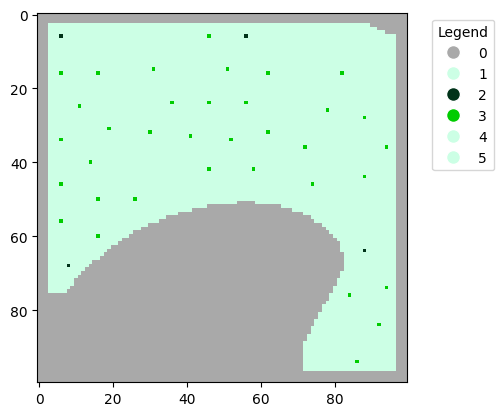

0
{'Tree': [(6, 6), (56, 6), (88, 64), (8, 68)], 'Shrubs': [(56, 24), (62, 32), (30, 32), (14, 40), (74, 46), (19, 31), (86, 94), (94, 74), (84, 76), (92, 84), (26, 50), (16, 50), (88, 44), (6, 16), (58, 42), (94, 36), (46, 6), (16, 60), (62, 16), (72, 36), (6, 34), (31, 15), (46, 42), (6, 56), (78, 26), (51, 15), (52, 34), (6, 46), (41, 33), (82, 16), (36, 24), (11, 25), (16, 16), (88, 28), (46, 24)]}


In [15]:
eval_env = plantTypeAllocationEnv(1.25, 0, 2)
theme1, grid1, coordinates1 = eval_model(model, eval_env)
print(theme1)
print(coordinates1)

Model completed in 57 steps, total reward 8.910840339958668


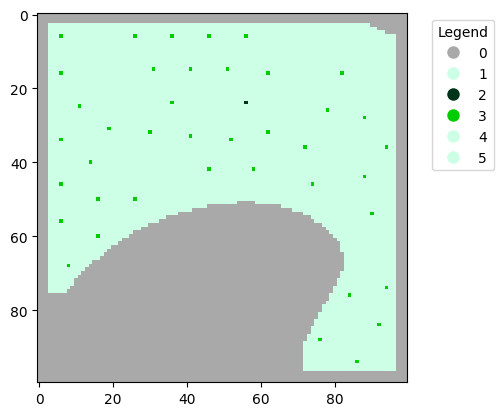

1
{'Tree': [(56, 24)], 'Shrubs': [(14, 40), (6, 46), (90, 54), (88, 44), (30, 32), (62, 32), (6, 6), (74, 46), (6, 56), (16, 50), (92, 84), (16, 60), (86, 94), (6, 34), (46, 42), (76, 88), (19, 31), (58, 42), (62, 16), (8, 68), (72, 36), (94, 36), (41, 15), (31, 15), (26, 6), (94, 74), (84, 76), (78, 26), (46, 6), (51, 15), (26, 50), (6, 16), (52, 34), (41, 33), (82, 16), (36, 6), (36, 24), (56, 6), (11, 25), (88, 28)]}


In [16]:
eval_env2 = plantTypeAllocationEnv(1.25, 1, 2)
theme2, grid2, coordinates2 = eval_model(model, eval_env2)
print(theme2)
print(coordinates2)

In [37]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import os
import copy
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import label
from scipy.stats import mode
import re

class gridHatching_v2():
    def __init__(self, starting_grid:np.ndarray, available_plant_dict: dict, tree_and_shrub_location_dict: dict = None ,randomised_seed: int = None, threshold: float = 0.1, fall_off: bool= False):
        """
        Class to take a grid and plant_selection in order to create hatches of regions 

        Args:
            grid (np.ndarray): grid received from procedural generation, 0 means unplantable, 1 means plantable, 2 means tree, 3 means shrub
            plant_dict (dict): the plant_dict and information on the theme as well
            tree_and_shrub_location_dict (dict["Tree"/"Shrub"]): the dictionary containing tuples of where tree and shrubs are
            threshold (float, optional): is the amount of difference between seed strength before one is dominannt
            fall_off (bool, optional): controls whether the influence from the depth of the area is bool (either 100 or 0 strength) or gradually decreases across distance 
        """
        self.randomized_seed = randomised_seed
        self.threshold = threshold
        self.fall_off = fall_off

        self.unplantable_int = 0
        self.plantable_int = 1
        self.tree_int = 2
        self.shrub_int = 3

        self.starting_grid = starting_grid
        self.starting_plant_dict = available_plant_dict
        
        # to be initialised during the initialise_info_function
        self.grid_shape = None
        self.theme = None
        self.tree_info_dict = None
        self.shrub_info_dict = None
        self.starting_shrub_seed_list = None
        self.shrub_int_list = None
        self.seed_mapping = None
        self.tree_radii_dict = None
        self.tree_id_dict = None

        self._initialise_info(starting_grid, available_plant_dict, tree_and_shrub_location_dict)

        # print("grid_shape")
        # print(self.grid_shape)
        # print("theme")
        # print(self.theme)
        # print("tree_info_dict")
        # print(self.tree_info_dict)
        # print("shrub_info_dict")
        # print(self.shrub_info_dict)
        # print("starting_seed_list")
        # print(self.starting_shrub_seed_list)
        # print("shrub_int_list")
        # print(self.shrub_int_list)
        # print("tree_id_dict")
        # print(self.tree_id_dict)
        # print("tree_radii_dict")
        # print(self.tree_radii_dict)
        # print("seed_mapping")
        # print(self.seed_mapping)

    def create_hatching(self, visualise=False):        
        intermediate_grid = self._generation()

        output_grid, output_seed_dict, seed_mapping = self._postprocessing(intermediate_grid)

        output_json = self._create_json(output_grid, output_seed_dict, seed_mapping)

        if visualise:
            self._visualize_grid_with_outlines_v2(output_grid, output_seed_dict, seed_mapping, self.tree_radii_dict)
        return output_json
    
    # Compiled Functions, not public but essentially the segments
    def _initialise_info(self, starting_grid, available_plant_dict, tree_and_shrub_location_dict):
        """
        Function used to initialise all the information before the grid generation

        Returns: 
            starting_seed_list (list[tuple]): a list of tuple of seed locations
            shrub_int_list (list): a list of integers to be used to populate the numpy array
            tree_radii_dict (dict): a dictionary of tuples of tree locations as the keys and radii of each tree as the value
        """ 
        self.grid_shape = (starting_grid.shape)
        self.theme = available_plant_dict["theme"]
        self.starting_shrub_seed_list = tree_and_shrub_location_dict["Shrubs"]
        trees_list = tree_and_shrub_location_dict["Tree"]
        self.tree_info_dict, self.shrub_info_dict = self._retrive_trees_shrubs_from_input_dict(available_plant_dict)
        new_trees = self._allocate_trees_to_coordinates(trees_list, self.tree_info_dict)
        self.tree_radii_dict = {pos: data[1] for pos, data in new_trees.items()}
        self.tree_id_dict = {pos: data[2] for pos, data in new_trees.items()}
        self.seed_mapping, self.shrub_int_list = self._create_seed_labels_v2(self.shrub_info_dict) 
    
    def _generation(self):
        """
        Function used to generate the raw heatmap before cleaning

        Returns: 
            output_grid (np.ndarray): the numpy array that has different regions labelled with different integers for different plants
        """ 
        seed_to_int_dict = self._choose_starter_slots_v3(self.starting_shrub_seed_list, self.seed_mapping) 
        noise_map = self._generate_worley_heatmap(distribution_seed=self.randomized_seed)
        noise_grids = self._combined_noisemap(self.grid_shape, noise_map, seed_to_int_dict) 
        heatmaps = self._create_heatmaps_v2(self.shrub_int_list , self.starting_grid, noise_grids, self.tree_radii_dict, self.fall_off) # This function can also be cleaned up bcos wx technically already has plantable and unplantable area segmented out so it does not need to be further subdivided
        output_grid = self._apply_influence_grids_with_border(heatmaps, self.starting_grid, threshold=self.threshold)
        return output_grid
    
    def _postprocessing(self, intermediate_grid):
        """
        Function used to generate the raw heatmap before cleaning

        Returns: 
            cleaned_grid (np.ndarray): the numpy array that has different regions labelled with different integers for different plants
            seed_dict (dict): a dictionary of integers of the selected regions as the keys and list of tuples of their locations as the value output.
        """ 
        cleaned_grid = self._fill_small_regions(intermediate_grid, required_points=self.starting_shrub_seed_list)
        seed_dict = self._sort_seeds_v2(cleaned_grid, self.starting_shrub_seed_list)
        shifted_seeds_dict = self._shift_and_space_seeds_optimized(cleaned_grid, seed_dict)
        cleaned_grid = self._merge_regions_without_seeds(cleaned_grid,shifted_seeds_dict)

        if self.theme == "manicured":
            cleaned_grid, shifted_seeds_dict, mirrored_trees, _ = self._mirror_grid(cleaned_grid, shifted_seeds_dict, self.tree_radii_dict)
            self.tree_radii_dict = mirrored_trees

        seed_mapping = {seed["Seed Number"]: seed["Shrub Name"] for seed in self.seed_mapping}

        return cleaned_grid, shifted_seeds_dict, seed_mapping
    
    def _retrive_trees_shrubs_from_input_dict(self, input_dict):
        """
        Parses through the input that is received from the previous function, the dict, and separates the plants in the selected plants list into shrubs and trees
        
        Args:
            input_dict (dict): The dictionary with the input values, where the list of info on the plants can be found in input dict["selected plants"]
        
        Returns:
            Tree_Species (list of dict): List of containing the dictionaries of each tree
            Shrub_Species (list of dict): List of containing the dictionaries of each shrub
        """
        Tree_Species = []
        Shrub_Species = []
        selected_plants_list = input_dict["selected_plants"]
        for plant in selected_plants_list:
            if self._contains_palm(plant["Plant Type"]) or self._contains_tree(plant["Plant Type"]):
                # It is a tree
                Tree_Species.append(plant)
            elif self._contains_shrub(plant["Plant Type"]):
                Shrub_Species.append(plant)
            else:
                print("WHATT ARE THOSEE")
                continue
        return Tree_Species,Shrub_Species
    
    def _allocate_trees_to_coordinates(self, tree_positions, Trees_list):
        """
        Allocates a tree species and its radius to each coordinate from the given tree list.

        Args:
            tree_positions (list of tuple): List of (y, x) grid coordinates.
            Trees_list (list of dict): List of tree data with species name and canopy radius.

        Returns:
            dict: A dictionary mapping each coordinate to a tree species and its radius.
        """
        # Check if there are any tree species
        if not Trees_list:
            raise ValueError("No tree species available in the tree list.")

        # Initialize the output dictionary
        allocated_trees = {}

        # Assign each coordinate a tree species and radius
        for pos in tree_positions:
            # Randomly select a tree species
            selected_tree = random.choice(Trees_list)
            name = selected_tree["Species Name"]
            radius = selected_tree.get("Canopy Radius", "None")
            id = selected_tree.get("Species ID")
            
            # Ensure radius is a float if possible
            radius = float(radius) if radius != "None" else 0
            
            # Allocate the tree to the coordinate
            allocated_trees[pos] = [name, radius, id]

        return allocated_trees
    
    def _create_seed_labels_v2(self, shrubs_list):
        """
        Categorises shrubs based on their light preferences and border proximity, 
        assigns seed numbers to each shrub, and returns the seed mappings.

        Shrubs are divided into the following categories:
        - BSH: Border, Shade Hating
        - NBSL: Not Border, Shade Loving
        - NBSH: Not Border, Shade Hating
        - BSL: Border, Shade Loving

        Seed numbers are generated uniquely for each category based on conditions, ensuring no overlap.

        Args:
            shrubs_list (list): A list of dictionaries representing shrubs. Each dictionary contains:
                - "Plant Type" (str): Type of the plant (e.g., "Shrub").
                - "Light Preference" (str): Light preference (e.g., "Full Shade", "Semi Shade").
                - "Hazard" (str): Whether the shrub is on the border ("-" indicates it's on the border).
                - "Species Name" (str): Name of the shrub species.

        Returns:
            - seed_mapping (list of dict): A list of dictionaries where each dictionary represents a shrub with:
                - "Seed Number" (int): The assigned seed number.
                - "Shrub Name" (str): The species name of the shrub.
            - seeds_list (list of int): A list of all seed numbers assigned to shrubs.
        """
        BSH = 0  # Border, Shade Hating
        NBSL = 0  # Not Border, Shade Loving
        NBSH = 0  # Not Border, Shade Hating
        BSL = 0  # Border, Shade Loving
        shrub_mapping = {  # To map seeds to shrub names
            "BSH": [],
            "NBSL": [],
            "NBSH": [],
            "BSL": []
        }

        # Process each shrub and categorize
        for shrub in shrubs_list:
            if "Shrub" in shrub["Plant Type"]:  # Ensure it's a shrub
                if shrub["Hazard"] != "-":  # NB: Not Border (hazard present)
                    if self._contains_semi_shade_jx(shrub["Light Preference"]) or self._contains_full_shade_jx(shrub["Light Preference"]):
                        # NBSL: Not Border, Shade Loving
                        NBSL += 1
                        shrub_mapping["NBSL"].append(shrub["Species Name"])
                    else:
                        # NBSH: Not Border, Shade Hating
                        NBSH += 1
                        shrub_mapping["NBSH"].append(shrub["Species Name"])
                else:  # B: Border (no hazard)
                    if self._contains_semi_shade_jx(shrub["Light Preference"]) or self._contains_full_shade_jx(shrub["Light Preference"]):
                        # BSL: Border, Shade Loving
                        BSL += 1
                        shrub_mapping["BSL"].append(shrub["Species Name"])
                    else:
                        # BSH: Border, Shade Hating
                        BSH += 1
                        shrub_mapping["BSH"].append(shrub["Species Name"])

        # Generate seed numbers for the categories
        seedlists = self._select_numbers(startingNumber=3, BSH=BSH, NBSL=NBSL, BSL=BSL, NBSH=NBSH)

        # Map seed numbers to shrubs
        seed_mapping = []
        seeds_list = []
        for category in ["BSH", "NBSL", "NBSH", "BSL"]:
            seeds = seedlists[category]
            names = shrub_mapping[category]
            for seed, name in zip(seeds, names):
                seed_mapping.append({"Seed Number": seed, "Shrub Name": name})
                seeds_list.append(seed)

        return seed_mapping, seeds_list

    def _select_numbers(self, BSH=0, NBSL=0, NBSH=0, BSL=0, startingNumber=3):
        """
        Selects integers for each category based on the specified conditions:
        - BSH: Border, shade hating (not a multiple of 2, multiple of 3)
        - NBSL: Not Border, shade loving (multiple of 2, not a multiple of 3)
        - NBSH: Not Border, shade hating (not a multiple of 2, not a multiple of 3)
        - BSL: Border, shade loving (multiple of 2, multiple of 3)

        Args:
            BSH (int): Number of integers required for Border, shade hating condition.
            NBSL (int): Number of integers required for Not Border, shade loving condition.
            NBSH (int): Number of integers required for Not Border, shade hating condition.
            BSL (int): Number of integers required for Border, shade loving condition.
            startingNumber (int): The number to start iterating from.

        Returns:
            dict: A dictionary with keys 'BSH', 'NBSL', 'NBSH', 'BSL' and lists of integers as values.
        """
        result = {"BSH": [], "NBSL": [], "NBSH": [], "BSL": []}
        current_number = startingNumber

        while len(result["BSH"]) < BSH or len(result["NBSL"]) < NBSL or len(result["NBSH"]) < NBSH or len(result["BSL"]) < BSL:
            if current_number % 2 != 0 and current_number % 3 == 0 and len(result["BSH"]) < BSH:
                result["BSH"].append(current_number)
            elif current_number % 2 == 0 and current_number % 3 != 0 and len(result["NBSL"]) < NBSL:
                result["NBSL"].append(current_number)
            elif current_number % 2 != 0 and current_number % 3 != 0 and len(result["NBSH"]) < NBSH:
                result["NBSH"].append(current_number)
            elif current_number % 2 == 0 and current_number % 3 == 0 and len(result["BSL"]) < BSL:
                result["BSL"].append(current_number)
            
            current_number += 1

        return result

    def _choose_starter_slots_v3(self, shrub_positions, starter_types, percentage_of_starters=0.8):
        """
        Selects a percentage of shrub positions to be assigned as starter slots and groups them
        by starter types based on the provided list.

        Args:
            shrub_positions (list): List of tuples representing the positions of shrubs.
            starter_types (list): List of dictionaries with "Seed Number" and optionally other fields.
            percentage_of_starters (float): Percentage of shrub positions to use as starter slots. Default is 0.8 (80%).

        Returns:
            dict: A dictionary of seed locations by type.
        """
        shrub_slots = copy.deepcopy(shrub_positions)
        
        # Use only the "Seed Number" from starter_types for seed_locations keys
        seed_locations = {t["Seed Number"]: [] for t in starter_types}

        # Determine the number of starters based on the percentage
        number_of_starters = int(len(shrub_slots) * percentage_of_starters)
        number_of_starters = max(1, number_of_starters)  # Ensure at least one starter is selected

        # Use the provided list of starter types in sequence
        types_sequence = [starter_types[i % len(starter_types)]["Seed Number"] for i in range(number_of_starters)]

        for i, assigned_type in enumerate(types_sequence):
            if not shrub_slots:  # If no more shrub positions are left, break the loop
                break
            selected_position = shrub_slots.pop(0)  # Select the next shrub position in order
            seed_locations[assigned_type].append(selected_position)

        return seed_locations

    def _generate_worley_heatmap(self, grid_size=(100, 100), distribution_seed=None, value_range=(40, 50), feature_points=20, invert=False): 
        """
        Generate a random heatmap using Worley noise.

        Args:
            grid_size (tuple): The size of the heatmap (width, height).
            distribution_seed (int or None): Seed for reproducibility.
            value_range (tuple): The range of values for the heatmap (min, max).
            feature_points (int): Number of feature points in the grid.
            invert (bool): Whether to invert the values so that centers of the points are high-value areas.

        Returns:
            np.ndarray: A 2D array representing Worley noise.
        """
        width, height = grid_size

        # Set random seed for reproducibility
        if distribution_seed is not None:
            random.seed(distribution_seed)

        # Generate random feature points
        feature_points = [(random.uniform(0, width), random.uniform(0, height)) for _ in range(feature_points)]

        def closest_distance(x, y):
            # Compute the closest distance to a feature point
            return min(np.sqrt((x - fx) ** 2 + (y - fy) ** 2) for fx, fy in feature_points)

        # Compute Worley noise for the grid
        noise = np.array([[closest_distance(x, y) for x in range(width)] for y in range(height)])

        # Normalize the noise to 0-1
        noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))

        # Invert the noise if required
        if invert:
            noise = 1 - noise

        # Scale the noise to the desired value range
        min_val, max_val = value_range
        noise = noise * (max_val - min_val) + min_val

        return noise

    def _combined_noisemap(self, grid_shape, noise_map, seed_dict): 
        """
        Combines the influence of multiple seed groups onto a noise map and returns 
        the influence grids for each seed group.

        This function applies the `_radiate_influence` method for each seed group in 
        `seed_dict`, generating an influence grid for each group based on the input 
        grid shape, noise map, and seed locations.

        Args:
            grid_shape (tuple): The shape of the grid (height, width) for generating the influence map.
            noise_map (np.ndarray): A 2D array representing noise values used to calculate influence.
            seed_dict (dict): A dictionary where keys are seed group identifiers (e.g., types of seeds),
                            and values are lists of seed positions [(y1, x1), (y2, x2), ...].

        Returns:
            dict: A dictionary where keys are seed group identifiers and values are 2D influence grids
                (np.ndarray) generated for each seed group.
        """
        seed = {}
        for i in seed_dict:
            seed[i] = self._radiate_influence(grid_shape, noise_map, seed_dict[i])
        return seed

    def _radiate_influence(self, grid_shape, noise_map, seed_locations, decay_rate=0.1):
        """
        Radiates influence from each seed location based on its strength on the noise map, taking the maximum influence.

        Args:
            grid (np.ndarray): The input grid where influence will be applied.
            noise_map (np.ndarray): A grid representing the noise values.
            seed_locations (list of tuple): List of (y, x) seed coordinates.
            decay_rate (float): The rate at which influence decreases with distance.

        Returns:
            np.ndarray: A grid with the maximum influence from all seeds.
        """
        # Get grid dimensions
        height, width = grid_shape

        # Initialize the influence grid with zeros
        influence_grid = np.zeros((height, width), dtype=np.float32)

        # Iterate over each seed
        for y, x in seed_locations:
            # Get the seed's strength from the noise map
            if 0 <= y < height and 0 <= x < width:
                seed_strength = noise_map[y, x]

                # Iterate over the grid to calculate influence
                for i in range(height):
                    for j in range(width):
                        # Calculate the distance from the seed
                        distance = np.sqrt((i - y) ** 2 + (j - x) ** 2)

                        # Calculate the influence based on the distance
                        influence = seed_strength * np.exp(-decay_rate * distance)

                        # Assign the maximum influence to the grid
                        influence_grid[i, j] = max(influence_grid[i, j], influence)

        influence_grid = np.flipud(influence_grid)

        return influence_grid
   
    def _create_heatmaps_v2(self, seed_list, grid, noise_grids, tree_radii, fall_off= False): #This function can also be cleaned up bcos wx technically already has plantable and unplantable area segmented out so it does not need to be further subdivided
        """
        Generates heatmaps for each seed type based on noise grids and tree radii.

        This function iterates over a list of seed types, creating a heatmap for each type 
        by leveraging `_create_heatmap_for_type_v2`. It uses the provided grid and noise grids 
        and applies tree radius and optional fall-off parameters.

        Note:
            If the grid already segments plantable and unplantable areas, further subdivision 
            within this function is unnecessary, making it possible to simplify its logic.

        Args:
            seed_list (list): A list of seed types (e.g., seed identifiers or categories).
            grid (np.ndarray): A 2D array representing the overall grid environment.
            noise_grids (dict): A dictionary where keys are seed types and values are noise grids 
                                (np.ndarray) corresponding to each seed type.
            tree_radii (dict): A dictionary mapping each seed type to its associated tree radius.
            fall_off (bool, optional): If True, applies a fall-off effect in the heatmap calculation. 
                                    Default is False.

        Returns:
            dict: A dictionary where keys are seed types and values are their corresponding heatmaps 
                (np.ndarray) generated based on the input parameters.
        """
        seed_heatmaps = {}
        for i in seed_list:
            seed_heatmaps[i] = self._create_heatmap_for_type_v2(i,grid, noise_grids[i], tree_radii =tree_radii, fall_off=fall_off)
        return seed_heatmaps

    def _create_heatmap_for_type_v2(self, seed_value, grid, noise_grid, tree_radii, fall_off=False):
        """
        Generates a combined heatmap for a specific seed type by considering shade preferences, 
        border proximity, and noise influences.

        This function creates and combines multiple heatmaps:
        - Shade heatmap based on tree radii and the seed's shade preference.
        - Border proximity heatmap based on whether the seed prefers the border.
        - Noise grid as an external influence.

        Args:
            seed_value (int): The value representing the seed type, used to determine preferences:
                            - Multiple of 2: Shade-loving.
                            - Not a multiple of 2: Shade-hating.
                            - Multiple of 3: Border-loving.
                            - Not a multiple of 3: Not border-loving.
            grid (np.ndarray): The 2D array representing the overall grid environment.
            noise_grid (np.ndarray): A noise grid specific to the seed type, influencing the heatmap.
            tree_radii (dict): A dictionary mapping seed types to their associated tree radii.
            fall_off (bool, optional): If True, applies an instant fall-off effect to border calculations. 
                                    Default is False.

        Returns:
            np.ndarray: A combined heatmap that integrates shade preferences, border proximity, 
                        and noise influences for the given seed type.
        """
        plantable_grid = self._shade_inside_border(grid)
        # Create the grids to be combined
        shade_grid = None
        # If the thing is a multiple of 2 then it is shade loving
        if seed_value%2 == 0:
            shade_grid = self._label_heatmap_based_on_trees_v2(plantable_grid,tree_radii)
        else:
            shade_grid = self._label_heatmap_based_on_trees_v2(plantable_grid, tree_radii, invert=True)
        visualize_heatmap(shade_grid)
        border_grid = None
        # If the seed_value is a modulus of 3 then it is something that likes the border
        if seed_value%3 ==0:
            border_grid = self._calculate_border_proximity(plantable_grid, instant_fall_off=fall_off)
        else:
            border_grid = self._calculate_distance_to_border(plantable_grid, instant_fall_off=fall_off)
        
        # visualize_heatmap(shade_grid)
        # visualize_heatmap(border_grid)
        influences = [shade_grid,border_grid, noise_grid]
        influence = self._combine_heatmaps(influences)
        # visualize_heatmap(influence)
        return influence

    def _shade_inside_border(self, grid, fill_value=128):
        """
        Shade points inside the grid by filling non-zero regions with a specified fill color,
        leaving 0 values untouched.

        Args:
            grid (np.ndarray): The grid representing the environment.
            fill_value (int): Value to fill the inside regions with.

        Returns:
            np.ndarray: Modified grid with non-zero regions shaded with the fill color.
        """
        # Create a mask for non-zero regions
        non_zero_mask = grid > 0

        # Create a copy of the grid to modify
        shaded_grid = np.copy(grid)

        # Apply the fill color to non-zero regions only
        shaded_grid[non_zero_mask] = fill_value

        return shaded_grid

    def _label_heatmap_based_on_trees_v2(self, grid, tree_data, invert=False):
        """
        Creates a new grid where points with a value of 128 are labeled with 100 or 0 
        based on their proximity to trees. Each tree has a specific radius for labeling.
        Points within or outside the radius are labeled, depending on `invert`.

        Args:
            grid (np.ndarray): The input grid (heatmap values or similar structure).
            tree_data (dict): Dictionary with (y, x) coordinates as keys and radius as values.
            invert (bool): If True, label points outside the radius of all trees instead of within it.

        Returns:
            np.ndarray: A new grid where desired squares are labeled as 100, others as 0.
        """
        # Initialize the new grid with zeros
        labeled_grid = np.zeros_like(grid, dtype=np.float32)

        # Identify positions with a value of 128 in the grid
        target_positions = np.argwhere(grid == 128)

        # If there are tree positions and target positions, calculate distances
        if len(tree_data) > 0 and len(target_positions) > 0:
            # Extract tree positions and radii
            tree_positions = np.array(list(tree_data.keys()))
            tree_radii = np.array(list(tree_data.values()))

            # Calculate distances from target positions to the tree positions
            distances = cdist(target_positions, tree_positions)

            if invert:
                # Label points outside the radius of ALL trees
                outside_all_trees = np.all(distances > tree_radii, axis=1)
                valid_indices = np.where(outside_all_trees)[0]
            else:
                # Label points within the radius of ANY tree
                within_any_tree = np.any(distances <= tree_radii, axis=1)
                valid_indices = np.where(within_any_tree)[0]

            # Mark valid target points in the labeled grid
            for index in valid_indices:
                y, x = target_positions[index]
                labeled_grid[y, x] = 100  # Assign the value 100 for valid points

            labeled_grid = np.flipud(labeled_grid)

        return labeled_grid

    def _calculate_border_proximity(self, grid, constant_zone=0.6, instant_fall_off=False):
        """
        Calculate a proximity map where pixels of type 128 closest to the border have the highest value.
        Type 0 remains 0. Includes a cutoff value to ignore distances below the cutoff threshold,
        a max_cutoff to cap the proximity effect, and a constant_zone where the score remains 100.
        Supports an instant fall-off mode where values less than 100 are set to 0.

        Args:
            grid (np.ndarray): 2D array where 128 represents the target area.
            cutoff (float): The minimum distance value to consider. Distances below this are set to 0.
            max_cutoff (float or percentage): The maximum distance value to cap. If between 0 and 1, treated as a percentage.
            constant_zone (float or percentage): The distance from the border where the proximity value remains 100.
                                                If between 0 and 1, treated as a percentage.
            instant_fall_off (bool): If True, values less than 100 are set to 0.

        Returns:
            np.ndarray: A 2D array where proximity to the border is higher for points closer to the border.
        """
        cutoff = 1
        max_cutoff = 1
        # Create a binary mask where type 128 is 1 and everything else is 0
        binary_mask = (grid == 128).astype(np.uint8)

        # Apply distance transform
        distance_to_border = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

        # Calculate max_distance for normalization and percentage-based calculations
        max_distance = np.max(distance_to_border)

        # Convert constant_zone and max_cutoff to absolute values if they are percentages
        if 0 < constant_zone <= 1:
            constant_zone = constant_zone * max_distance
        if 0 < max_cutoff <= 1:
            max_cutoff = max_cutoff * max_distance

        # Maintain a constant value of 100 in the constant zone
        proximity_map = np.zeros_like(distance_to_border)
        proximity_map[distance_to_border <= constant_zone] = 100

        # Normalize the distances beyond the constant zone
        beyond_constant_zone = distance_to_border > constant_zone
        if max_distance > 0:
            normalized_distances = (distance_to_border[beyond_constant_zone] - constant_zone) / (max_distance - constant_zone)
            proximity_map[beyond_constant_zone] = (1 - normalized_distances) * 100

        # Apply cutoff to remove low-proximity regions
        proximity_map = np.where(distance_to_border >= cutoff, proximity_map, 0)

        # Handle instant fall-off: Set all values less than 100 to 0
        if instant_fall_off:
            proximity_map = np.where(proximity_map == 100, 100, 0)
        else:
            # Apply max_cutoff to limit the proximity range
            if max_cutoff is not None:
                proximity_map = np.where(distance_to_border <= max_cutoff, proximity_map, 0)

        # Flip the proximity map vertically
        flipped_proximity_map = np.flipud(proximity_map)

        return flipped_proximity_map

    def _calculate_distance_to_border(self, grid, cutoff=1, max_area=0.4, instant_fall_off=False):
        """
        Calculate and normalize the distance of each pixel to the nearest border of the area with type 128.
        Includes a cutoff value to ignore distances below the cutoff threshold and a max_area to cap the proximity.
        Allows max_area to specify the portion of the grid covered.
        Supports an instant fall-off mode where values drop to 0 beyond the max_area range.

        Args:
            grid (np.ndarray): 2D array where 128 represents the target area.
            cutoff (float): The minimum distance value before starting to increase. Default is 1.
            max_area (float): The portion of the grid where proximity should remain non-zero. If between 0 and 1, treated as a percentage.
            instant_fall_off (bool): If True, values beyond max_area are set to 0 immediately.

        Returns:
            np.ndarray: A 2D array of the same shape as the input, containing normalized distances.
        """
        # Create a binary mask where type 128 is 1 and everything else is 0
        max_cutoff = 1 - max_area
        binary_mask = (grid == 128).astype(np.uint8)

        # Apply distance transform
        distance_to_border = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

        # Apply cutoff
        distance_to_border = np.where(distance_to_border >= cutoff, distance_to_border, 0)

        # Convert max_cutoff to an absolute value if it's a percentage (0 < max_cutoff <= 1)
        max_distance = np.max(distance_to_border)
        if 0 < max_cutoff <= 1:  # If max_cutoff is a percentage
            max_cutoff = max_cutoff * max_distance

        # Set values at max_cutoff to 100 and normalize the gradient
        distance_to_border = np.clip(distance_to_border, 0, max_cutoff)  # Cap at max_cutoff
        if max_cutoff > 0:
            normalized_distance_map = (distance_to_border / max_cutoff) * 100  # Scale to range [0, 100]

        # Set values that hit max_cutoff to exactly 100
        normalized_distance_map[distance_to_border == max_cutoff] = 100

        # Handle instant fall-off: Retain yellow zones (100) and remove all other gradients
        if instant_fall_off:
            normalized_distance_map = np.where(normalized_distance_map == 100, 100, 0)

        # Flip the distance map vertically
        flipped_distance_map = np.flipud(normalized_distance_map)

        return flipped_distance_map

    def _combine_heatmaps(self, heatmaps):
        """
        Combine multiple heatmaps into a single heatmap by summing them element-wise.

        Args:
            heatmaps (list of np.ndarray): List of 2D heatmaps to combine.

        Returns:
            np.ndarray: Combined heatmap with the same shape as the input heatmaps.
        """
        if not heatmaps:
            raise ValueError("The list of heatmaps is empty.")
        
        # Ensure all heatmaps have the same shape
        shape = heatmaps[0].shape
        for idx, h in enumerate(heatmaps):
            if h.shape != shape:
                print(f"Heatmap at index {idx} has shape {h.shape}, expected {shape}")
                raise ValueError("All heatmaps must have the same shape.")
        
        # Sum the heatmaps element-wise
        combined = sum(heatmaps)
        
        return combined

    def _apply_influence_grids_with_border(self, influence_grids, grid, threshold=1):
        """
        Apply influence grids to assign plant types based on influences while respecting the border constraints.
        Correct the vertical flip issue by flipping the grid as needed.

        Args:
            influence_grids (dict): A dictionary of influence grids for each plant type.
            grid (np.ndarray): Original grid to determine workable spots.
            threshold (float): The maximum absolute difference between influences to trigger random selection.

        Returns:
            np.ndarray: A grid with plant types assigned based on influence grids, keeping non-workable spots untouched.
        """
        # Identify workable spots using shade_inside_border
        workable_grid = self._shade_inside_border(grid)
        
        # Flip grids vertically to address the issue
        flipped_influence_grids = {
            plant_type: np.flipud(influence_grids[plant_type])
            for plant_type in influence_grids
        }
        
        grid_shape = workable_grid.shape

        # Initialize the assigned grid with zeros
        assigned_grid = np.zeros(grid_shape, dtype=int)

        # Iterate through each cell in the grid
        for i in range(grid_shape[0]):
            for j in range(grid_shape[1]):
                if workable_grid[i, j] == 128:  # Only consider workable spots
                    # Gather influences for all plant types at this position
                    influences = [
                        (flipped_influence_grids[plant_type][i, j], plant_type)
                        for plant_type in flipped_influence_grids
                    ]

                    # Sort influence values with their corresponding types
                    influences.sort(reverse=True, key=lambda x: x[0])  # Sort by influence value

                    # Decide based on the absolute threshold
                    if len(influences) > 1 and abs(influences[0][0] - influences[1][0]) <= threshold:
                        # Randomly select between the top two types
                        assigned_type = random.choice([influences[0][1], influences[1][1]])
                    else:
                        # Select the type with the highest influence
                        assigned_type = influences[0][1]

                    # Assign the type to the corresponding cell
                    assigned_grid[i, j] = assigned_type
                else:
                    # Retain the original value for non-workable spots (e.g., 0)
                    assigned_grid[i, j] = grid[i, j]

        return assigned_grid

    def _fill_small_regions(self, grid, min_size=50, required_points=[]):
        """
        Replace small patches (connected components) in a grid with surrounding tile values.
        Additionally, replace regions that do not contain at least one required point.

        Args:
            grid (np.ndarray): The input 2D grid with integer values (e.g., 3 and above for regions).
            min_size (int): The minimum size for a region to remain unchanged.
            required_points (list of tuple): List of (y, x) coordinates. Regions missing these points will be replaced.

        Returns:
            np.ndarray: A grid with small regions filled with surrounding tile values.
        """
        # Create a copy of the grid to modify
        cleaned_grid = np.copy(grid)
        
        # Identify unique region values (starting from 3)
        unique_values = np.unique(grid[grid >= 3])  # Ignore values less than 3
        
        # Iterate over unique values in the grid
        for value in unique_values:
            # Create a mask for the current region
            mask = (grid == value)
            
            # Label connected components within the mask
            labeled_mask, num_features = label(mask)
            
            # Iterate over connected components
            for region_label in range(1, num_features + 1):
                # Extract the region
                region_mask = (labeled_mask == region_label)
                region_size = np.sum(region_mask)
                region_coords = np.argwhere(region_mask)

                # Check if the region contains at least one required point
                contains_required_point = any(tuple(coord) in required_points for coord in region_coords)

                # If the region size is smaller than the threshold or does not contain a required point
                if region_size < min_size or not contains_required_point:
                    # Collect surrounding values for all pixels in the region
                    surrounding_values = []
                    for y, x in region_coords:
                        # Check all 8 neighbors
                        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            ny, nx = y + dy, x + dx
                            if 0 <= ny < grid.shape[0] and 0 <= nx < grid.shape[1]:  # Check bounds
                                neighbor_value = cleaned_grid[ny, nx]
                                surrounding_values.append(neighbor_value)
                    
                    # Determine the most frequent surrounding value
                    values = {}
                    for x in surrounding_values:
                        if x not in values:
                            values[x] = 1
                        else:
                            values[x] += 1

                    replacement_value = None
                    while replacement_value is None:
                        replacement_value = max(values, key=values.get)
                        if replacement_value == 0:
                            replacement_value = None
                            values.pop(max(values, key=values.get), None)

                    # Replace the small region or region without required points
                    cleaned_grid[region_mask] = replacement_value

        return cleaned_grid
   
    def _sort_seeds_v2(self, grid, seeds):
        """
        Sorts the seeds based on their corresponding values on a grid.

        Args:
            grid (np.ndarray): A 2D numpy array representing the grid.
            seeds (list of tuples): A list of (x, y) coordinate tuples.

        Returns:
            dict: A dictionary where keys are grid values and values are lists of coordinates.
        """
        sorted_seeds = {}

        for y, x in seeds:
            # Get the value at the grid position
            value = grid[y, x]  # Note: grid indexing is row-major (y, x)

            # Add the coordinate to the appropriate list in the dictionary
            if value not in sorted_seeds:
                sorted_seeds[value] = []
            sorted_seeds[value].append((y, x))

        sorted_seeds = dict(sorted(sorted_seeds.items()))
        return sorted_seeds

    def _shift_and_space_seeds_optimized(self, input_grid, seed_dict_x, min_distance=5, spacing_distance=7, max_iterations=100):
        """
        Optimized version to shift seeds inward and ensure they are spaced out within regions.
        Includes timeout for both boundary adjustment and spacing adjustments.

        Args:
            input_grid (np.ndarray): A numpy grid representing the different areas.
            seed_dict_x (dict): A dictionary with keys as area types and values as lists of (y, x) coordinates of seeds.
            min_distance (float): The minimum distance a seed must maintain from the boundary.
            spacing_distance (float): The minimum distance seeds must maintain from each other.
            max_iterations (int): Maximum number of iterations to try for adjusting seed spacing.

        Returns:
            dict: Updated seed_dict_x with seeds shifted inward and spaced out within regions.
        """
        for area_type, seeds in seed_dict_x.items():
            # Create a binary mask for the current area type
            binary_mask = (input_grid == area_type).astype(np.uint8)

            # Apply distance transform to get distances from the boundary
            distance_to_boundary = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

            # Step 1: Shift seeds inward until they meet the minimum distance from the boundary
            shifted_seeds = []
            for seed in seeds:
                y, x = seed
                steps = 0  # Timeout counter for boundary adjustment

                while distance_to_boundary[y, x] < min_distance and steps < min_distance:
                    best_shift = None
                    max_distance = 0

                    # Check all 8 neighbors to find the best inward shift
                    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                            if (
                                input_grid[ny, nx] == area_type
                                and distance_to_boundary[ny, nx] > max_distance
                            ):
                                max_distance = distance_to_boundary[ny, nx]
                                best_shift = (ny, nx)

                    # If a better position is found, shift the seed
                    if best_shift:
                        y, x = best_shift
                    else:
                        # If no valid shift is possible, stop the loop
                        break

                    steps += 1  # Increment the timeout counter

                shifted_seeds.append((y, x))

            # Step 2: Adjust seeds iteratively to improve spacing
            placed_seeds = []
            for seed in shifted_seeds:
                y, x = seed
                iterations = 0  # Timeout counter for spacing adjustment

                # Iterate to adjust until spacing is achieved or timeout is reached
                while iterations < max_iterations:
                    is_spaced = all(
                        np.sqrt((y - py) ** 2 + (x - px) ** 2) >= spacing_distance
                        for py, px in placed_seeds
                    )
                    if is_spaced:
                        break

                    best_shift = None
                    max_spacing = 0

                    # Check all 8 neighbors to find the best shift to improve spacing
                    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                            if input_grid[ny, nx] == area_type:
                                # Calculate the minimum distance to all placed seeds
                                distances = [
                                    np.sqrt((ny - py) ** 2 + (nx - px) ** 2) for py, px in placed_seeds
                                ]
                                min_spacing = min(distances) if distances else float("inf")
                                if min_spacing > max_spacing:
                                    max_spacing = min_spacing
                                    best_shift = (ny, nx)

                    # If a better position is found, shift the seed
                    if best_shift:
                        y, x = best_shift
                    else:
                        # If no valid shift is possible, stop adjusting
                        break

                    iterations += 1  # Increment the timeout counter

                placed_seeds.append((y, x))

            # Update the seed positions in seed_dict_x
            seed_dict_x[area_type] = placed_seeds

        return seed_dict_x
    
    def _merge_regions_without_seeds(self, input_grid, seed_dict_x, visualise=False):
        """
        Merge regions without any seeds into neighboring regions, separating regions by boundaries and region types.

        Args:
            input_grid (np.ndarray): A numpy grid representing different regions by type.
            seed_dict_x (dict): A dictionary with keys as region types and values as lists of seed coordinates.

        Returns:
            np.ndarray: A modified grid where regions without seeds are merged into neighboring regions.
        """
        # Step 1: Label each type separately and assign unique labels
        labeled_grid = np.zeros_like(input_grid, dtype=int)
        current_label = 1  # Start labeling from 1
        region_type_to_labels = {}  # Keep track of which labels belong to which region type

        for region_type in np.unique(input_grid):
            if region_type == 0:  # Skip unplantable areas
                continue

            # Label regions for the current type
            type_mask = (input_grid == region_type).astype(int)
            labeled_type, num_features = label(type_mask)

            # Assign unique labels for this type
            for feature_id in range(1, num_features + 1):
                labeled_grid[labeled_type == feature_id] = current_label
                if region_type not in region_type_to_labels:
                    region_type_to_labels[region_type] = []
                region_type_to_labels[region_type].append(current_label)
                current_label += 1

        if visualise == True:
            # Visualization after Step 1: Display labeled regions
            plt.figure(figsize=(8, 8))
            plt.imshow(labeled_grid, cmap="tab20", origin="upper")
            plt.colorbar(label="Region Label")
            for region_type, seeds in seed_dict_x.items():
                for y, x in seeds:
                    plt.scatter(x, y, c="red", label=f"Type {region_type}" if y == seeds[0][0] else "", s=100, edgecolors="black")
            plt.title("Labeled Regions with Seeds")
            plt.xlabel("X-axis")
            plt.ylabel("Y-axis")
            plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
            plt.show()

        # Step 2: Check regions for seeds
        regions_with_seeds = set()
        for region_type, seeds in seed_dict_x.items():
            for seed in seeds:
                y, x = seed
                region_label = labeled_grid[y, x]
                regions_with_seeds.add(region_label)

        # Step 3: Merge regions without seeds into neighboring regions
        for region_label in np.unique(labeled_grid):
            if region_label == 0 or region_label in regions_with_seeds:
                continue

            # Get coordinates of the seedless region
            region_coords = np.argwhere(labeled_grid == region_label)

            # Find neighboring regions
            neighbors = {}
            for y, x in region_coords:
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                        neighbor_label = labeled_grid[ny, nx]
                        if neighbor_label > 0 and neighbor_label != region_label:
                            neighbors[neighbor_label] = neighbors.get(neighbor_label, 0) + 1

            # Merge into the most common neighboring region
            if neighbors:
                largest_neighbor = max(neighbors, key=neighbors.get)
                for y, x in region_coords:
                    labeled_grid[y, x] = largest_neighbor

        # Step 4: Map back to original region types
        merged_grid = np.zeros_like(input_grid)
        for region_type, label_list in region_type_to_labels.items():
            for label_id in label_list:
                merged_grid[labeled_grid == label_id] = region_type

        return merged_grid
    
    def _visualize_grid_with_outlines_v2(self, grid, shrubs_dict, seed_name_mapping, tree_radii):
        """
        Visualize a grid with different types and draw outlines for specific points from a dictionary of shrubs.

        Args:
            grid (np.ndarray): 2D array representing the grid. Each cell value corresponds to a type.
            shrubs_dict (dict): Dictionary where keys are types (seed numbers) and values are lists of (y, x) positions.
            seed_name_mapping (dict): Dictionary mapping seed numbers to shrub names.
            tree_radii (dict): Dictionary mapping (y, x) positions to radii.
        """
        # Define a colormap for visualization
        unique_values = np.unique(grid)
        colors = plt.cm.Accent(np.linspace(0, 1, len(unique_values)))  # Use a colormap for distinct colors

        # Create a color map dictionary
        color_map = {val: colors[i] for i, val in enumerate(unique_values)}

        # Generate type labels based on seed_name_mapping
        type_labels = {
            val: seed_name_mapping.get(val, "Unplantable Area" if val == 0 else f"Unknown {val}")
            for val in unique_values
        }

        # Create the plot
        plt.figure(figsize=(8, 8))
        ax = plt.gca()

        # Draw the grid points
        for value, color in color_map.items():
            indices = np.argwhere(grid == value)
            plt.scatter(
                indices[:, 1],
                indices[:, 0],
                color=color,
                label=type_labels.get(value, f"Unknown {value}"),
                s=50,
                alpha=0.8
            )

        # Draw the outlines for shrubs
        for shrub_type, positions in shrubs_dict.items():
            for y, x in positions:
                # Draw only the outline of the circle with a smaller radius
                circle = mpatches.Circle(
                    (x, y),
                    radius=1.0,
                    facecolor='none',
                    edgecolor='black',
                    linewidth=1.5,
                    zorder=5
                )
                ax.add_patch(circle)

        # Draw the outlines for trees with their radii, clipping to grid boundary
        grid_height, grid_width = grid.shape
        for (y, x), radius in tree_radii.items():
            # Only draw circles within bounds
            if 0 <= x < grid_width and 0 <= y < grid_height:
                circle = mpatches.Circle(
                    (x, y),
                    radius=radius,
                    facecolor='none',
                    edgecolor='green',
                    linewidth=1,
                    zorder=5,
                    clip_on=True  # Clip circles to the axes
                )
                ax.add_patch(circle)

        # Set axis limits to grid size to enforce clipping
        ax.set_xlim(-0.5, grid.shape[1] - 0.5)
        ax.set_ylim(-0.5, grid.shape[0] - 0.5)

        # Invert y-axis for correct orientation
        ax.invert_yaxis()

        # Add title and legend
        plt.title("Grid Visualization with Shrub Outlines")
        plt.legend(title="Legend (Shrub Names)", loc='upper right')
        plt.grid(False)
        plt.show()

    def _mirror_grid(self, grid, shrubs_dict, trees, visualise=False):
        """
        Mirror the grid and associated elements (shrubs and trees) along an optimal axis.

        Args:
            grid (np.ndarray): The input grid to be mirrored.
            shrubs_dict (dict): Dictionary of shrub positions by type.
            trees (dict): Dictionary where keys are tree coordinates (y, x) and values are tree radii.
            visualise (bool): Whether to visualize the results.

        Returns:
            tuple: The mirrored grid, updated shrubs dictionary, updated tree dictionary, and optimal split type.
        """
        # Step 2: Ensure grid is integer type
        grid = grid.astype(int)

        # Step 3: Define plantable values
        unique_values = np.unique(grid)
        plantable_values = {v for v in unique_values if v != 0}  # All non-zero values are plantable

        # Step 4: Detect edges
        edges = self._detect_edges_on_grid(grid, method="canny")
        if visualise:
            print("Plantable Values:", plantable_values)
            plt.imshow(edges, cmap="gray")
            plt.title("Edge Detection (Canny)")
            plt.show()

        # Step 5: Detect the optimal split and mirror the grid
        optimal_grid, optimal_shrubs_dict, optimal_split = self._detect_optimal_split_plantable(
            grid, shrubs_dict, edges, plantable_values
        )

        # Step 6: Mirror the trees across the split axis
        height, width = grid.shape
        mirrored_trees = {}

        if optimal_split == "horizontal":
            for (y, x), radius in trees.items():
                if y < height // 2:  # Top half
                    mirrored_y = height - 1 - y
                    mirrored_trees[(mirrored_y, x)] = radius
                mirrored_trees[(y, x)] = radius  # Keep original position

        elif optimal_split == "vertical":
            for (y, x), radius in trees.items():
                if x < width // 2:  # Left half
                    mirrored_x = width - 1 - x
                    mirrored_trees[(y, mirrored_x)] = radius
                mirrored_trees[(y, x)] = radius  # Keep original position

        elif optimal_split == "right_diagonal":
            for (y, x), radius in trees.items():
                if y + x >= width:  # Bottom-left triangle
                    mirrored_y, mirrored_x = width - 1 - x, height - 1 - y
                    mirrored_trees[(mirrored_y, mirrored_x)] = radius
                mirrored_trees[(y, x)] = radius  # Keep original position

        elif optimal_split == "left_diagonal":
            for (y, x), radius in trees.items():
                if x < y:  # Bottom-right triangle
                    mirrored_y, mirrored_x = x, y
                    mirrored_trees[(mirrored_y, mirrored_x)] = radius
                mirrored_trees[(y, x)] = radius  # Keep original position

        if visualise:
            print(f"The optimal split type detected was: {optimal_split}")

            # Visualize the original and mirrored grids
            visualize_grid_with_outlines(grid, shrubs_dict)
            visualize_grid_with_outlines(optimal_grid, optimal_shrubs_dict)

            # Visualize tree positions
            original_tree_grid = np.zeros_like(grid)
            for (y, x) in trees.keys():
                original_tree_grid[y, x] = 1
            plt.figure()
            plt.imshow(original_tree_grid, cmap="gray")
            plt.title("Original Tree Positions")
            plt.show()

            mirrored_tree_grid = np.zeros_like(optimal_grid)
            for (y, x) in mirrored_trees.keys():
                mirrored_tree_grid[y, x] = 1
            plt.figure()
            plt.imshow(mirrored_tree_grid, cmap="gray")
            plt.title("Mirrored Tree Positions")
            plt.show()

        return optimal_grid, optimal_shrubs_dict, mirrored_trees, optimal_split

    def _split_and_mirror_grid(self, grid, shrubs_dict, split_type="horizontal"):
        """
        Splits the grid into two parts, mirrors one part onto the other, 
        and updates shrub positions to reflect the mirrored grid.

        This function performs grid mirroring based on the specified split type:
        - "horizontal": Mirrors the top half onto the bottom half.
        - "vertical": Mirrors the left half onto the right half.
        - "right_diagonal": Mirrors the bottom-left triangle onto the top-right triangle.
        - "left_diagonal": Mirrors the bottom-right triangle onto the top-left triangle.

        Shrub positions in `shrubs_dict` are also updated to reflect the changes 
        caused by mirroring.

        Args:
            grid (np.ndarray): A 2D array representing the grid to be split and mirrored.
            shrubs_dict (dict): A dictionary where keys are shrub types and values are lists 
                                of tuples representing shrub positions (y, x).
            split_type (str, optional): The type of grid split and mirroring. Options are:
                                        - "horizontal"
                                        - "vertical"
                                        - "right_diagonal"
                                        - "left_diagonal"
                                        Default is "horizontal".

        Returns:
            tuple:
                - mirrored_grid (np.ndarray): The grid after applying the mirroring transformation.
                - updated_shrubs_dict (dict): The updated dictionary with mirrored shrub positions.
                - split_type (str): The split type used for the operation.

        Raises:
            ValueError: If an invalid `split_type` is provided.

        Notes:
            - Shrub positions are updated to avoid duplication by using sets during processing.
            - The function converts shrub positions back to lists for compatibility.
        """
        height, width = grid.shape
        updated_shrubs_dict = {k: set() for k in shrubs_dict.keys()}  # Use sets to prevent duplication

        # Create a copy of the grid to prevent overwriting the mirrored section during processing
        mirrored_grid = grid.copy()

        if split_type == "horizontal":
            # Mirror top half to the bottom half
            top_half = grid[:height // 2, :]
            mirrored_grid[height // 2:, :] = np.flipud(top_half)

            # Update shrub positions
            for shrub_type, positions in shrubs_dict.items():
                for y, x in positions:
                    if y < height // 2:  # Top half
                        updated_shrubs_dict[shrub_type].add((y, x))  # Keep original
                        mirrored_y = height - 1 - y
                        updated_shrubs_dict[shrub_type].add((mirrored_y, x))

        elif split_type == "vertical":
            # Mirror left half to the right half
            left_half = grid[:, :width // 2]
            mirrored_grid[:, width // 2:] = np.fliplr(left_half)

            # Update shrub positions
            for shrub_type, positions in shrubs_dict.items():
                for y, x in positions:
                    if x < width // 2:  # Left half
                        updated_shrubs_dict[shrub_type].add((y, x))  # Keep original
                        mirrored_x = width - 1 - x
                        updated_shrubs_dict[shrub_type].add((y, mirrored_x))

        elif split_type == "right_diagonal":
            # Mirror bottom-left triangle to top-right triangle
            for i in range(height):
                for j in range(width):
                    if i + j >= width:  # Bottom-left triangle
                        mirrored_grid[width - 1 - j, height - 1 - i] = grid[i, j]

            # Update shrub positions
            for shrub_type, positions in shrubs_dict.items():
                for y, x in positions:
                    if y + x >= width:  # Bottom-left triangle
                        updated_shrubs_dict[shrub_type].add((y, x))
                        mirrored_y, mirrored_x = width - 1 - x, height - 1 - y
                        updated_shrubs_dict[shrub_type].add((mirrored_y, mirrored_x))

        elif split_type == "left_diagonal":
            # Mirror bottom-right triangle to top-left triangle
            for i in range(height):
                for j in range(width):
                    if j < i:  # Bottom-right triangle
                        mirrored_grid[j, i] = grid[i, j]

            # Update shrub positions
            for shrub_type, positions in shrubs_dict.items():
                for y, x in positions:
                    if x < y:  # Bottom-right triangle
                        updated_shrubs_dict[shrub_type].add((y, x))
                        mirrored_y, mirrored_x = x, y
                        updated_shrubs_dict[shrub_type].add((mirrored_y, mirrored_x))

        else:
            raise ValueError("Invalid split_type. Choose 'horizontal', 'vertical', 'right_diagonal', or 'left_diagonal'.")

        # Convert sets back to lists for compatibility
        for shrub_type in updated_shrubs_dict:
            updated_shrubs_dict[shrub_type] = list(updated_shrubs_dict[shrub_type])

        return mirrored_grid, updated_shrubs_dict, split_type

    def _detect_edges_on_grid(self,grid, method='canny', thresholds=(100, 200)):
        """
        Detect edges in a grid using Canny or Sobel methods.

        Args:
            grid (np.ndarray): The input grid to detect edges in.
            method (str): Edge detection method ('canny' or 'sobel').
            thresholds (tuple): Threshold values for the Canny edge detector.

        Returns:
            np.ndarray: A binary grid representing detected edges.
        """
        # Normalize the grid to 0-255 for edge detection
        normalized_grid = ((grid - grid.min()) / (grid.max() - grid.min()) * 255).astype(np.uint8)
        
        if method == 'canny':
            # Use Canny edge detection
            edges = cv2.Canny(normalized_grid, thresholds[0], thresholds[1])
        elif method == 'sobel':
            # Use Sobel edge detection
            sobelx = cv2.Sobel(normalized_grid, cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(normalized_grid, cv2.CV_64F, 0, 1, ksize=3)
            edges = (np.hypot(sobelx, sobely) > np.percentile(np.hypot(sobelx, sobely), 90)).astype(np.uint8)
        else:
            raise ValueError("Invalid method. Choose 'canny' or 'sobel'.")
        
        return edges

    def _evaluate_split_plantable(self, grid, mirrored_grid, edges, split_type, plantable_values, visualise=False):
        """
        Evaluates the symmetry of plantable areas, non-plantable areas, and edges in a mirrored grid.

        The function calculates symmetry by comparing plantable areas and edges between the 
        original grid and its mirrored counterpart based on the specified split type. A symmetry 
        score is computed using a weighted combination of differences in plantable areas and edges.

        Args:
            grid (np.ndarray): The original grid representing plantable and non-plantable areas.
            mirrored_grid (np.ndarray): The mirrored version of the grid to compare against.
            edges (np.ndarray): A grid marking edge locations (non-zero values indicate edges).
            split_type (str): The type of mirroring applied, one of:
                            - "horizontal": Flip along the horizontal axis.
                            - "vertical": Flip along the vertical axis.
                            - "right_diagonal": Flip along the diagonal from top-right to bottom-left.
                            - "left_diagonal": Flip along the diagonal from top-left to bottom-right.
            plantable_values (iterable): Values in the grid that represent plantable areas.
            visualise (bool, optional): If True, visualises the original and mirrored grids with debug output.
                                        Default is False.

        Returns:
            float: The computed symmetry score, where higher scores indicate greater symmetry.
                The score is negative because it represents a weighted difference, 
                with smaller values (closer to zero) being more symmetric.
        """

        mirrored_edges = edges.copy()

        # Adjust edge mirroring
        if split_type == "horizontal":
            mirrored_edges = np.flipud(edges)
        elif split_type == "vertical":
            mirrored_edges = np.fliplr(edges)
        elif split_type == "right_diagonal":
            mirrored_edges = np.fliplr(np.flipud(edges))
        elif split_type == "left_diagonal":
            mirrored_edges = np.transpose(edges)

        # Create plantable masks
        plantable_mask = np.isin(grid, list(plantable_values))
        mirrored_plantable_mask = np.isin(mirrored_grid, list(plantable_values))

        # Calculate differences directly for plantable areas
        plantable_diff = np.sum(grid[plantable_mask] != mirrored_grid[plantable_mask])
        normalized_plantable_diff = plantable_diff / np.prod(grid.shape)  # Normalize by grid size

        # Edge differences
        edge_diff = np.sum((edges > 0) != (mirrored_edges > 0))
        normalized_edge_diff = edge_diff / np.sum(edges > 0) if np.sum(edges > 0) > 0 else 0

        # Apply weights
        plantable_weight = 0.7
        edge_weight = 0.3
        symmetry_score = -(
            plantable_weight * normalized_plantable_diff + edge_weight * normalized_edge_diff
        )

        if visualise:
            # Debugging visuals
            print(f"Split Type: {split_type}")
            print(f"Plantable Diff (Raw): {plantable_diff}, Normalized: {normalized_plantable_diff:.4f}")
            print(f"Edge Diff (Raw): {edge_diff}, Normalized: {normalized_edge_diff:.4f}")
            print(f"Weighted Symmetry Score: {symmetry_score:.4f}")

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(grid, cmap='viridis')
            plt.title(f"Original Grid ({split_type})")
            plt.subplot(1, 2, 2)
            plt.imshow(mirrored_grid, cmap='viridis')
            plt.title(f"Mirrored Grid ({split_type})")
            plt.show()

        return symmetry_score

    def _detect_optimal_split_plantable(self, grid, shrubs_dict, edges, plantable_values, visualise= False):
        """
        Detects the optimal grid split for achieving the highest symmetry in plantable areas.

        This function evaluates symmetry scores for four split types ("horizontal", "vertical", 
        "right_diagonal", and "left_diagonal") by mirroring the grid and comparing plantable 
        areas and edges. The split with the highest symmetry score is selected as the optimal split.

        Args:
            grid (np.ndarray): The original grid representing plantable and non-plantable areas.
            shrubs_dict (dict): A dictionary where keys are shrub types and values are lists of 
                                tuples representing shrub positions (y, x).
            edges (np.ndarray): A grid marking edge locations (non-zero values indicate edges).
            plantable_values (iterable): Values in the grid that represent plantable areas.
            visualise (bool, optional): If True, visualises the optimal split and symmetry scores 
                                        during the evaluation process. Default is False.

        Returns:
            tuple:
                - optimal_mirrored_grid (np.ndarray): The grid after applying the optimal split and mirroring.
                - optimal_shrubs (dict): The updated dictionary with mirrored shrub positions 
                                        for the optimal split.
                - optimal_split (str): The type of split that resulted in the highest symmetry score.

        Notes:
            - The function uses `_split_and_mirror_grid` to perform mirroring and updates shrub positions.
            - Symmetry scores are computed using `_evaluate_split_plantable`.
            - If `visualise` is True, the optimal split and its score are displayed for debugging.
        """
        results = {}
        shrubs_results = {}
        mirrored_grids = {}  # Store mirrored grids for each split type

        for split_type in ["horizontal", "vertical", "right_diagonal", "left_diagonal"]:
            temp_grid = grid.copy()
            mirrored_grid, mirrored_shrubs, _ = self._split_and_mirror_grid(temp_grid, shrubs_dict, split_type)
            score = self._evaluate_split_plantable(grid, mirrored_grid, edges, split_type, plantable_values, visualise=visualise)
            results[split_type] = score
            shrubs_results[split_type] = mirrored_shrubs
            mirrored_grids[split_type] = mirrored_grid  # Save the mirrored grid

        optimal_split = max(results, key=results.get)
        optimal_mirrored_grid = mirrored_grids[optimal_split]  # Retrieve the best mirrored grid

        if visualise:
            # Print the final optimal split
            print(f"Final Optimal Split: {optimal_split}")
            print(f"Optimal Symmetry Score: {results[optimal_split]:.4f}")
        
        return optimal_mirrored_grid, shrubs_results[optimal_split], optimal_split

    def _create_json(self, output_grid, output_seed_dict, seed_mapping):
            # Prepare the JSON output for shrubs
            coordinates = {}
            for seed_number, positions in output_seed_dict.items():
                # Based on seed number, fetch shrub data
                for position in positions:
                    shrub_data = next (
                        (shrub for shrub in self.shrub_info_dict if shrub["Species Name"] == seed_mapping[seed_number]),
                        None
                    )
                    if shrub_data:
                        coordinates[str(position)] = shrub_data.get("Species ID", "Unknown")
                    else:
                        coordinates[str(position)] = "Unknown"

            for (y, x), species_id in self.tree_id_dict.items():
                        coordinates[str((y,x))] = species_id
            
            json_output = {
                "grid": output_grid.tolist(),
                "coordinates": coordinates
            }
        
            return json_output

    # Utility Functions
    def _contains_shrub(self, string):
        """
        Check if the string contains the word 'Shrub' (case-insensitive).
        Args:
            string (str): The input string to check.
        Returns:
            bool: True if the string contains 'Shrub', False otherwise.
        """
        return bool(re.search(r'\bShrub\b', string, re.IGNORECASE))

    def _contains_tree(self, string):
        """
        Check if the string contains the word 'Tree' (case-insensitive).
        Args:
            string (str): The input string to check.
        Returns:
            bool: True if the string contains 'Tree', False otherwise.
        """
        return bool(re.search(r'\bTree\b', string, re.IGNORECASE))

    def _contains_palm(self, string):
        """
        Check if the string contains the word 'Fern' (case-insensitive).
        Args:
            string (str): The input string to check.
        Returns:
            bool: True if the string contains 'Fern', False otherwise.
        """
        return bool(re.search(r'\bPalm\b', string, re.IGNORECASE))

    def _contains_semi_shade(self, string):
        """
        Check if the string contains the term 'Semi Shade' (case-insensitive).
        Args:
            string (str): The input string to check.
        Returns:
            bool: True if the string contains 'Semi Shade', False otherwise.
        """
        return bool(re.search(r'\bSemi Shade\b', string, re.IGNORECASE))

    def _contains_full_shade(self, string):
        """
        Check if the string contains the term 'Full Shade' (case-insensitive).
        Args:
            string (str): The input string to check.
        Returns:
            bool: True if the string contains 'Full Shade', False otherwise.
        """
        return bool(re.search(r'\bFull Shade\b', string, re.IGNORECASE))
    
    def _contains_semi_shade_jx(self, light_preference):
        """
        Checks if the given light preference includes 'Semi Shade'.

        This function determines whether the specified light preference string indicates 
        a tolerance for or preference toward semi-shaded environments. 

        Args:
            light_preference (str): A string describing the light preference of a plant 
                                    (e.g., "Full Sun", "Semi Shade", "Full Shade").

        Returns:
            bool: True if 'Semi Shade' is found in the light preference string, 
                otherwise False.
        """
        return "Semi Shade" in light_preference

    def _contains_full_shade_jx(self, light_preference):
        """
        Checks if the given light preference includes 'Full Shade'.

        This function determines whether the specified light preference string indicates 
        a tolerance for or preference toward fully shaded environments.

        Args:
            light_preference (str): A string describing the light preference of a plant 
                                    (e.g., "Full Sun", "Semi Shade", "Full Shade").

        Returns:
            bool: True if 'Full Shade' is found in the light preference string, 
                otherwise False.
        """
        return "Full Shade" in light_preference


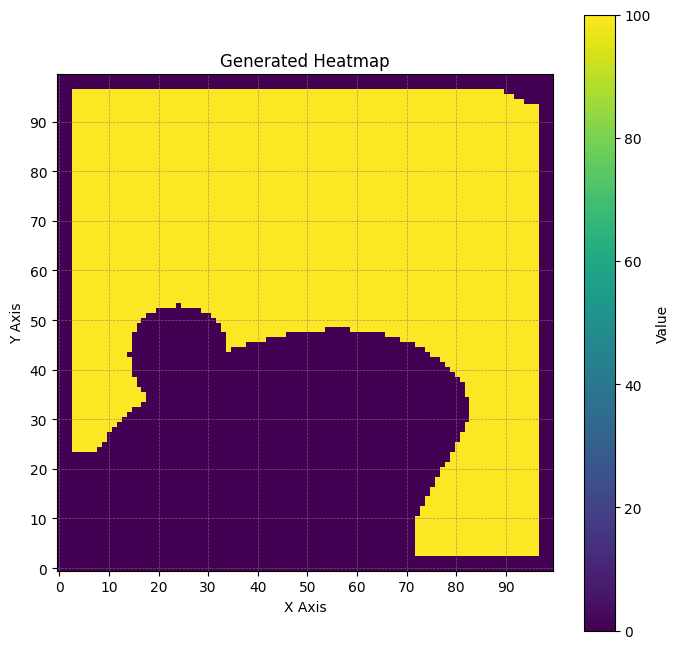

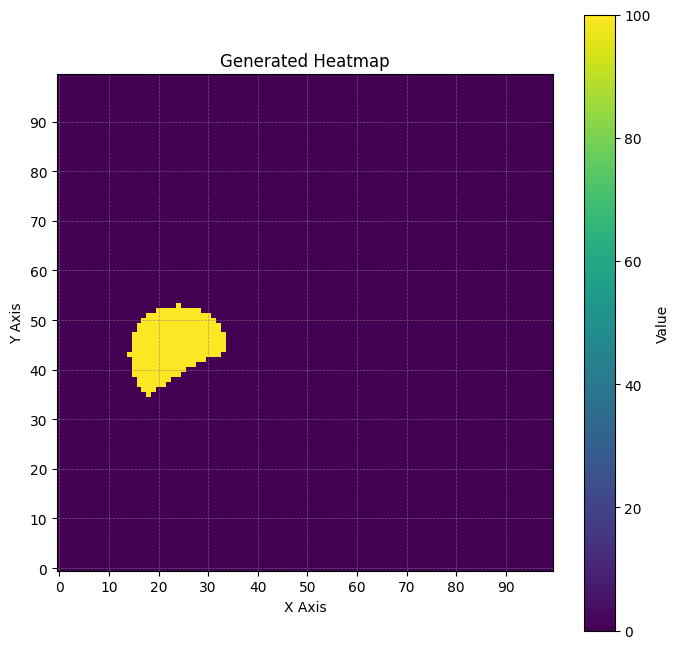

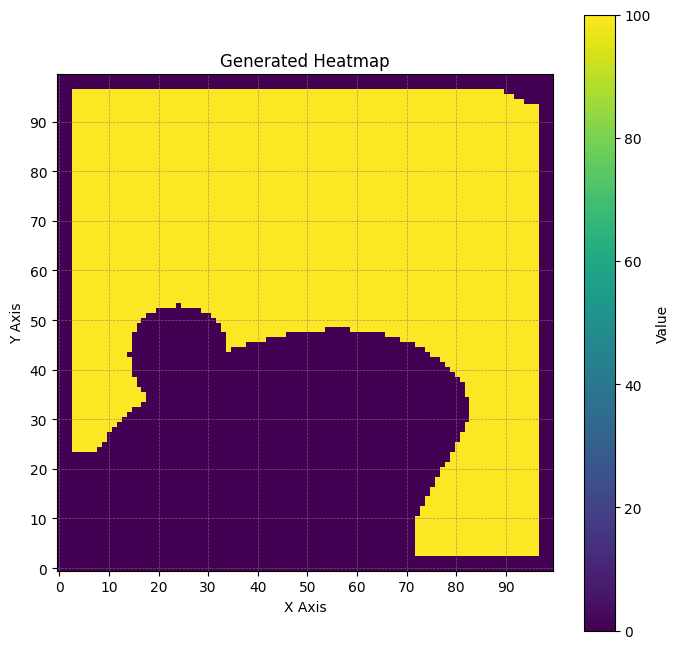

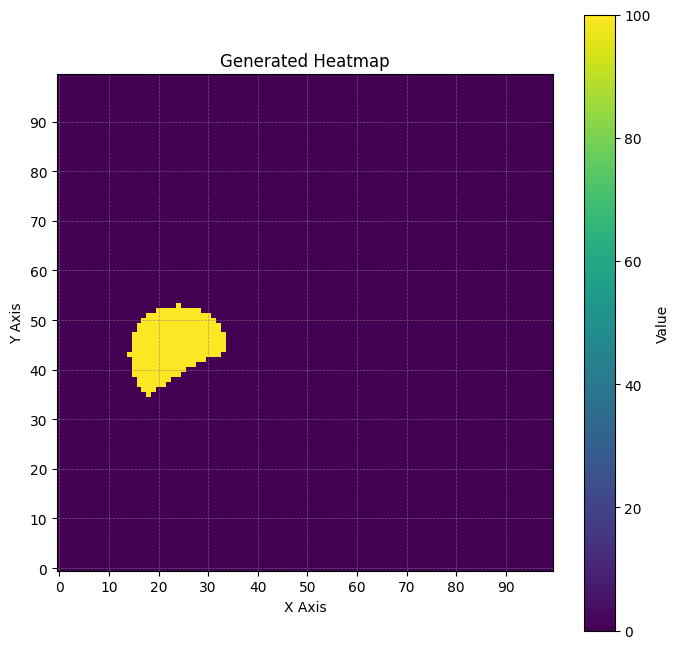

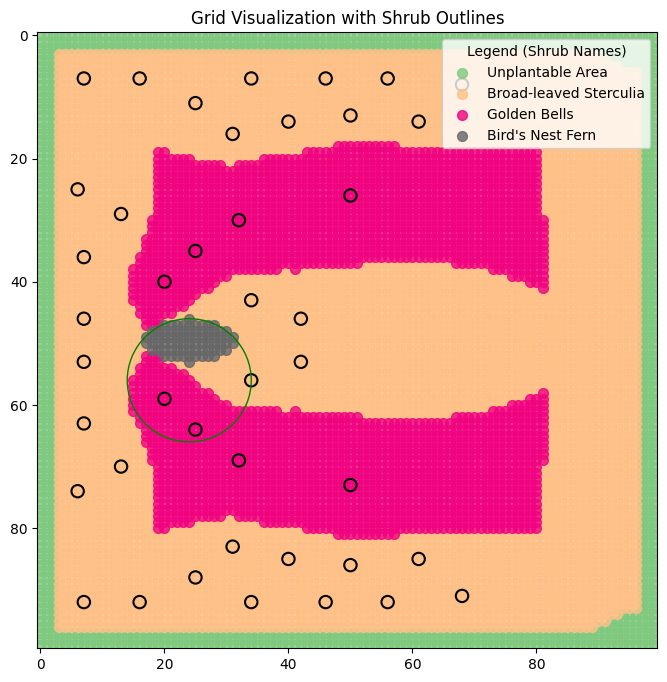

In [40]:
something = gridHatching_v2(grid2, starting_input,coordinates2)

output_json = something.create_hatching(visualise=True)